# **Installs**

In [ ]:
!pip install photutils --quiet
!pip install webbpsf --quiet

In [ ]:
!wget https://stsci.box.com/shared/static/qxpiaxsjwo15ml6m4pkhtk36c9jgj70k.gz -O webbpsf-data-1.2.1.tar.gz

In [ ]:
!tar -xf webbpsf-data-1.2.1.tar.gz

In [ ]:
!rm webbpsf-data-1.2.1.tar.gz

In [ ]:
!pip uninstall numexpr --quiet -y

# **Imports**

In [1]:
from gloess import gloess
from catalog_filter import box
from cmdtools import gen_CMD, gen_CMD_xcut, gen_CMD_ycut, running_avg

In [2]:
import sys
import time
import json
import numpy as np
import pandas as pd
import glob as glob
import urllib.request
import tarfile
import os
import itertools

from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.visualization import simple_norm
from astropy.nddata import NDData
from astropy.wcs import WCS
from astropy.modeling import models, fitting, custom_model
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.table import Table, QTable, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky, angular_separation
from astropy import units as u
from astropy.stats import SigmaClip, sigma_clipped_stats, gaussian_fwhm_to_sigma
from astropy.convolution import Gaussian2DKernel, convolve_fft
from astropy.nddata.utils import Cutout2D
from astropy.coordinates.matrix_utilities import rotation_matrix

import photutils as phot
from photutils.background import MMMBackground, MADStdBackgroundRMS, Background2D, LocalBackground
from photutils.detection import DAOStarFinder
from photutils.psf import EPSFBuilder, GriddedPSFModel
from photutils.psf import SourceGrouper, extract_stars, IterativePSFPhotometry, DAOPhotPSFPhotometry

from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry, EllipticalAperture

from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from scipy.ndimage import sobel, gaussian_filter, convolve
from scipy.signal import savgol_filter
from astropy.stats.biweight import biweight_location, biweight_midvariance,biweight_scale
from matplotlib.colors import LinearSegmentedColormap
from scipy.signal import find_peaks
from spectral_cube import SpectralCube
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization.wcsaxes import SphericalCircle

In [3]:
from reproject import reproject_exact
from reproject.mosaicking import find_optimal_celestial_wcs

In [4]:
os.environ['WEBBPSF_PATH'] = '../data/webbpsf-data'

In [5]:
%matplotlib inline
from matplotlib import style, pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.colors as col
from matplotlib.colors import ListedColormap
from matplotlib.patches import Circle
import seaborn as sb
import matplotlib.gridspec as gridspec
sb.set_style('white')
from matplotlib.ticker import (MultipleLocator, AutoLocator, AutoMinorLocator)
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['axes.titlesize'] = plt.rcParams['axes.labelsize'] = 35
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 35

font1 = {'family': 'sans-serif', 'color': 'black', 'weight': 'normal', 'size': '15'}
font2 = {'family': 'sans-serif', 'color': 'black', 'weight': 'normal', 'size': '25'}

In [6]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})


In [7]:
import multiprocessing as mp

In [8]:
""" Simulated (Webb PSF)
filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2','F150W', 'F162M', 'F164N', 'F182M',
           'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2','F323N',
           'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

psf_fwhm = [0.987,   1.103,   1.298,   1.553,   1.628,   1.770,   1.801,   1.494,   1.990, 
            2.060,   2.141,   2.304,   2.341,   1.340,   1.444,   1.585,   1.547,   1.711, 
            1.760,   1.830,   1.901,   2.165,   2.179,   2.300,   2.302,   2.459,   2.507, 2.535, 2.574]

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i]} for i in range(len(filters))}
""";

In [9]:
# Empirical (Rigby et al. 2022). https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-point-spread-functions
filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2','F150W', 'F162M', 'F164N', 'F182M',
           'F187N', 'F200W', 'F210M', 'F212N', 'F250M', 'F277W', 'F300M', 'F322W2','F323N',
           'F335M', 'F356W', 'F360M', 'F405N', 'F410M', 'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

psf_fwhm = [0.935,   1.065,   1.290,   1.548,   1.628,   1.613,   1.774,   1.806,   2.000, 
            2.065,   2.129,   2.290,   2.323,   1.349,   1.460,   1.587,   1.547,   1.714, 
            1.762,   1.841,   1.905,   2.159,   2.175,   2.286,   2.302,   2.492,   2.508, 2.540, 2.603]

dict_utils = {filters[i]: {'psf fwhm': psf_fwhm[i]} for i in range(len(filters))}

# **Input Data**

## **JWST**

In [ ]:
dict_images = {'NRCA1': {}, 'NRCA2': {}, 'NRCA3': {}, 'NRCA4': {}, 'NRCA5': {},
               'NRCB1': {}, 'NRCB2': {}, 'NRCB3': {}, 'NRCB4': {}, 'NRCB5': {}}

dict_cats = {}

images_dir = '../data/NGC_628/JWST/'

images = sorted(glob.glob(os.path.join(images_dir, "*/*i2d.fits")))
cats  = sorted(glob.glob(os.path.join(images_dir, "*/*cat.ecsv")))

for image in images:

    im = fits.open(image)
    f = im[0].header['FILTER']
    d = im[0].header['DETECTOR']

    if d == 'MULTIPLE':
        d = 'NRCB3'

    # Image
    if d not in dict_images.keys():
        dict_images[d] = {}
        
    if f not in dict_images[d].keys():
        dict_images[d][f] =  {'images': [image]}
    else:
        dict_images[d][f]['images'].append(image)
    
    # Catalog
    if d not in dict_cats.keys():
        dict_cats[d] = {}
        
    if f not in dict_cats[d].keys():
        dict_cats[d][f] =  {'cats': [image[:-8] + 'cat.ecsv']}
    else:
        dict_cats[d][f]['cats'].append(image[:-8] + 'cat.ecsv')
        
 
print('Available Detectors and Filters\n-------------------------------')
      
for i in dict_images.keys():
    if len(dict_images[i])>0:
        print(f'{i} :', list(dict_images[i].keys()))

In [ ]:
# MIRI
det_m = 'MIRIMAGE'
filt_m = 'F770W'

hdul_m = fits.open(dict_images[det_m][filt_m]['images'][0])
data_m = hdul_m[1].data
area_m = hdul_m[4].data

imh_m = hdul_m[1].header
wcs_m = WCS(imh_m)
ZAB_m = -6.1 - 2.5*np.log10(imh_m['PIXAR_SR'])
hdul_m.close()
print(f"Flux units of {filt_m}: {imh_m['BUNIT']}, Zero point (AB) : {ZAB_m}")
# NIRCAM
det_n = 'NRCB3'
filt_n = 'F200W'

hdul_n = fits.open(dict_images[det_n][filt_n]['images'][0])
data_n = hdul_n[1].data

imh_n = hdul_n[1].header
wcs_n = WCS(imh_n)
ZAB_n = -6.1 -2.5*np.log10(imh_n['PIXAR_SR'])

print(f"Flux units of {filt_n}: {imh_n['BUNIT']}, Zero point (AB) : {ZAB_n}")
hdul_n.close()

In [ ]:
"""
wcs_new = wcs_m.deepcopy()

wcs_new.wcs.pc= [[-1,0],
                 [0,1]]
wcs_new.wcs.crpix = np.array([750,750])
wcs_new.wcs.crval= np.array([24.173953, 15.783691])

out, footprint= reproject_exact((data_m, wcs_m), wcs_new, (1500,1500))
""";

In [ ]:
"""
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection=wcs_new)

norm = simple_norm(out, log_a=100, stretch= 'log',min_cut=12.6, max_cut = 65)

img = ax.imshow(out, norm = norm , cmap='gray')
cb = plt.colorbar(img, shrink=0.75, orientation='horizontal', pad=0.09)
cb.set_label('MJy/Sr')
cb.ax.tick_params(labelsize=20)


pos_bub = wcs_new.world_to_pixel_values([[24.186079, 15.772189]])
pos_gal = wcs_new.world_to_pixel_values([[24.173953, 15.783691]])

aper_in = EllipticalAperture(pos_bub, 162.26, 127.11, 216*u.degree)
aper_out = EllipticalAperture(pos_bub, 90.15, 70.62, 216*u.degree)

aper_in.plot(ax)
aper_out.plot(ax)

ax.annotate('', xy=pos_bub[0],
             xycoords='data',
             xytext=pos_gal[0],
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-|>',
                             color='white',
                             lw=1.5,
                             ls='-')
           )

ax.text(450,502,"1'=2.8kpc",rotation=46, color='white', fontsize=20)

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=7,direction="in")
ax.tick_params(which='minor', length=4)

lon = ax.coords[0]
lat = ax.coords[1]

lon.display_minor_ticks(True)
lat.display_minor_ticks(True)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
""";

In [ ]:
"""
plt.figure(figsize=(20, 12))

ax1= plt.subplot(1, 2, 1, projection=wcs_m)

ax1.set_title(filt_m, fontdict=font2)
norm = simple_norm(data_m, 'sqrt',min_cut=12, max_cut = 40)

img = ax1.imshow(data_m, norm = norm, cmap='gray')
ax1.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.5))
cb.set_label(f"{imh_m['BUNIT']}")

ax2 = plt.subplot(1, 2, 2, projection=wcs_n)

ax2.set_title(filt_n, fontdict=font2)
norm = simple_norm(data_n, 'sqrt',percent=99.)


img = ax2.imshow(data_n, norm = norm, cmap='gray')
ax2.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.5))
cb.set_label(f"{imh_n['BUNIT']}")
""";

### **Photometry strategy**

In [ ]:
ps = imh_n['CDELT1']*3600

In [ ]:
l = 24/ps

In [ ]:
l

In [ ]:
y = np.arange(0, 4597 + l, l)
x = np.arange(0, 11473 + l, l)

x_cen = 0.5*(x[:-1] + x[1:])
y_cen = 0.5*(y[:-1] + y[1:])

In [ ]:
len(x_cen), len(y_cen)

In [ ]:
poss = []

x_offset = 0
y_offset = 0
for i in x_cen:
    for j in y_cen:
        poss.append([i-x_offset,j-y_offset])
        
poss = np.array(poss)

In [ ]:
x = poss[:,0]
y = poss[:,1]
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(x,y)

for i,j in poss:
        ax.add_patch(Rectangle((i-l/2, j-l/2), l,l, fill = False,
                              edgecolor='black', lw=1))

ax.set_xlim(0,11604)
ax.set_ylim(0,4640)

In [ ]:
coords  = np.array(wcs_n.pixel_to_world_values(poss)).astype(np.float64)

In [ ]:
coords_cen  = np.array(wcs_n.pixel_to_world_values([[0,7*20/ps]]))

In [ ]:
ra_cen, dec_cen = coords_cen[0]

In [ ]:
360 - 309.41851

In [ ]:
fig, ax = plt.subplots(figsize=(12,4))
angle =  245.00492
x = coords[:,0]
y = coords[:,1]
ax.scatter(x,y)

regions = {}
for n,coord in enumerate(coords):
    i = coord[0]
    j = coord[1]
    regions[f'reg_{n}'] = {}
    regions[f'reg_{n}']['ra'] = i
    regions[f'reg_{n}']['dec'] = j
    print(f"""box({np.round(i,9)}, {np.round(j,9)}, {l*ps}", {l*ps}",{angle}) # text=""" + '{' + f'Reg {n}' + '}')


ra_t = regions['reg_0']['ra']
dec_t = regions['reg_0']['dec']

ax.scatter([ra_t], [dec_t], marker='x', color='black')
ax.invert_xaxis()
ax.axis('equal')

In [ ]:
with open('regions90_m83.json', 'w') as convert_file: 
     convert_file.write(json.dumps(regions))

#### **Radial Completeness**

In [ ]:
poss_cen = wcs_n.world_to_pixel_values([[ra,dec]])[0]

In [ ]:
poss_cen[0]

In [ ]:
poss = []
for i in range(5):
    poss.append([poss_cen[0]+1307.*i,poss_cen[1]])

poss = np.array(poss)

In [ ]:
x = poss[:,0]
y = poss[:,1]
fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(x,y)

for i,j in poss:
        ax.add_patch(Rectangle((i-653.5, j-653.5), 1307,1307, fill = False,
                              edgecolor='black', lw=1))


ax.set_xlim(0,11417)
ax.set_ylim(0,4486)

In [ ]:
940/20

In [ ]:
coords = np.array(wcs_n.pixel_to_world_values(poss))

In [ ]:
coords[0,1]

In [ ]:
r = angular_separation(coords[:,0]*u.deg, coords[:,1]*u.deg,
                                         coords[0,0]*u.deg, coords[0,1]*u.deg).to(u.arcsec).value*47/1e3

In [ ]:
f115w_c = [24.3, 25.02, 25.76, 26.33, 27.06]
f150w_c = [23.45, 24.17, 25.01, 25.51, 25.88]
f200w_c = [22.3,  23.03, 23.95, 24.58, 25.04]

In [ ]:
fig,ax = plt.subplots(figsize=(7,5))

ax.plot(r, f115w_c,'-o')
ax.plot(r, f150w_c,'-o')
ax.plot(r, f200w_c,'-o')
ax.legend(['F115W','F150W','F200W'])
ax.set_xlabel('r [Mpc]')
ax.set_ylabel(r'$m_{50}$')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

#ax.set_yticks(np.arange(22.5,27,0.5))
ax.tick_params(which='both', length=14,direction="in", bottom=True, top=True,left=True, labelsize=12)
ax.tick_params(which='minor', length=8)
ax.set_title(r'Radial Compleness limit variation')

In [ ]:
regions = {}
for n,coord in enumerate(coords):
    i = coord[0]
    j = coord[1]
    regions[f'reg_{n}'] = {}
    regions[f'reg_{n}']['ra'] = i
    regions[f'reg_{n}']['dec'] = j

In [ ]:
regions

### **Plots**

In [ ]:
pos = SkyCoord(ra=ra, dec=dec, unit='deg')

In [ ]:
cutout_m = Cutout2D(data_m,pos,size = 41*u.arcsec, wcs = wcs_m)
cutout_n = Cutout2D(data_n,pos,size = 41*u.arcsec, wcs = wcs_n)

In [ ]:
cutout_n.data.shape

In [ ]:
plt.figure(figsize=(32, 20))

ax1 = plt.subplot(1, 2, 1, projection=cutout_m.wcs)

ax1.set_title(filt_m, fontdict=font2)
norm = simple_norm(cutout_m.data, 'sqrt',min_cut=13, max_cut = 40)

img = ax1.imshow(cutout_m.data, norm = norm, cmap='gray')
# MIRI Contours
levels = [13.2,15]
cmap = ListedColormap(['yellow','cyan'])
smooth_data = gaussian_filter(cutout_m.data, 2)
ax1.contour(smooth_data, levels=levels, cmap=cmap)

#ax1.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.6))
cb.set_label(f"{imh_m['BUNIT']}")

ax2 = plt.subplot(1, 2, 2, projection=cutout_n.wcs)

ax2.set_title(filt_n, fontdict=font2)
norm = simple_norm(cutout_n.data, 'log',min_percent=10, max_percent=99., log_a =10)

img = ax2.imshow(cutout_n.data, norm = norm, cmap='gray')
ax2.contour(smooth_data, levels=levels, cmap=cmap, transform=ax2.get_transform(cutout_m.wcs))
#ax2.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.6))
cb.set_label(f"{imh_n['BUNIT']}")

#plt.savefig('MIRI_NIRCAM_bubble.eps', bbox_inches='tight')

In [ ]:
cutout_n.data.shape

In [ ]:
images_dir = '../data/NGC_628/HST/'
images = sorted(glob.glob(os.path.join(images_dir, "*/*drc.fits")))

dict_images_hst = {}

for image in images:

    im = fits.open(image)
    if 'FILTER2' in im[0].header.keys():
        f = im[0].header['FILTER2']
    elif 'FILTER' in im[0].header.keys():
        f = im[0].header['FILTER']
    
    if 'CLEAR' in f:
        f = im[0].header['FILTER1']
        
    d = im[0].header['DETECTOR']

    # Image
    if d not in dict_images_hst.keys():
        dict_images_hst[d] = {}
        
    if f not in dict_images_hst[d].keys():
        dict_images_hst[d][f] =  {'images': [image]}
    else:
        dict_images_hst[d][f]['images'].append(image)    
 
print('Available Detectors and Filters\n-------------------------------')
      
for i in dict_images_hst.keys():
    if len(dict_images_hst[i])>0:
        print(f'{i} :', list(dict_images_hst[i].keys()))

In [ ]:
det_n = 'WFC'
filt_n = 'F814W'

hdul_n = fits.open(dict_images_hst[det_n][filt_n]['images'][0])
data_n = hdul_n[1].data

imh_n = hdul_n[1].header
wcs_n = WCS(imh_n)

print(f"Flux units of {filt_n}: {imh_n['BUNIT']}")
hdul_n.close()

In [ ]:
pos = SkyCoord(ra=ra, dec=dec, unit='deg')

In [ ]:
cutout_m = Cutout2D(data_m,pos,size = 50*u.arcsec, wcs = wcs_m)
cutout_n = Cutout2D(data_n,pos,size = 50*u.arcsec, wcs = wcs_n)

In [ ]:
plt.figure(figsize=(30, 20))

ax1 = plt.subplot(1, 2, 1, projection=cutout_m.wcs)

ax1.set_title(filt_m, fontdict=font2)
norm = simple_norm(cutout_m.data, 'sqrt',min_cut=13, max_cut = 40)

img = ax1.imshow(cutout_m.data, norm = norm, cmap='gray')
# MIRI Contours
levels = [13.2,15]
cmap = ListedColormap(['yellow','cyan'])
smooth_data = gaussian_filter(cutout_m.data, 2)
ax1.contour(smooth_data, levels=levels, cmap=cmap)

ax1.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.5))
cb.set_label(f"{imh_m['BUNIT']}")

ax2 = plt.subplot(1, 2, 2, projection=cutout_n.wcs)

ax2.set_title(filt_n, fontdict=font2)
norm = simple_norm(cutout_n.data, 'sqrt',percent=99.)

img = ax2.imshow(cutout_n.data, norm = norm, cmap='gray')
ax2.contour(smooth_data, levels=levels, cmap=cmap, transform=ax2.get_transform(cutout_m.wcs))
ax2.grid(color='red', ls='solid')
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.5))
cb.set_label(f"{imh_n['BUNIT']}")

In [ ]:
hdul = fits.open('../data/NGC_628/MUSE/NGC0628_MAPS_native.fits')  # Open the FITS file for reading

muse_wcs = WCS(hdul[6].header)

ha = hdul[30].data
ha_err = hdul[31].data

hb = hdul[6].data
hb_err = hdul[7].data

nii = hdul[36].data
nii_err = hdul[37].data

oiii = hdul[18].data
oiii_err = hdul[19].data
sii16 = hdul[42].data
sii30 = hdul[48].data
sii = sii16 +  sii30

st_vel = hdul[2].data
st_sigma = hdul[4].data

ha_vel = hdul[32].data
ha_vel_err = hdul[33].data

ha_sigma = hdul[34].data

hdul.close()

In [ ]:
oiii_ha = oiii/ha

In [ ]:
ha_mask1 = ha<3*ha_err 
ha_mask2 = np.isnan(ha)
ha_mask3 = np.isnan(ha_err)
ha_mask = ha_mask1 | ha_mask2 | ha_mask3

oiii_mask1 = oiii<3*oiii_err 
oiii_mask2 = np.isnan(oiii)
oiii_mask3 = np.isnan(oiii_err)
oiii_mask = oiii_mask1 | oiii_mask2 |oiii_mask3

In [ ]:
oiii_ha_mask = ha_mask | oiii_mask
oiii_ha_mask = np.where(oiii_ha_mask, np.nan,1)

In [ ]:
plt.imshow(oiii_ha_mask, cmap='jet')

In [ ]:
header1 = muse_wcs.to_header()
header1['FRAME'] = 'OIII/H-alpha'
header2 = muse_wcs.to_header()
header2['FRAME'] = 'OIII/H-alpha_mask'
header3 = muse_wcs.to_header()
header3['FRAME'] = 'OIII/H-alpha_err'

oiii_ha_err = np.sqrt(oiii_err**2 + ha_err**2)

In [ ]:
oiii_ha_filt = np.where((oiii_ha_bin>1) & (~np.isinf(oiii_ha_bin)) & (~np.isnan(oiii_ha_bin)), oiii_ha_bin, 0)

In [ ]:
plt.hist(oiii_ha_filt, bins=np.arange(1,2,0.1))

In [ ]:
fig = plt.figure(figsize=(13,10))

ax = fig.add_subplot( projection=muse_wcs)
norm = simple_norm(oiii_ha_bin, 'log',min_percent=10, max_percent = 93.)
img = ax.imshow(oiii_ha_bin, norm=norm, cmap='jet')
plt.colorbar(img,ax=ax)

In [ ]:
hdu1 = fits.PrimaryHDU(data=oiii_ha, header= header1)
hdu2 = fits.ImageHDU(data=oiii_ha_mask, header= header2)
hdu3 = fits.ImageHDU(data=oiii_ha_err, header= header3)

hdul = fits.HDUList([hdu1,hdu2,hdu3])
hdul.writeto('../data/NGC_628/MUSE/OIII_H_alpha.fits', overwrite=True)

In [ ]:
logoiii_ha = np.log10(

In [ ]:
hdu = fits.PrimaryHDU(data=ha, header= muse_wcs.to_header())
hdul = fits.HDUList([hdu])
hdul.writeto('../data/NGC_628/MUSE/MUSE_H_alpha_emlinefits', overwrite=True)

### **BPT Diagrams**

In [ ]:
x_ = np.log10(nii/ha)
y_ = np.log10(oiii/hb)
fig, ax  = plt.subplots(figsize=(7,7))
ax.scatter(x_, y_, s=0.001, color='blue')

x = np.linspace(-2,0)
y = 0.61/(x-0.05) + 1.3

mask1 = y_ < 0.61/(x_-0.05) + 1.3
mask2 = y_< 0.61/(x_-0.47) + 1.19
mask3 = x_<0
mask4 = ~np.isnan(x_)
mask5 = ~np.isnan(y_)

mask = mask1 & mask2 & mask3 & mask4 & mask5

sf_mask1 = np.where(mask,1,np.nan)
x_ *= sf_mask1
y_ *= sf_mask1

ax.scatter(x_, y_, s=0.001, color='cyan')

ax.plot(x,y,'--k')

x = np.linspace(-2,0.25)
y = 0.61/(x-0.47) + 1.19

ax.plot(x,y,'-r')

ax.set_xlim(-2, 1)
ax.set_ylim(-1.2,1.5)

ax.set_xlabel(r'$LOG([NII]/H\alpha)$')
ax.set_ylabel(r'$LOG([OIII]/H\beta)$')

In [ ]:
x_ = np.log10(nii/ha)
y_ = np.log10(oiii/hb)
fig, ax  = plt.subplots(figsize=(10,10))

ax.scatter(x_, y_, s=0.001, color='blue')


mask1 = y_ < 0.72/(x_-0.32) + 1.3
mask2 = x_<0
mask3 = ~np.isnan(x_)
mask4 = ~np.isnan(y_)

mask = mask1 & mask2 & mask3 & mask4 

sf_mask2 = np.where(mask,1,np.nan)
x_ *= sf_mask2
y_ *= sf_mask2

ax.scatter(x_, y_, s=0.001, color='cyan')
           
x = np.linspace(-2,0.2)
y = 0.72/(x-0.32) + 1.3
ax.plot(x,y,'--k')

x = np.linspace(-0.315,0.4)
y = 1.89*x + 0.76

ax.plot(x,y,'-r')

ax.set_xlim(-1, 1)
ax.set_ylim(-1.2,1.5)

ax.set_xlabel(r'$LOG([SII]/H\alpha)$')
ax.set_ylabel(r'$LOG([OIII]/H\beta)$')

In [ ]:
sf_mask = sf_mask1*sf_mask2

### **Emission Line Maps**

In [ ]:
fig = plt.figure(figsize=(28,10))

ax1 = fig.add_subplot(121, projection=muse_wcs)
norm = simple_norm(ha, 'log',min_percent=5, max_percent = 99.9)
ax1.imshow(ha, norm=norm, cmap='jet')
ax1.set_title(r'H$\alpha$ (6562 $\AA$)')

ax2 = fig.add_subplot(122, projection=muse_wcs, sharey=ax1)
norm = simple_norm(hb, 'log',min_percent=5, max_percent = 99.9)
img = ax2.imshow(hb, norm=norm, cmap='jet')
ax2.set_title(r'H$\beta$ (4861.35 $\AA$)')

cb = plt.colorbar(img, ax= [ax1,ax2])
cb.set_label(r'$1e-20.ergs.s^{-1}.cm^{-2}.spaxel^{-1}$')
cb.ax.set_yticks([0,100,500,5000]);

### **Extinction and Balmer Decrement**

In [ ]:
ha_mask1 = ha<3*ha_err 
ha_mask2 = np.isnan(ha)
ha_mask3 = np.isnan(ha_err)
ha_mask = ha_mask1 | ha_mask2 | ha_mask3

hb_mask1 = hb<3*hb_err 
hb_mask2 = np.isnan(hb)
hb_mask3 = np.isnan(hb_err)
hb_mask = hb_mask1 | hb_mask2 | hb_mask3

In [ ]:
plt.imshow(ha_mask1)

In [ ]:
Av_mask = ha_mask | hb_mask
Av_mask = np.where(Av_mask, np.nan,1)

In [ ]:
ha_hb = ha/hb
E_B_V = 0.934*np.log(ha_hb/2.86)

Av_map_muse = 3.1*E_B_V*Av_mask

Av_map_muse = np.where(np.isinf(abs(Av_map_muse)),np.nan,Av_map_muse)


Av_map_muse = np.where(Av_map_muse<0,np.nan,Av_map_muse)

In [ ]:
fig = plt.figure(figsize=(13,10))

ax = fig.add_subplot( projection=muse_wcs)
norm = simple_norm(Av_map_muse, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(Av_map_muse, norm=norm, cmap='jet')
ax.set_title(r'Av')
cb = plt.colorbar(img, ax=ax)

for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r)

In [ ]:
Av_n,_ = reproject_exact((Av_map_muse, muse_wcs), wcs_n, data_n.shape)

In [ ]:
Av_map_n = np.full_like(reg_arr,np.nan)
Av_map_std = np.full_like(reg_arr,np.nan)
for i in range(15):
    for j in range(6):
        k = int(reg_arr[i,j])
        region =  regions_dict[f'reg_{k}']
        ra = region['ra']
        dec = region['dec']
        pos = SkyCoord(ra=ra,dec=dec, frame='icrs', unit='deg')
        cutout = Cutout2D(Av_n, pos, 24*u.arcsec,wcs = wcs_n)
        if not np.all(np.isnan(cutout.data)):
            Av_map_n[i,j] =  np.nanmedian(cutout.data)
            Av_map_std[i,j] =  np.nanstd(cutout.data)
                           

In [ ]:
np.nanmin(Av_map_n.T)

In [ ]:
fig = plt.figure(figsize=(28,10))

ax = fig.add_subplot(111)
norm = simple_norm(Av_map_n.T, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(Av_map_n.T, norm=norm, cmap='jet')
ax.set_title('Av')
cb = plt.colorbar(img, ax=ax)
cb.set_label('Av')

In [ ]:
hdu = fits.PrimaryHDU(data=Av_map, header= muse_wcs.to_header())
hdul = fits.HDUList([hdu])
hdul.writeto('../data/NGC_628/MUSE/MUSE_Av.fits', overwrite=True)

### **N2 Gas-phase Metallicity**

In [ ]:
n2 = nii/ha

ha_mask1 = ha<3*ha_err 
ha_mask2 = np.isnan(ha)
ha_mask3 = np.isnan(ha_err)
ha_mask = ha_mask1 | ha_mask2 | ha_mask3

nii_mask1 = nii<3*nii_err 
nii_mask2 = np.isnan(nii)
nii_mask3 = np.isnan(nii_err)
nii_mask = nii_mask1 | nii_mask2 | nii_mask3

n2_mask = nii_mask | ha_mask

n2_mask = np.where(n2_mask, np.nan,1)

oh = 8.9 + 0.57*np.log10(n2)*n2_mask

oh = np.where(np.isinf(abs(oh)),np.nan,oh)

In [ ]:
fig = plt.figure(figsize=(28,10))

ax = fig.add_subplot(121, projection=muse_wcs)
norm = simple_norm(oh, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(oh, norm=norm, cmap='jet')
ax.set_title('Gas Phase Metallicity')
cb = plt.colorbar(img, ax=ax)
cb.set_label('12 + log(OH)')

for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r)

ax = fig.add_subplot(122, projection=muse_wcs)
norm = simple_norm(oh*sf_mask, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(oh*sf_mask, norm=norm, cmap='jet')
ax.set_title('Gas Phase Metallicity with SF Mask')
cb = plt.colorbar(img, ax=ax)
cb.set_label('12 + log(OH)')


for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r)

In [ ]:
oh_z = 10**(oh-8.69)*0.017

In [ ]:
fig = plt.figure(figsize=(28,10))

ax = fig.add_subplot(111, projection=muse_wcs)
norm = simple_norm(oh_z, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(oh_z, norm=norm, cmap='jet')
ax.set_title('Gas Phase Metallicity')
cb = plt.colorbar(img, ax=ax)
cb.set_label('Z')

for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r)


In [ ]:
oh_z_n,_ = reproject_exact((oh_z, muse_wcs), wcs_n, data_n.shape)

In [ ]:
fig = plt.figure(figsize=(28,10))

ax = fig.add_subplot(111, projection=wcs_n)
norm = simple_norm(oh_z_n, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(oh_z_n, norm=norm, cmap='jet')
ax.set_title('Gas Phase Metallicity')
cb = plt.colorbar(img, ax=ax)
cb.set_label('Z')

for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r)


In [ ]:
Z_gas = np.full_like(reg_arr,np.nan)
Z_gas_std = np.full_like(reg_arr,np.nan)
for i in range(15):
    for j in range(6):
        k = int(reg_arr[i,j])
        region =  regions_dict[f'reg_{k}']
        ra = region['ra']
        dec = region['dec']
        pos = SkyCoord(ra=ra,dec=dec, frame='icrs', unit='deg')
        cutout = Cutout2D(oh_z_n, pos, 24*u.arcsec,wcs = wcs_n)
        if not np.all(np.isnan(cutout.data)):
            Z_gas[i,j] =  np.nanmedian(cutout.data)
            Z_gas_std[i,j] =  np.nanstd(cutout.data)
                           

In [ ]:
fig = plt.figure(figsize=(28,10))

ax = fig.add_subplot(111)
norm = simple_norm(Z_gas.T, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(Z_gas.T, norm=norm, cmap='jet')
ax.set_title('Gas Phase Metallicity')
cb = plt.colorbar(img, ax=ax)
cb.set_label('Z')

### **Spatially-resolved SFR**

In [ ]:
F_ha_dc = ha*pow(10,2.468*E_B_V)*1e-20

cosmo = FlatLambdaCDM(69.6, 0.286)
z = (650.55*u.km/u.s).to(u.dimensionless_unscaled,u.doppler_redshift())
DL = cosmo.luminosity_distance(z.value).to(u.cm).value

L_ha = F_ha_dc*4*np.pi*DL**2

SFR = 5.5*pow(10,-42)*L_ha*sf_mask

In [ ]:
fig = plt.figure(figsize=(13,10))

ax = fig.add_subplot( projection=muse_wcs)
norm = simple_norm(SFR, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(SFR, norm=norm, cmap='jet')
ax.set_title('SFR')
cb = plt.colorbar(img, ax=ax)
cb.set_label(r'$M_{\odot}/yr$')

for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'))
    ax.add_patch(r)

### **Velocity maps**

In [ ]:
ha_vel_mask1 = np.abs(ha_vel)<3*ha_vel_err 
ha_vel_mask2 = np.isnan(ha_vel)
ha_vel_mask3 = np.isnan(ha_vel_err)
ha_vel_mask = ha_vel_mask1 | ha_vel_mask2 | ha_vel_mask3

ha_vel_mask = np.where(ha_vel_mask, np.nan,1)

In [ ]:
ha_vel[700,700], ha_vel_err[700,700]

In [ ]:
fig = plt.figure(figsize=(28,10))

ax = fig.add_subplot(121, projection=muse_wcs)
norm = simple_norm(st_vel, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(st_vel, norm=norm, cmap='RdBu_r')
ax.set_title('Stellar Velocity')
cb = plt.colorbar(img, ax=ax)
cb.set_label(r'$km/s$')

for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'), lw=3)
    ax.add_patch(r)

ax = fig.add_subplot(122, projection=muse_wcs)
norm = simple_norm(ha_vel, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(ha_vel, norm=norm, cmap='RdBu_r')
ax.set_title(r'$H\alpha$ Velocity')
cb = plt.colorbar(img, ax=ax)
cb.set_label(r'$km/s$')

for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'), lw=3)
    ax.add_patch(r)

In [ ]:
fig = plt.figure(figsize=(28,10))

ax = fig.add_subplot(121, projection=muse_wcs)
norm = simple_norm(st_sigma, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(st_sigma, norm=norm, cmap='jet')
ax.set_title('Stellar Velocity Dispersion')
cb = plt.colorbar(img, ax=ax)
cb.set_label(r'$km/s$')


ax = fig.add_subplot(122, projection=muse_wcs)
norm = simple_norm(ha_sigma, 'sqrt',min_percent=10, max_percent = 93.)
img = ax.imshow(ha_sigma, norm=norm, cmap='jet')
ax.set_title(r'$H\alpha$ Velocity Dispersion')
cb = plt.colorbar(img, ax=ax)
cb.set_label(r'$km/s$')

for i in range(21):
    region =  regions_dict[f'bubble_{i}']
    ra = region['ra']
    dec = region['dec']
    radius = region['radius']
    
    r = SphericalCircle((ra* u.deg, dec* u.deg), radius * u.arcsec,
                         edgecolor='black', facecolor='none',
                         transform=ax.get_transform('icrs'), lw =3)
    ax.add_patch(r)

# **Photometric Analysis**

In [10]:
Av_dict = { 
            'f275w': 2.02499,
            'f336w': 1.67536,
            'f435w': 1.33879,
            'f555w': 1.03065,
            'f814w': 0.59696,
            'f115w': 0.419,
            'f150w': 0.287,
            'f200w': 0.195,
    
            'f438w': 1.34148,
            'f606w': 0.90941,
            'f814w': 0.59845
          }

In [11]:
regions_dict = {'bubble' : {'ra'   : 24.1858128,  
                       'dec'  : 15.7725802,
                       'F115W': 25.4, 
                       'F150W': 24.63,
                       'F200W': 23.53,
                      
                       'F435W': 27.88, 
                       'F555W': 27.48,
                       'F814W': 26.52},
           
           'bkg1'   : {'ra'   : 24.1918038,
                       'dec'  : 15.7600032,
                       'F115W': 26., 
                       'F150W': 25.26,
                       'F200W': 24.21,
                      
                      'F435W': 28.26, 
                       'F555W': 27.94,
                       'F814W': 27.05},
              
           'bkg2'   : {'ra'   : 24.1787197,
                       'dec'  : 15.7543227,
                       'F115W': 26.31, 
                       'F150W': 25.39,
                       'F200W': 24.39,
                      
                      'F435W': 28.26, 
                       'F555W': 27.94,
                       'F814W': 27.05},
              
           'bkg3'   : {'ra'   : 24.1728133,
                       'dec'  : 15.7669357,
                       'F115W': 25.42, 
                       'F150W': 24.55,
                       'F200W': 23.56,
                      
                      'F435W': 27.88, 
                       'F555W': 27.48,
                       'F814W': 26.52},
                
            'ngc628' : {'ra'   : 24.1738983, 
                       'dec'  : 15.7836543,
                       'F115W': 25.42, 
                       'F150W': 24.55,
                       'F200W': 23.56},
            'm83' :  {'ra'   : 204.2536827 ,  
                       'dec'  : -29.8655432,
                       'F115W': 25.42, 
                       'F150W': 24.55,
                       'F200W': 23.56},
            'm81-gc' :  {'ra':  149.47781,
                           'dec': 68.816955,
                          },
            
            'bubble_outer': {'ra':24.1560650 ,
                            'dec': 15.8189300,
                            'radius': 16.187}}
                             
            
with open('regions90_ngc628.json') as json_file:
    data = json.load(json_file)
    
regions_dict.update(data)

with open('../data/DS9 regions/bubbles.reg') as f:
    dat = f.readlines()
    
bubbles = {}
for n,i in enumerate(dat[3:]):
    ra = float(i.split(',')[0][7:])
    dec = float(i.split(',')[1])
    radius = float(i.split(',')[2].split('"')[0])
    bubbles[f'bubble_{n}'] = {'ra' : ra,
                              'dec': dec,
                              'radius': radius}
regions_dict.update(bubbles) ;

## **JWST**

In [12]:
df_cmd_jwst = pd.read_csv("../data/isochrones_master/cmd_jwst.csv")

In [13]:
ages= np.unique(df_cmd_jwst['logAge'])
mets = np.unique(df_cmd_jwst['Zini'])

In [14]:
np.sqrt(0.02**2 + 0.02**2)

0.0282842712474619

### **CMD**

Label: 0=PMS, 1=MS, 2=SGB, 3=RGB, (4,5,6)=different stages of CHEB, 7=EAGB, 8=TPAGB, 9=post-AGB

In [14]:
ages_ = [6.8,7,7.2, 7.5,7.8,8,8.2,8.5,8.8,9,9.6,10]

ages_y = [6.8, 7.0,7.3,7.6,7.8,8,8.5,8.8]
ages_o = [9.0, 9.6,10]
mag_err_lim = 0.2

In [ ]:
r_in = 0
r_out = 24


tab = Table.read('../photometry/ngc628/f115w_f200w.fits')

ra_cen = regions_dict['reg_0']['ra']
dec_cen = regions_dict['reg_0']['dec']

fig,ax, tab1 = gen_CMD(tab,'f115w', 'f200w', 'f200w', ra_cen=ra_cen, dec_cen=dec_cen,
                       cmd=df_cmd_jwst, Av_=1, Av_x=2.5, Av_y=26, 
                       xlims=[-0.5,4], ylims=[19,27.5],
                       gen_kde=False, met=0.003,dismod=29.7126, ages=ages_,
                        r_in=r_in, r_out=r_out, sqr_field=True)

In [68]:
tab = Table.read('../photometry/ngc628/f115w_f150w_f200w.fits')

df = tab[(tab['mag_err_1']<0.2) & (tab['mag_err_2']<0.2) & (tab['mag_err']<0.2)] 

Text(0, 0.5, 'mag_err')

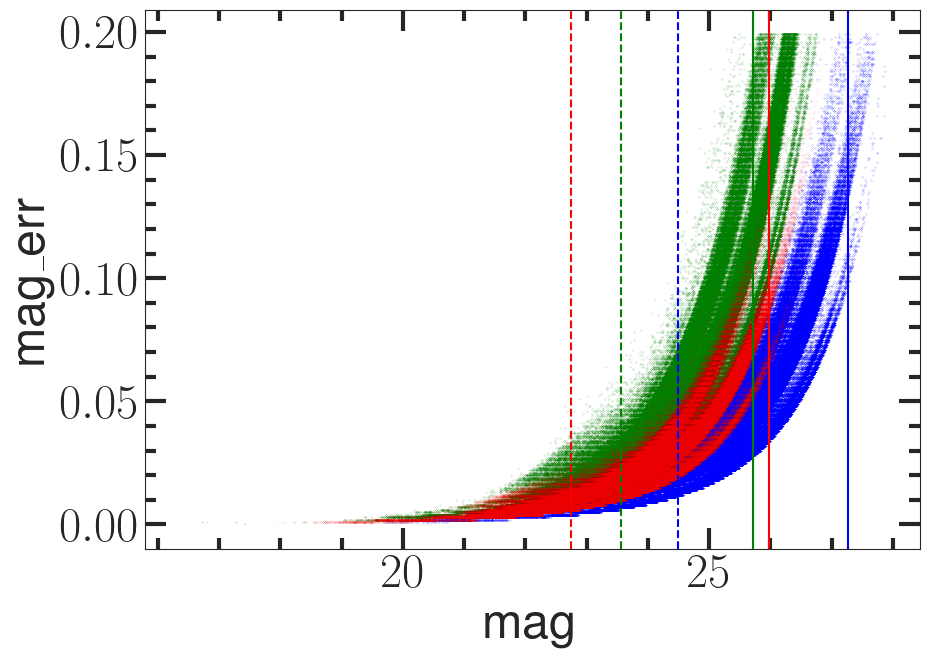

In [71]:
fig, ax = plt.subplots(figsize=(10,7))

x = df['mag_vega_F115W']
y = df['mag_err']
ax.scatter(x,y,s=0.01,color='blue')
ax.axvline([24.49524254],ls='--', color='blue')
ax.axvline([27.27155834],ls='-', color='blue')

x = df['mag_vega_F150W']
y = df['mag_err_1']
ax.scatter(x,y,s=0.01,color='green')
ax.axvline([23.5535029],ls='--', color='green')
ax.axvline([25.71734278],ls='-', color='green')

x = df['mag_vega_F200W']
y = df['mag_err_2']

ax.scatter(x,y,s=0.001,color='red')
ax.axvline([22.7474432],ls='--', color='red')
ax.axvline([25.9781503],ls='-', color='red')


ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True,width=3)
ax.tick_params(which='minor', length=8,width=3)

ax.set_xlabel('mag')
ax.set_ylabel('mag_err')

In [ ]:
x = tab1['mag_vega_F115W'] -  tab1['mag_vega_F200W']
y = tab1['mag_vega_F200W']

ind = (x>=0.5) & (x<=1.6) & (y>=23.5) & (y<=26)

y_n, x_n = running_avg(y[ind], x[ind], 100)

fig, ax = plt.subplots()

ax.scatter(x,y,s=0.1)
ax.plot(x_n,y_n, color='red')

ax.invert_yaxis()

In [ ]:
filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

tab = Table.read('../photometry/ngc628/f115w_f200w.fits')

r_in  = 0
r_out = 24

dl= 0.05
l_lo = 23.5
l_hi = 24
cmd_xlo = 0.5
cmd_xhi = 2

ra_cen  = regions_dict['reg_0']['ra']
dec_cen = regions_dict['reg_0']['dec']

fig, ax, dats_bub, x_val, y_val, y_bins, model_rgb = gen_CMD_xcut(tab,filt1, filt2,filt3, ra_cen=ra_cen, dec_cen=dec_cen,
                                                       cmd=df_cmd_jwst, label_min=0, label_max=3,Av=0.19+0.1,
                                                      r_in=r_in, r_out=r_out, age=10, met=0.002,Av_y=23.5, Av_x=0,
                                                      l_lo=l_lo, l_hi=l_hi,dismod=29.7126,ylims=[22,26],
                                                       dl=dl,cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,           
                                                      fit_isochrone=False)


In [ ]:
model_rgb(23)

In [ ]:
min_ = 1
max_ = 2
step = 0.025
bins = np.arange(min_, max_, step)

init = models.Gaussian1D()
fit = fitting.LevMarLSQFitter()

for i in range(len(y_val)):
    
    fig, ax = plt.subplots()
    dat1 = dats_bub[i][0]
    dat2 = dats_bkg3[i][0]

   # Bubble
    y, x = np.histogram(dat1, bins=bins)
    max_bub = y.max()
    
    x = 0.5*(x[1:] + x[:-1])
    
    ax.step(x,y, where='mid', color='black')
    
    model = fit(init,x,y)
    xn = np.linspace(x.min(),x.max(),1000)
    
    ax.plot(xn,model(xn),'-b')
    
    x_p1 = model.mean.value
    s_p1 = model.stddev.value
    ax.plot([x_p1, x_p1],[0,model.amplitude.value], '--b')
    
    # Bkg3
    y, x = np.histogram(dat2, bins=bins)
    
    max_bkg3 = y.max()
    
    x = 0.5*(x[1:] + x[:-1])
    
    ax.step(x,y, where='mid', color='gold')
    
    model = fit(init,x,y)
    xn = np.linspace(x.min(),x.max(),1000)
    ax.plot(xn,model(xn),'-', color='orange')
    
    x_p3 = model.mean.value
    s_p3 = model.stddev.value
    ax.plot([x_p3, x_p3],[0,model.amplitude.value], '--', color='orange')
    
    max_ = np.max([max_bub,  max_bkg3])
    
    
    ax.plot([x_val[i], x_val[i]], [0, max_+10],'-g',linewidth=3)
    title = f"{np.round(y_bins[i],2)} - {np.round(y_bins[i+1],3)} (mag)| "
    title += r"$\mu_{bubble} :$" + f"{np.round(x_p1,3)}" + r" $\mu_{bkg3} :$" + f"{np.round(x_p3,3)} " 
    
    title += r'$\sigma_{bubble} : $ ' + f"{np.round(s_p1,3)} " + r' $\sigma_{bkg3} : $ ' + f"{np.round(s_p3,3)}\n"
    title +=  r"$\ dist_{bub,ref}$ : " + f"{np.round(x_p1 - x_val[i],3)}  " 
    title +=   r"$\ dist_{bkg3,ref}$ : " + f"{np.round(x_p3 - x_val[i],3)}"
    
    ax.set_title(title, fontsize=15)
    ax.set_ylabel('Counts', fontsize=15)
    ax.legend(['Bubble', 'Bubble Gaussian Fit', 'Bubble mean', 'Bkg3', 'Bkg3 Gaussian Fit', 'Bkg3 mean',
                 'Reference line'])
    
    ax.set_xlabel('Color');
    plt.show()

### **TRGB**

#### **Magnitude**

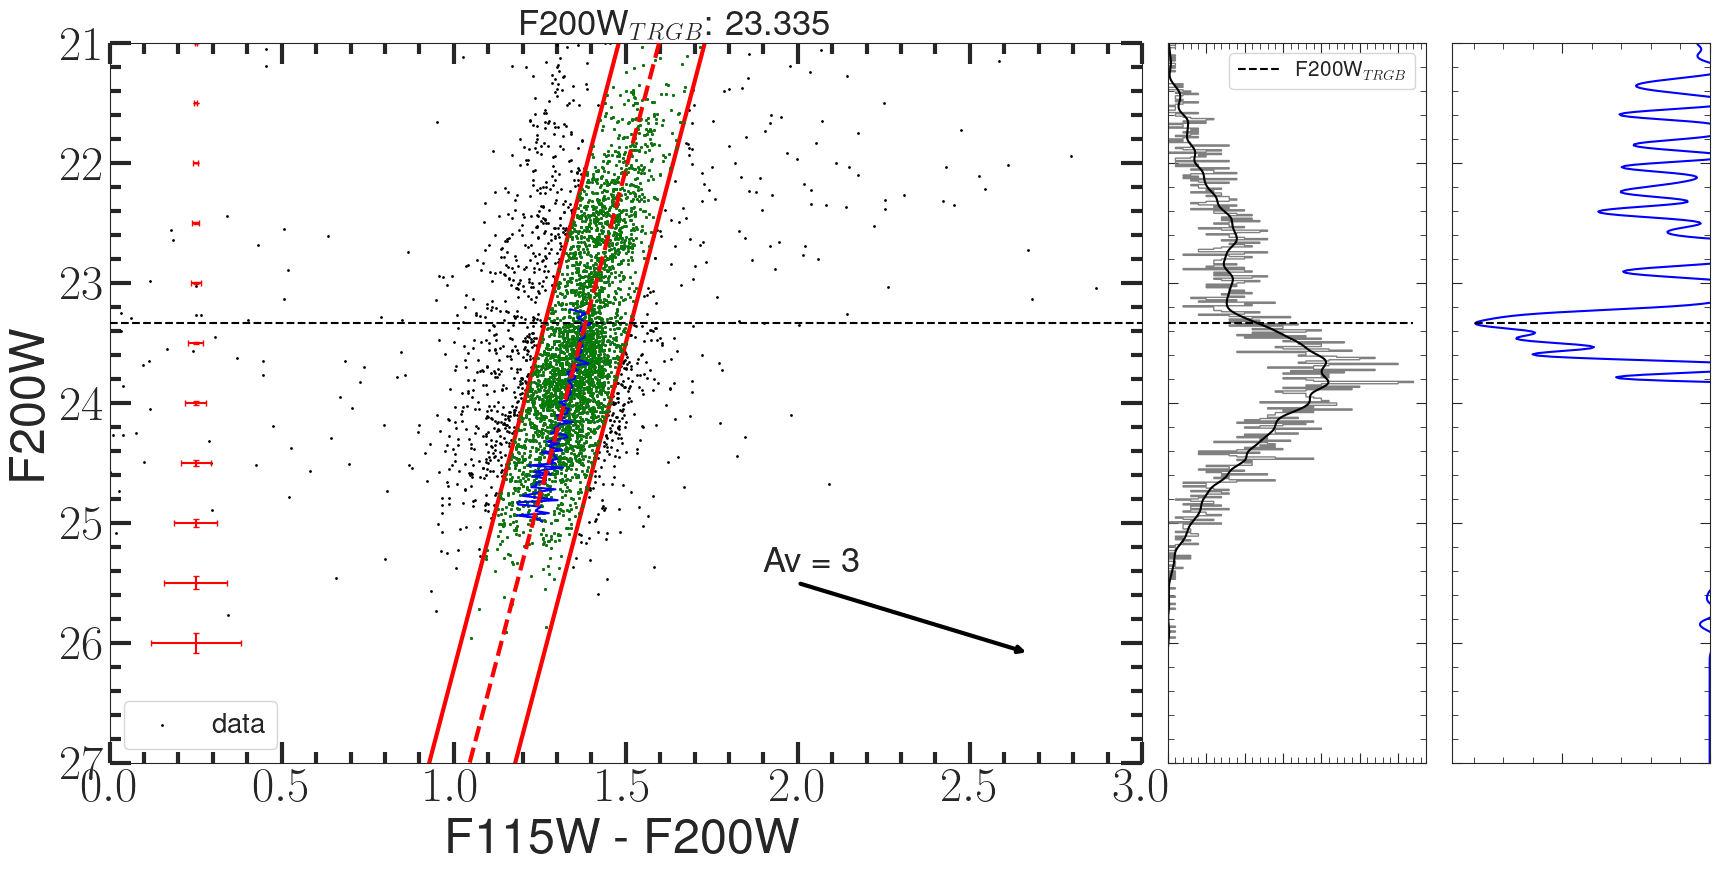

In [30]:
filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

model_mag_err_f200w = models.Exponential1D(1.87077026e-10, 1.31284337e+00)
model_col_err = models.Exponential1D(9.72187779e-10, 1.39331541e+00)

r_in  = 0
r_out = 8.9

dy= 0.25
    
y_lo = 19
y_hi = 28

cmd_xlo = 1.25
y0 = 23.5

cmd_xhi = cmd_xlo + dy*1.1

nx = 15
ny = 6

col_lims = [23.20, 23.7]
bins = np.arange(y_lo, y_hi, 0.01)
sigma_s = 0.05
tab = Table.read('../photometry/ngc628/f115w_f200w.fits')

k = 0

#ra_cen  = regions_dict[f'reg_{k}']['ra']
#dec_cen = regions_dict[f'reg_{k}']['dec']

ra_cen  = regions_dict[f'bubble']['ra']
dec_cen = regions_dict[f'bubble']['dec']

fig = plt.figure(figsize=(20, 9))
gs = fig.add_gridspec(1, 3,  width_ratios=(4, 1,1),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax =  fig.add_subplot(gs[0, 0])
fig, ax, dats_bub, x_val, y_val, y_bins,params = gen_CMD_ycut(tab, filt1, filt2, filt3,cmd=None, 
                                                              ra_cen=ra_cen, dec_cen=dec_cen,
                                                              r_in=r_in, r_out=r_out,
                                                              met=0.003, sqr_field=False, mag_err_lim=0.2,
                                                              age=10, gen_kde=False, Av_y = 25.5,
                                                              y_lo=y_lo, y_hi=y_hi, rgb_ylo=23.2, rgb_yhi=25,
                                                              dy=dy, cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                               xlims=[0.,3], ylims=[21,27], y0=y0,
                                                              fit_isochrone=False, perp_iso=False, 
                                                              dismod=29.7416, fig=fig, ax=ax,s=1,lw=3,
                                                              mag_err_cols=['mag_err_1','mag_err_2'])
ax_hist = fig.add_subplot(gs[0, 1], sharey=ax)
ax_edge = fig.add_subplot(gs[0, 2], sharey=ax)
ax.set_title('')

for dat in dats_bub:
    ms = []
    for i in range(1000):
        x = dat[0]
        y = dat[1]
        
        #x = np.random.normal(loc=x,scale=model_col_err(y))
        #y = np.random.normal(loc=y,scale=model_mag_err_f200w(y))

        yh,xh,_, = ax_hist.hist(y,bins, orientation='horizontal' , histtype='step', color='grey')
        xh = 0.5*(xh[1:] + xh[:-1])

        yf = gloess(xh,yh,sigma_s,1)
        ysob = np.convolve(yf,np.array([-1,0,1]), mode='same')

        ax_hist.plot(yf, xh, color='black')
        ax_edge.plot(ysob, xh,'b',alpha=1)

        c1 = (xh>=col_lims[0]) & (xh<=col_lims[1])
        m = xh[c1][ysob[c1]==ysob[c1].min()][0]
        ms.append(m)
        break
        
    ax_hist.tick_params(axis="y", labelleft=False)
    ax_edge.tick_params(axis="x", labelbottom=False)
    ax_edge.tick_params(axis="y", labelleft=False)

    ax_edge.set_title(f'{filt3.upper()}'+ '$_{TRGB}$' f': {np.round(m,5)}', fontsize=25,x=-3)
    ax.plot([0,3],[m,m],'--k', zorder=201)
    ax_hist.plot([0,yh.max()],[m,m],'--k',label=f'{filt3.upper()}'+ '$_{TRGB}$')
    ax_hist.legend(fontsize=15)
    ax_hist.set_xticks([np.ceil(yh.max())],[np.ceil(yh.max())])
    ax_hist.tick_params(axis='both', labelsize=0)
   # dismod = m - params[0]-params[1]
   # ax_hist.set_title(f'DM : {np.round(dismod, 3)}', fontsize=25)
    ax_edge.plot([ysob.min(),ysob.max()],[m,m],'--k')
    ax_edge.set_xlim([ysob.min()*1.1,0])
    #ax_edge.invert_xaxis()

    for ax_ in [ax_hist, ax_edge]:
        ax_.xaxis.set_major_locator(AutoLocator())
        ax_.xaxis.set_minor_locator(AutoMinorLocator())

        
        ax_.yaxis.set_major_locator(AutoLocator())
        ax_.yaxis.set_minor_locator(AutoMinorLocator())

        ax_.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
        ax_.tick_params(which='minor', length=4)

In [19]:
10**-0.5

0.31622776601683794

In [23]:
np.std(ms)

0.0076664920269972495

In [24]:
np.median(ms)

23.4950000000007

In [81]:
filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

model_mag_err_f200w = models.Exponential1D(1.87077026e-10, 1.31284337e+00)
model_col_err = models.Exponential1D(9.72187779e-10, 1.39331541e+00)

r_in  = 0
r_out = 24

if filt3 == 'f200w':
    dy= 0.25
elif filt3 == 'f115w':
    dy = 0.25
elif filt3== 'f150w':
    dy = 0.25
    
y_lo = 19
y_hi = 28

if filt3 == 'f200w':
    cmd_xlo = 1.25
    y0 = 23.5
elif filt3 == 'f115w':
    cmd_xlo = 1.25
    y0 = 24.8
elif filt3 == 'f150w':
    cmd_xlo = 1.23
    y0 = 24.

cmd_xhi = cmd_xlo + dy*1.1

nx = 15
ny = 6

if filt3 == 'f200w':
    col_lims = [23.20, 23.7]
    
elif filt3 == 'f115w':
    col_lims = [24.4, 25.1]
    
elif filt3 == 'f150w':
    col_lims = [23.5, 24.3]

k = 0

mss = []
tab = Table.read('../photometry/ngc628/f115w_f200w.fits')

for b in np.arange(0.001,0.0101,0.001):
    bins = np.arange(y_lo, y_hi, b)
    ms = []
    for sigma_s in np.arange(0.05,0.101,0.01):

        fig = plt.figure(figsize=(20, 9))
        gs = fig.add_gridspec(1, 3,  width_ratios=(4, 1,1),
                              left=0.1, right=0.9, bottom=0.1, top=0.9,
                              wspace=0.05, hspace=0.05)

        ax =  fig.add_subplot(gs[0, 0])
        
        ra_cen  = regions_dict[f'reg_{k}']['ra']
        dec_cen = regions_dict[f'reg_{k}']['dec']
        
        fig, ax, dats_bub, x_val, y_val, y_bins,params = gen_CMD_ycut(tab, filt1, filt2, filt3,cmd=df_cmd_jwst, 
                                                              ra_cen=ra_cen, dec_cen=dec_cen,
                                                              r_in=r_in, r_out=r_out,
                                                              met=0.003, sqr_field=True, mag_err_lim=0.2,
                                                              age=10, gen_kde=False,
                                                              y_lo=y_lo, y_hi=y_hi, rgb_ylo=23,
                                                              dy=dy, cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                              xlims=[0.,3], ylims=[21,27], y0=y0,
                                                              fit_isochrone=True, perp_iso=False, 
                                                              dismod=29.7416, fig=fig, ax=ax,
                                                              mag_err_cols=['mag_err_1','mag_err_2'])

        ax_hist = fig.add_subplot(gs[0, 1], sharey=ax)
        ax_edge = fig.add_subplot(gs[0, 2], sharey=ax)


        for dat in dats_bub:
            ms_ = []
            for _ in range(1):
                x = dat[0]
                y = dat[1]
                
                #x = np.random.normal(loc=x,scale=model_col_err(x))
                #y = np.random.normal(loc=y,scale=model_mag_err_f200w(y))

                yh,xh,_, = ax_hist.hist(y,bins, orientation='horizontal' , histtype='step', color='grey')
                xh = 0.5*(xh[1:] + xh[:-1])

                yf = gloess(xh,yh,sigma_s,1)
                ysob = np.convolve(yf,np.array([-1,0,1]), mode='same')

                ax_hist.plot(yf, xh, color='black')
                ax_edge.plot(ysob, xh,'b')

                c1 = (xh>=col_lims[0]) & (xh<=col_lims[1])
                m = xh[c1][ysob[c1]==ysob[c1].min()][0]
                
                ms_.append(m)

            ax_hist.tick_params(axis="y", labelleft=False)
            ax_edge.tick_params(axis="x", labelbottom=False)
            ax_edge.tick_params(axis="y", labelleft=False)

            ax_edge.set_title(f'{filt3.upper()}'+ '$_{TRGB}$' f': {np.round(m,5)}', fontsize=25)
            ax.plot([0,3],[m,m],'--k', zorder=201)
            ax_hist.plot([0,yh.max()],[m,m],'--k',label=f'{filt3.upper()}'+ '$_{TRGB}$')
            ax_hist.legend(fontsize=15)
            ax_hist.set_xticks([np.ceil(yh.max())],[np.ceil(yh.max())])
            ax_hist.tick_params(axis='both', labelsize=0)
            dismod = m - params[0]-params[1]
            ax_hist.set_title(f'DM : {np.round(dismod, 3)}', fontsize=25)
            ax_edge.plot([ysob.min(),ysob.max()],[m,m],'--k')
            ax_edge.set_xlim([ysob.min()*1.1,0])
            #ax_edge.invert_xaxis()

            for ax_ in [ax_hist, ax_edge]:
                ax_.xaxis.set_major_locator(AutoLocator())
                ax_.xaxis.set_minor_locator(AutoMinorLocator())

                ax_.yaxis.set_major_locator(AutoLocator())
                ax_.yaxis.set_minor_locator(AutoMinorLocator())

                ax_.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
                ax_.tick_params(which='minor', length=4)

            fig.savefig(f"TRGB/{filt3}/region_{k}_{filt3}_{k}_{sigma_s}_{b}_mag.png")
            plt.close(fig) 
        ms.append(ms_)
    mss.append(ms)

m_t = np.array(mss)
print(k)

Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of objects in the selected region: 5697
Number of obj

In [37]:
m_t.T.shape

(1, 6, 10)

In [82]:
np.round(np.nanmedian(m_t),4), np.round(np.nanstd(m_t),4), np.nanmedian(m_t) - params[0] - params[1]

(23.4687, 0.0161, 29.902699999999903)

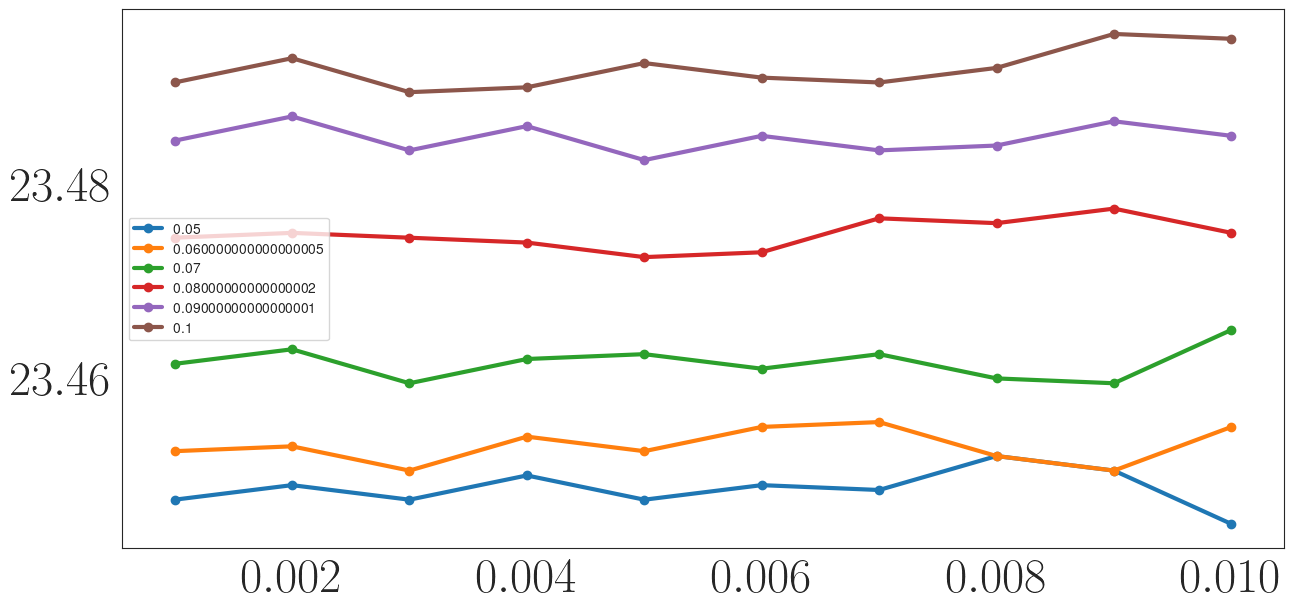

In [83]:
bins = np.arange(0.001, 0.011, 0.001)

plt.figure(figsize=(15,7))
for n, i in enumerate(m_t.T[0]):
    
    plt.plot(bins, i, '-o',lw=3)
plt.legend(np.arange(0.05, 0.11, 0.01))

In [162]:
yy, xx  =np.mgrid[0:5,0:15]

In [163]:
z = (xx-7)**2 + (yy-2)**2

In [164]:
nx = 15
ny = 6

k=0
reg_arr = np.zeros_like(trgb_mags_J[:,:])
for i in range(nx):
    for j in range(ny):
        reg_arr[i,j]=k
        k+=1

In [165]:
reg_arr

array([[ 0.,  1.,  2.,  3.,  4.,  5.],
       [ 6.,  7.,  8.,  9., 10., 11.],
       [12., 13., 14., 15., 16., 17.],
       [18., 19., 20., 21., 22., 23.],
       [24., 25., 26., 27., 28., 29.],
       [30., 31., 32., 33., 34., 35.],
       [36., 37., 38., 39., 40., 41.],
       [42., 43., 44., 45., 46., 47.],
       [48., 49., 50., 51., 52., 53.],
       [54., 55., 56., 57., 58., 59.],
       [60., 61., 62., 63., 64., 65.],
       [66., 67., 68., 69., 70., 71.],
       [72., 73., 74., 75., 76., 77.],
       [78., 79., 80., 81., 82., 83.],
       [84., 85., 86., 87., 88., 89.]])

In [27]:
reg_block = reg_arr[0:5]
reg_block = list([ [f'reg_{int(j)}' for j in i] for i in reg_block])

In [27]:
reg_block

[['reg_0', 'reg_1', 'reg_2', 'reg_3', 'reg_4', 'reg_5'],
 ['reg_6', 'reg_7', 'reg_8', 'reg_9', 'reg_10', 'reg_11'],
 ['reg_12', 'reg_13', 'reg_14', 'reg_15', 'reg_16', 'reg_17'],
 ['reg_18', 'reg_19', 'reg_20', 'reg_21', 'reg_22', 'reg_23'],
 ['reg_24', 'reg_25', 'reg_26', 'reg_27', 'reg_28', 'reg_29']]

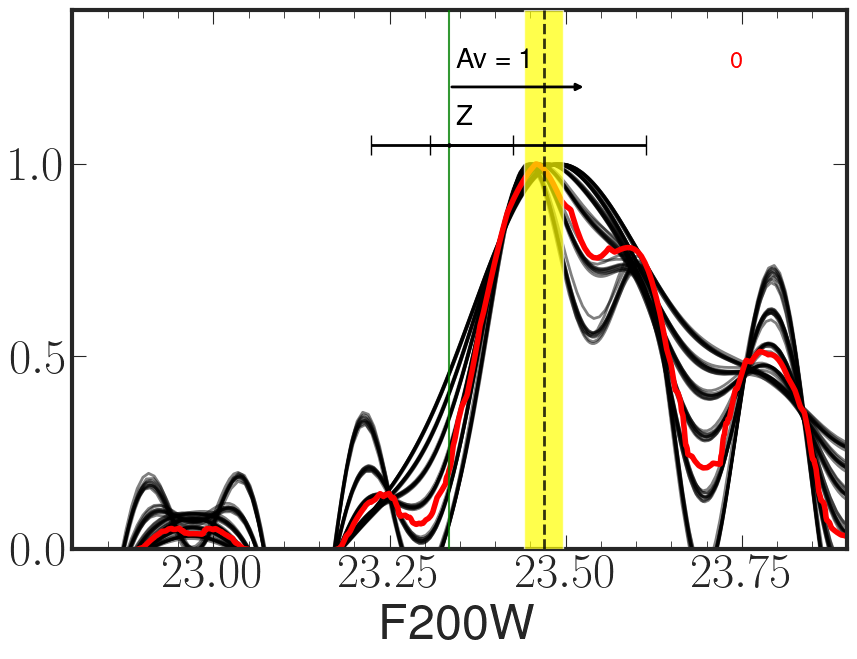

In [28]:
filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

r_in  = 0
r_out = 24

if filt3 == 'f200w':
    dl= 0.25
elif filt3 == 'f115w':
    dl = 0.25
elif filt3== 'f150w':
    dl = 0.25
    
l_lo = 19
l_hi = 28

if filt3 == 'f200w':
    cmd_xlo = 1.25
    y0 = 23.5
elif filt3 == 'f115w':
    cmd_xlo = 1.25
    y0 = 24.8
elif filt3 == 'f150w':
    cmd_xlo = 1.23
    y0 = 24.

cmd_xhi = cmd_xlo + dl*1.1

nx = 15
ny = 6

if filt3 == 'f200w':
    col_lims = [23.20, 23.7]
    
elif filt3 == 'f115w':
    col_lims = [24.4, 25.1]
    
elif filt3 == 'f150w':
    col_lims = [23.5, 24.3]


fig, ax= plt.subplots(1,1,figsize=(10, 7),sharex=True, sharey=True)

tab = Table.read('../photometry/ngc628/f115w_f200w.fits')

ms = []
k = 'reg_0'

if k =='bubble':
    r_out = 8.9
    k_id = 'bubble'
    sqr_field = False
else:
    r_out = 24
    k_id = float(k.split('_')[-1])
    sqr_field = True

ysobs = []

ra_cen  = regions_dict[k]['ra']
dec_cen = regions_dict[k]['dec']

for b in np.arange(0.001,0.011,0.001):
    for sigma_s in np.arange(0.05,0.11,0.01):

        if not os.path.exists(f'trgb_grid/{k_id}_{b}_{sigma_s}.npy'):
            fig1, ax1, dats_bub, x_val, y_val, y_bins,params = gen_CMD_ycut(tab, filt1, filt2, filt3,cmd=df_cmd_jwst, 
                                                      ra_cen=ra_cen, dec_cen=dec_cen,
                                                      r_in=r_in, r_out=r_out,
                                                      met=0.003, sqr_field=sqr_field, mag_err_lim=0.2,
                                                      age=10, gen_kde=False,
                                                      l_lo=l_lo, l_hi=l_hi, rgb_ylo=23,
                                                      dl=dl, cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                       xlims=[0.,3], ylims=[21,27], y0=y0,
                                                      fit_isochrone=False, perp_iso=False, 
                                                      dismod=29.7416)
            np.save(f'trgb_grid/{k_id}_{b}_{sigma_s}.npy', dats_bub)
            plt.close(fig1)

        else:
            dats_bub = np.load(f'trgb_grid/{k_id}_{b}_{sigma_s}.npy')

        for dat in dats_bub:
            x = dat[0]
            y = dat[1]

            bins = np.arange(l_lo, l_hi, b)
            yh,xh= np.histogram(y,bins)  
            xh = 0.5*(xh[1:] + xh[:-1])

            yf = gloess(xh,yh.astype(np.float64),sigma_s,1)
            ysob = np.convolve(yf,np.array([-1,0,1]), mode='same')

            ax.plot(xh,ysob/ysob.min(),'-k', alpha=0.5, lw=2) 

            xn = np.arange(l_lo, l_hi, 0.001)
            xn= 0.5*(xn[1:] + xn[:-1])  
            ysob = np.interp(xn,xh,ysob)            
            ysobs.append(ysob)

ysobs = np.array(ysobs)
ysob = np.median(ysobs, axis=0)

ax.plot(xn,ysob/ysob.min(),'r', lw=4) 
if k == 'bubble':
    x = bubble_f200w
    xerr = 0.016885
else:
    x = trgb_f200w_mag[np.where(reg_arr==k_id)][0]
    xerr = trgb_f200w_err[np.where(reg_arr==k_id)][0]
    k_id = int(k_id)

ax.plot([x,x],[0,1.4], '--k',zorder=100,alpha=0.8,lw=2)

ax.plot([bubble_f200w,bubble_f200w],[0,1.4], '-g', alpha=0.8,zorder=195)

ax.bar(x,1.4,2*xerr, color='yellow',alpha=0.7, zorder=10)

ax.set_xlim(22.8,23.9)

ax.set_ylim(0,1.4)
ax.annotate(k_id,(23.75-len(str(k_id))*1.5e-2,1.25), color='red', fontsize=17, zorder=400)
# 0.27915,  0.09015, -0.02685, -0.11085
ax.errorbar([bubble_f200w],[1.05],xerr=np.atleast_2d([0.11085, 0.27915]).T,
                 fmt='.k',elinewidth=2,markersize=4, capsize=7, zorder=300)

ax.errorbar([bubble_f200w],[1.05],xerr=np.atleast_2d([0.02685, 0.09015]).T,
                 fmt='.k',elinewidth=2,markersize=4, capsize=7, zorder=300)

AF =  Av_dict['f200w']*1

ax.annotate('', xy=(bubble_f200w, 1.2),
             xycoords='data',  weight='bold',
             xytext=(bubble_f200w+AF, 1.2),
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-',
                             color='black',
                             lw=2,
                             ls='-'), zorder=400
           )


ax.annotate(f'Av = {1}', xy=(bubble_f200w+0.01, 1.25),
             xycoords='data', weight='bold', fontsize=20,
             textcoords='data', zorder=300, color='black'
           )

ax.annotate(f'Z', xy=(bubble_f200w+0.01, 1.1),
             xycoords='data', color='black', weight='bold',
             textcoords='data', zorder=300,fontsize=20,
           )

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=10,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=6)

for spine in ax.spines.values():
    spine.set_linewidth(3) 

ax.set_xlabel('F200W')

plt.subplots_adjust(hspace=0,wspace=0)

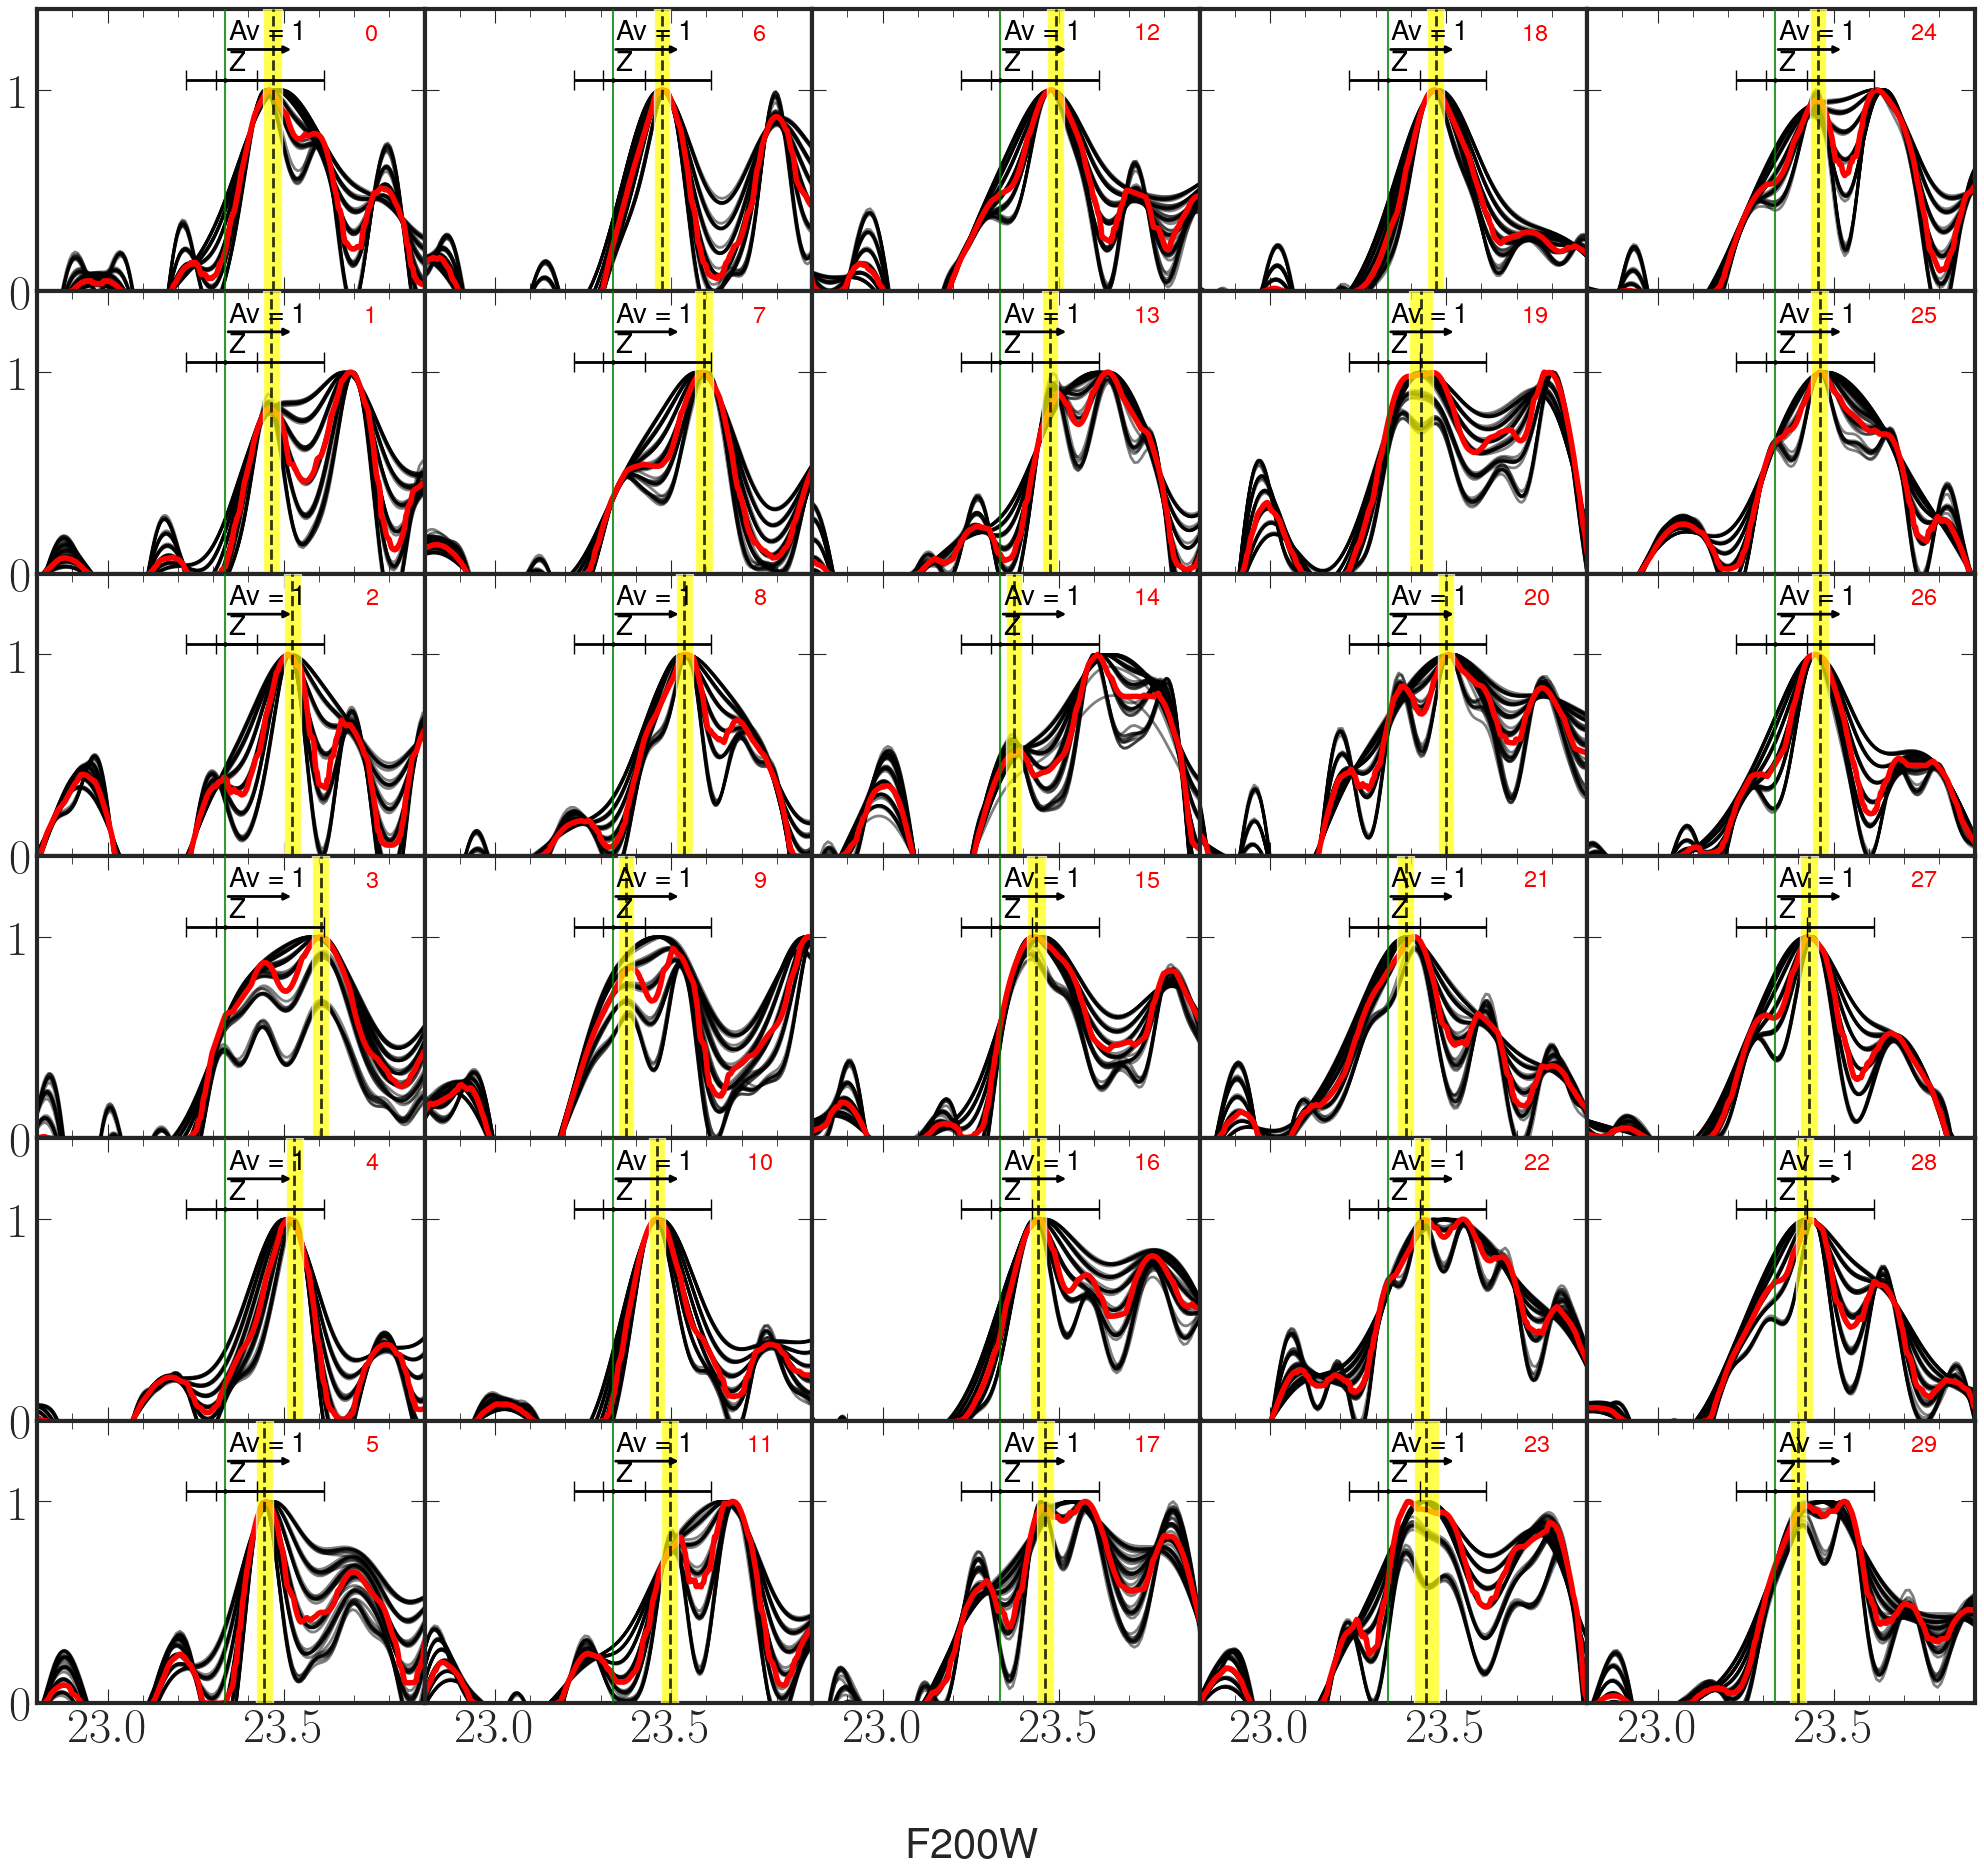

In [30]:
filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

r_in  = 0
r_out = 24

if filt3 == 'f200w':
    dl= 0.25
elif filt3 == 'f115w':
    dl = 0.25
elif filt3== 'f150w':
    dl = 0.25
    
l_lo = 19
l_hi = 28

if filt3 == 'f200w':
    cmd_xlo = 1.25
    y0 = 23.5
elif filt3 == 'f115w':
    cmd_xlo = 1.25
    y0 = 24.8
elif filt3 == 'f150w':
    cmd_xlo = 1.23
    y0 = 24.

cmd_xhi = cmd_xlo + dl*1.1

nx = 15
ny = 6

if filt3 == 'f200w':
    col_lims = [23.20, 23.7]
    
elif filt3 == 'f115w':
    col_lims = [24.4, 25.1]
    
elif filt3 == 'f150w':
    col_lims = [23.5, 24.3]


fig, ax= plt.subplots(6,5,figsize=(25, 22),sharex=True, sharey=True)

tab = Table.read('../photometry/ngc628/f115w_f200w.fits')

for i in range(6):
    for j in range(5):
        ms = []
        k = reg_block[j][i]
        
        if k =='bubble':
            r_out = 8.9
            k_id = 'bubble'
            sqr_field = False
        else:
            r_out = 24
            k_id = float(k.split('_')[-1])
            sqr_field = True
            
        ysobs = []
        
        ra_cen  = regions_dict[k]['ra']
        dec_cen = regions_dict[k]['dec']
        
        for b in np.arange(0.001,0.011,0.001):
            for sigma_s in np.arange(0.05,0.11,0.01):
                
                if not os.path.exists(f'trgb_grid/{k_id}_{b}_{sigma_s}.npy'):
                    fig1, ax1, dats_bub, x_val, y_val, y_bins,params = gen_CMD_ycut(tab, filt1, filt2, filt3,cmd=df_cmd_jwst, 
                                                              ra_cen=ra_cen, dec_cen=dec_cen,
                                                              r_in=r_in, r_out=r_out,
                                                              met=0.003, sqr_field=sqr_field, mag_err_lim=0.2,
                                                              age=10, gen_kde=False,
                                                              l_lo=l_lo, l_hi=l_hi, rgb_ylo=23,
                                                              dl=dl, cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,
                                                               xlims=[0.,3], ylims=[21,27], y0=y0,
                                                              fit_isochrone=False, perp_iso=False, 
                                                              dismod=29.7416)
                    np.save(f'trgb_grid/{k_id}_{b}_{sigma_s}.npy', dats_bub)
                    plt.close(fig1)
                    
                else:
                    dats_bub = np.load(f'trgb_grid/{k_id}_{b}_{sigma_s}.npy')
                
                for dat in dats_bub:
                    x = dat[0]
                    y = dat[1]
                    
                    bins = np.arange(l_lo, l_hi, b)
                    yh,xh= np.histogram(y,bins)  
                    xh = 0.5*(xh[1:] + xh[:-1])

                    yf = gloess(xh,yh.astype(np.float64),sigma_s,1)
                    ysob = np.convolve(yf,np.array([-1,0,1]), mode='same')
                     
                    ax[i,j].plot(xh,ysob/ysob.min(),'-k', alpha=0.5, lw=2) 
                    
                    xn = np.arange(l_lo, l_hi, 0.001)
                    xn= 0.5*(xn[1:] + xn[:-1])  
                    ysob = np.interp(xn,xh,ysob)            
                    ysobs.append(ysob)
                    
        ysobs = np.array(ysobs)
        ysob = np.median(ysobs, axis=0)

        ax[i,j].plot(xn,ysob/ysob.min(),'r', lw=4) 
        if k == 'bubble':
            x = bubble_f200w
            xerr = 0.016885
        else:
            x = trgb_f200w_mag[np.where(reg_arr==k_id)][0]
            xerr = trgb_f200w_err[np.where(reg_arr==k_id)][0]
            k_id = int(k_id)

        ax[i,j].plot([x,x],[0,1.4], '--k',zorder=100,alpha=0.8,lw=2)

        ax[i,j].plot([bubble_f200w,bubble_f200w],[0,1.4], '-g', alpha=0.8,zorder=195)

        ax[i,j].bar(x,1.4,2*xerr, color='yellow',alpha=0.7, zorder=10)

        ax[i,j].set_xlim(22.8,23.9)

        ax[i,j].set_ylim(0,1.4)
        ax[i,j].annotate(k_id,(23.75-len(str(k_id))*1.5e-2,1.25), color='red', fontsize=17, zorder=400)
        # 0.27915,  0.09015, -0.02685, -0.11085
        ax[i,j].errorbar([bubble_f200w],[1.05],xerr=np.atleast_2d([0.11085, 0.27915]).T,
                         fmt='.k',elinewidth=2,markersize=4, capsize=7, zorder=300)

        ax[i,j].errorbar([bubble_f200w],[1.05],xerr=np.atleast_2d([0.02685, 0.09015]).T,
                         fmt='.k',elinewidth=2,markersize=4, capsize=7, zorder=300)

        AF =  Av_dict['f200w']*1

        ax[i,j].annotate('', xy=(bubble_f200w, 1.2),
                     xycoords='data',  weight='bold',
                     xytext=(bubble_f200w+AF, 1.2),
                     textcoords='data',
                     arrowprops=dict(arrowstyle= '<|-',
                                     color='black',
                                     lw=2,
                                     ls='-'), zorder=400
                   )


        ax[i,j].annotate(f'Av = {1}', xy=(bubble_f200w+0.01, 1.25),
                     xycoords='data', weight='bold', fontsize=20,
                     textcoords='data', zorder=300, color='black'
                   )

        ax[i,j].annotate(f'Z', xy=(bubble_f200w+0.01, 1.1),
                     xycoords='data', color='black', weight='bold',
                     textcoords='data', zorder=300,fontsize=20,
                   )

        ax[i,j].xaxis.set_major_locator(AutoLocator())
        ax[i,j].xaxis.set_minor_locator(AutoMinorLocator())

        ax[i,j].tick_params(which='both', length=10,direction="in", bottom=True, top=True,left=True, right=True)
        ax[i,j].tick_params(which='minor', length=6)

        for spine in ax[i,j].spines.values():
            spine.set_linewidth(3) 

fig.text(0.5, 0.04, 'F200W', ha='center', fontsize=30)

plt.subplots_adjust(hspace=0,wspace=0)

In [ ]:
plt.show()

In [ ]:
ax.shape

In [14]:
# Magnitude error at TRGB
model_mag_err_f200w = models.Exponential1D(1.87077026e-10, 1.31284337e+00)

# Color error at TRGB
model_col_err = models.Exponential1D(9.72187779e-10, 1.39331541e+00)

bubble_f200w     = 23.3345 #23.3440
bubble_f200w_err = np.sqrt(0.02**2 + 0.016885**2 + model_mag_err_f200w(bubble_f200w)**2)

trgb_f200w_mag = np.array([[23.4687, 23.465, 23.525, 23.6050, 23.53075, 23.4455],
                           [23.47325, 23.5937, 23.53775, 23.37175, 23.4595, 23.4955],
                           [23.49150, 23.47599, 23.37425, 23.4370,  23.44150,  23.4625],
                           [23.46975, 23.4295,  23.49925,  23.385,  23.431749, 23.443749],
                           [23.45500, 23.4599,  23.46250,  23.429499,  23.417249,  23.39850],
                           [23.38749, 23.4650,  23.385,  23.347999,  23.34799,  23.38225],
                           [23.36050,  23.4332500,  23.309500,  23.217,  23.2845, 23.2607],
                           [ 23.5192499,  23.3965,  np.nan,  np.nan,  23.2630,  23.39699], #23.519249
                           [ 23.395999,  23.31325, 23.35599,  23.2995,  23.26950, 23.47825],
                           [ 23.3065,  23.292499,  23.43775,  23.35150,  23.40875,  23.394499],
                           [ 23.28399,  23.47500,  23.468500,  23.39599,  23.425000,  23.46250],
                           
                           [ 23.46250,  23.46824999,  23.49050, 23.4262499,  23.45350, 23.52225],
                           [ 23.50899,  23.45050,  23.34550,  23.4325,  23.46225,  23.46375],
                           [ 23.43625,  23.4850,  23.555000,  23.46824,  23.55475,  23.4420],
                           [ 23.50550,  23.59750,  23.5270,  23.4850,  23.525250,  np.nan]])

trgb_f200w_err = np.array([[0.0161,  0.0067,  0.0054,  0.0084,  0.0052,  0.0089],
                           [0.0035,  0.01058,  0.00536, 0.004534, 0.0044,  0.0043],
                           [0.0054,   0.0039,  0.005345,  0.01514, 0.00475,  0.005595],
                           [0.00513,  0.02502,  0.00270,  0.00997, 0.0051495, 0.027913],
                           [ 0.005,  0.005885,  0.00442,  0.011658926,  0.00768,  0.00431],
                           [ 0.006399,  0.00402,  0.00989,  0.007429,  0.003502,  0.002646],
                           [0.01167,  0.008600,  0.002720,  0.0111,  0.016770, 0.01544],
                           [ 0.0063944,  0.002316,  np.nan,  np.nan, 0.01056, 0.010498],
                           [ 0.01133511, 0.0074,  0.00767,  0.01290, 0.0085117, 0.008598],
                           [ 0.013819,  0.009427,   0.009764,  0.00821,  0.0141245,  0.00789011],
                           [ 0.006389,  0.005485,  0.005807,  0.00734773,  0.00714082, 0.0028327],
                           
                           [ 0.003719,  0.0094440,  0.00442574, 0.00900,  0.001789553,  0.0037],
                           [ 0.0062077,  0.00649018,  0.00708,  0.00833,  0.00646,  0.02307],
                           [ 0.0020,  0.0028603,  0.0020,  0.015136,  0.00410,   0.00591],
                           [ 0.006115,  0.002079,  0.007883,  0.0038,  0.00725219,  np.nan]])

trgb_f200w_err = np.sqrt(model_mag_err_f200w(trgb_f200w_mag)**2 + trgb_f200w_err**2 + 0.02**2)

In [15]:
bubble_f200w_err

0.027948557964903954

In [16]:
model_mag_err_f200w(trgb_f200w_mag)

array([[0.01085355, 0.010823  , 0.01132912, 0.01204094, 0.01137885,
        0.01066344],
       [0.01089123, 0.01193775, 0.01143968, 0.01008092, 0.01077776,
        0.01107739],
       [0.01104369, 0.01091399, 0.01010014, 0.01059462, 0.010631  ,
        0.01080241],
       [0.01086223, 0.01053427, 0.01110907, 0.01018318, 0.01055233,
        0.01064922],
       [0.01074088, 0.01078104, 0.01080241, 0.01053426, 0.01043642,
        0.01028844],
       [0.01020251, 0.010823  , 0.01018318, 0.00990019, 0.00990012,
        0.01016187],
       [0.00999491, 0.0105644 , 0.00961408, 0.00896001, 0.00943273,
        0.00926327],
       [0.01127961, 0.01027277,        nan,        nan, 0.00927952,
        0.01027661],
       [0.01026885, 0.00964158, 0.00996063, 0.00954113, 0.00932557,
        0.01093279],
       [0.00959214, 0.00949038, 0.01060067, 0.00992662, 0.01036908,
        0.01025713],
       [0.00942907, 0.01090576, 0.0108519 , 0.01026878, 0.01049822,
        0.01080241],
       [0.01080241, 0

In [17]:
model_mag_err_f200w(bubble_f200w)

0.009798911537390074

Doubt 71

In [18]:
bubble_f115w     = 24.785
bubble_f115w_err = 0.0062

trgb_f115w_mag = np.array([[24.8545, 24.8557, 24.9077, 25.0250, 24.903, 24.86749],
                           [24.8329, 24.9319, 24.9220, 24.8900, 24.83475, 24.8749],
                           [24.8529, 24.94475, 25.0935, 24.9198, 24.8465,  24.851999],
                           [ 24.84850,  24.8905,  24.84575,  24.914249,  25.015,  24.82400],
                           [ 24.947999,  24.89425,  24.860749,  24.819999,  24.804750,  24.866749],
                           [ 24.893249,  24.835250,  24.7930,  24.8485,  24.82750,  24.697249],
                           [ 24.8445,  24.885250,  np.nan,  np.nan,  np.nan,  np.nan],
                           [ np.nan,  np.nan,  np.nan,  np.nan,  np.nan,  np.nan],
                           [ 24.79950,  np.nan,  np.nan,  np.nan,  24.79375,  24.799500],
                           [ 24.782749,  24.8774999,  24.8905,  24.75100,  24.87075,  24.9100],
                           [ 24.947749,  24.8895,  24.862500,  24.89050,  24.86950,  24.85749],
                           [ 24.83325,  24.890250,  24.835750,  24.80399,  24.82550,  24.8974999],
                           [ 24.83650,  24.914999,  24.96500,  24.85900,  24.81100,  24.8545],
                           [ 24.864250,  24.867749,  24.948999,  24.9350,  24.923249,  24.80175],
                           [ 24.915999,  24.982499, 24.93050,  24.883999,  24.8550,  25.0450]])

trgb_f115w_err = np.array([[0.0037,  0.0080,  0.0081,  0.0083, 0.0084, 0.0094],
                           [0.0106,  0.0114,  0.00695, 0.0149, 0.0117, 0.01469],
                           [0.0018,  0.01113, 0.0095,  0.0156, 0.0031,  0.00652],
                           [0.00266, 0.00355, 0.00126,  0.005261,  0.009413, 0.005506],
                           [0.0083595,  0.002936,  0.00395,   0.00794,  0.004538,  0.00480],
                           [0.007299,  0.00282690,  0.0064,  0.002324,  0.00114,  0.00606],
                           [0.00533,  0.001123,  np.nan, np.nan,  np.nan,  np.nan],
                           [np.nan,  np.nan,  np.nan,  np.nan,  np.nan,  np.nan],
                           [ 0.0023,   np.nan,  np.nan,  np.nan,  0.01046,  0.00276],
                           [ 0.0031679,  0.002494,  0.001929,  0.00310,  0.0160412,  0.020460],
                           [ 0.0051674,  0.0062207,  0.0079311,  0.00734773,  0.007624,  0.00735921],
                           [ 0.0085020,  0.0031088,  0.0057223,  0.00722214,  0.00694712,  0.0034528],
                           [ 0.006362,  0.01984071,  0.004908,  0.003784,  0.004950,  0.00834],
                           [ 0.01120,  0.00610020,  0.00794300,  0.00728,  0.00887969,  0.007523303],
                           [ 0.0080,  0.0041686, 0.012921,  0.003969,  0.00814590,  0.0071235]])

In [19]:
trgb_mags_J = trgb_f115w_mag#np.load('TRGB/trgb_mags_f115w.npy')
trgb_mags_K = trgb_f200w_mag#np.load('TRGB/trgb_mags_f200w.npy')'

In [20]:
mags_f115w = []
mags_f200w = []
slopes = []
ages__ = [9.6,9.8,10.00001]
for age in ages__:
    mags1 = []
    mags2 = []
    slope = []
    for met in [0.001,0.002,0.003,0.004]:
        df = df_cmd_jwst[ (df_cmd_jwst['logAge']==age) & (df_cmd_jwst['Zini']==met) & (df_cmd_jwst['label']==3)]
        x = df['F115Wmag'] - df['F200Wmag']
        y = df['F200Wmag'] + 29.7416
        ind = y<25
        init = models.Linear1D()
        fit = fitting.LinearLSQFitter()
        model = fit(init,y[ind],x[ind])
        y_n = np.linspace(23,24)
        x_n = model(y_n)
        
        t = df[df['F115Wmag']==df['F115Wmag'].min()]
        mag = t['F115Wmag'].values[0] 
        x=mag
        mags1.append(mag)
        
        t = df[df['F200Wmag']==df['F200Wmag'].min()]
        mag = t['F200Wmag'].values[0]    
        x -=mag
        y = mag + 29.7416
        mags2.append(mag)
        slope.append(1/model.slope)
    mags_f115w.append(mags1)
    mags_f200w.append(mags2)
    slopes.append(slope)
    
mags_f115w = np.array(mags_f115w)
mags_f200w = np.array(mags_f200w)
slopes = np.array(slopes)

In [21]:
0.001,0.002,0.003,0.004

(0.001, 0.002, 0.003, 0.004)

In [22]:
Av_dict['f200w']*0.19

0.03705

In [23]:
mags_f200w[-1] + 29.7416 - bubble_f200w

array([ 0.2421,  0.0531, -0.0639, -0.1479])

In [24]:
bubble_f200w

23.3345

In [25]:
mags_f200w[-1] + 29.7416 + Av_dict['f200w']*0.19 - bubble_f200w

array([ 0.27915,  0.09015, -0.02685, -0.11085])

In [26]:
bubble_f200w

23.3345

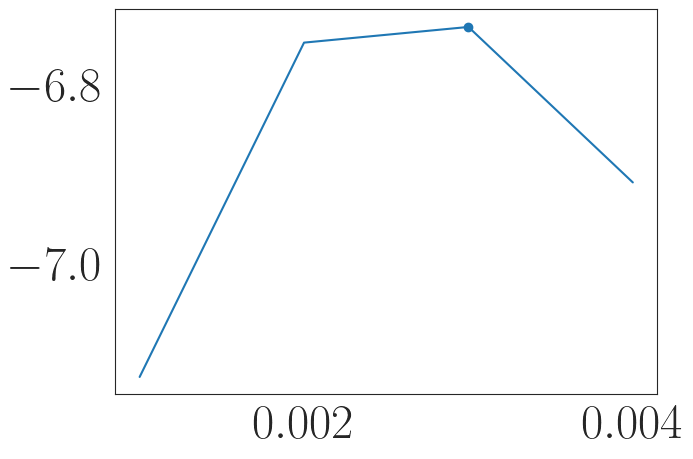

In [27]:
x = [0.001,0.002,0.003,0.004]
y = slopes[-1]

slope_interp = lambda xn: np.interp(xn,x,y)
plt.plot(x,y)

plt.scatter(0.003, slope_interp(0.003))

#### **TRGB Color**

In [22]:
trgb_mags_K = trgb_f200w_mag

Number of objects in the selected region: 5697


/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(1.2, 1.6)

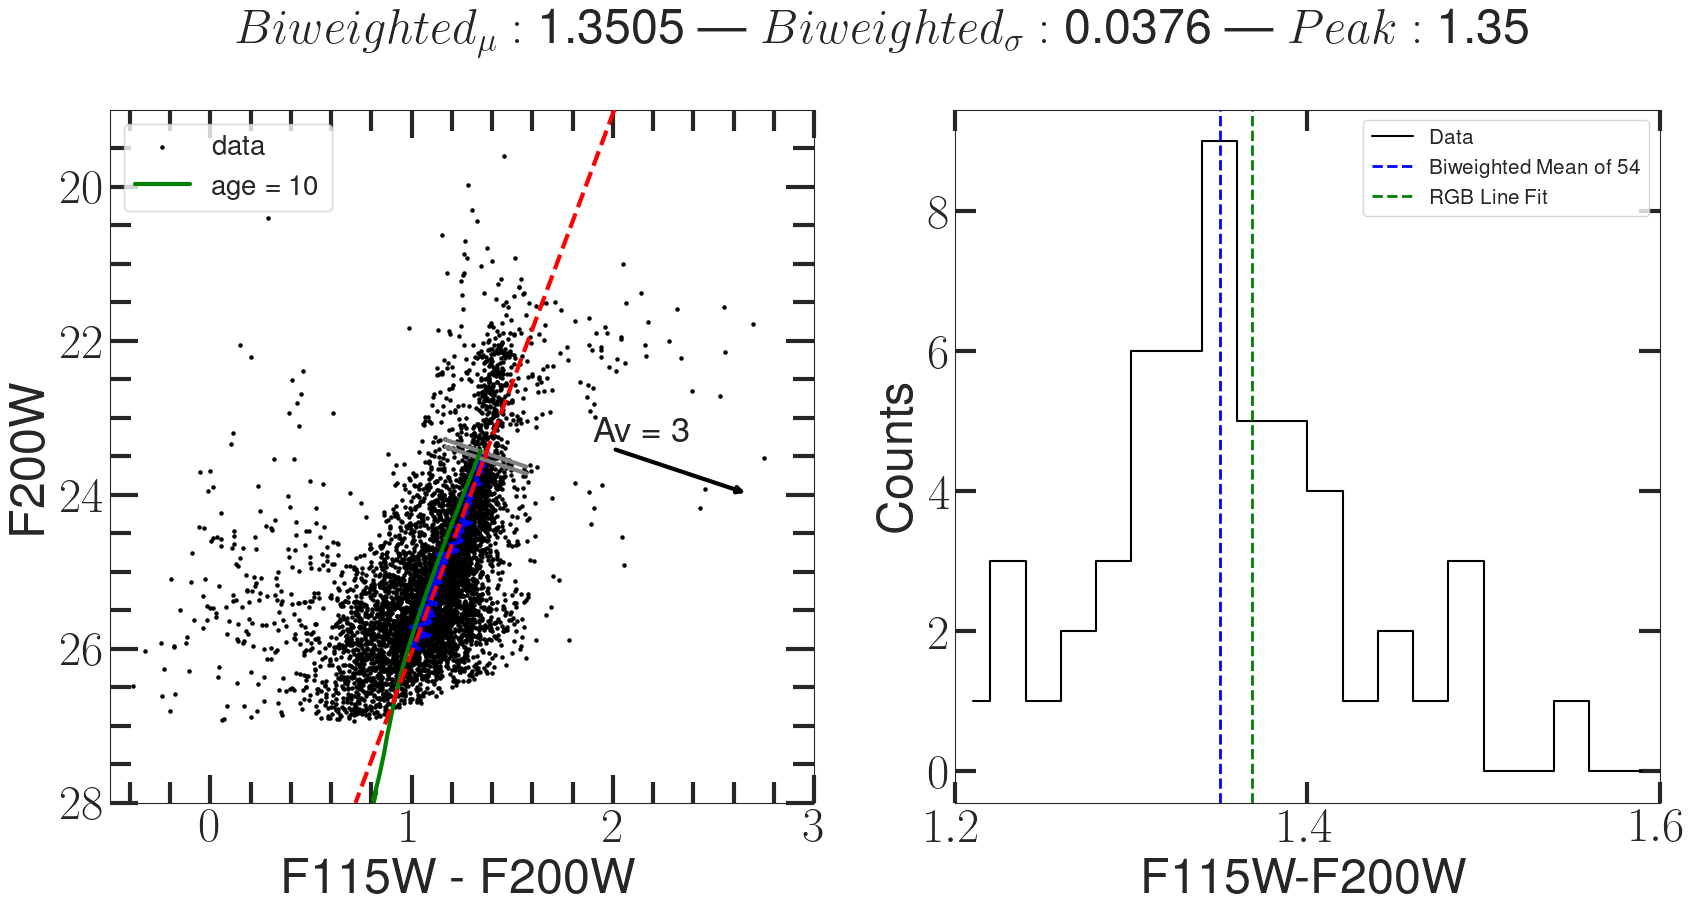

In [85]:
filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

dy= 0.08
cmd_xlo = 1.2
cmd_xhi = 1.6

r_in  = 0
r_out = 24
dats  = []
nx    = 15
ny    = 6
trgb_cols = np.zeros((nx,ny,9))*np.nan
i,j   = 0,0
min_  = cmd_xlo
max_  = cmd_xhi
step  = 0.02

bins  = np.arange(min_, max_, step)

tab   = Table.read('../photometry/ngc628/f115w_f200w.fits')


m     = trgb_f200w_mag[0,0]

y_lo  = m - 0.01
y_hi  = m + 0.071
dats  = []
fig, ax = plt.subplots(1,2,figsize=(20, 9))


k=0
ra_cen  = regions_dict[f'reg_{k}']['ra']
dec_cen = regions_dict[f'reg_{k}']['dec']

#ra_cen  = regions_dict[f'bubble']['ra']
#dec_cen = regions_dict[f'bubble']['dec']
_, _, dats, x_val, y_val, y_bins, model_rgb = gen_CMD_xcut(tab,filt1, filt2,filt3, ra_cen=ra_cen, dec_cen=dec_cen,
                                               cmd=df_cmd_jwst, label_min=0, label_max=3,Av=0.19, sqr_field=True,
                                               r_in=r_in, r_out=r_out, age=10, met=0.002,Av_y=23.4, Av_x=2,
                                               y_lo=y_lo, y_hi=y_hi,dismod=29.742,xlims=[-0.5,3], ylims=[19,28],
                                               dy=dy, dx=cmd_xhi-cmd_xlo,
                                               cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi, rgb_ylo=m, rgb_yhi=26,          
                                               fit_isochrone=False,fig=fig, ax=ax[0],s=5)
#plt.close(fig)
ax[0].tick_params(which='both', length=20,direction="in", bottom=True, top=True,left=True, right=True)
ax[0].tick_params(which='minor', length=15)

dat = dats[0][0]

y, x = np.histogram(dat, bins=bins)

max_bub = y.max()

x = 0.5*(x[1:] + x[:-1])

ax[1].step(x,y, where='mid', color='black')

mean, median, stddev= sigma_clipped_stats(dat, sigma=2, cenfunc=biweight_location, stdfunc=biweight_scale, maxiters=10)

p = x[y==y.max()][0]
x_p1 = mean
s_p1 = stddev

ax[1].axvline(x_p1, linestyle = '--', color='blue', lw=2)
ax[1].axvline(model_rgb(m), linestyle = '--', color='green', lw=2)

title = ''
title += r"$Biweighted_{\mu}:$ " + f"{np.round(x_p1,4)} | "
title += r'$Biweighted_{\sigma}:$ ' + f"{np.round(s_p1,4)}"
title += r' | $Peak :$' + f' {np.round(p,4)}\n'

ax[1].set_title(title, fontsize=35,x=-0.1)
ax[1].set_ylabel('Counts', fontsize=35)

ax[1].set_xlabel(f'{filt1.upper()}-{filt2.upper()}')

init = models.Gaussian1D()
fit = fitting.LevMarLSQFitter()
ridge = []
ridge_std = []
for dat in dats:
    data = dat[0]
    bins = np.arange(data.min(), data.max(), 0.02)
    y,x = np.histogram(data,bins=bins)
    x = 0.5*(x[1:] + x[:-1])
    
    model = fit(init,x,y)
    ridge.append(model.mean.value)
    ridge_std.append(model.stddev.value)

init = models.Linear1D()
fit = fitting.LinearLSQFitter()
model_ridge = fit(init, y_val,ridge)
#ax[1].axvline(model_ridge(m), linestyle = '--', color='orange', lw=2)

trgb_cols[i,j,0] = p   # Peak
trgb_cols[i,j,1] = mean # Bi weighted mean
trgb_cols[i,j,2] = np.mean(dat) # Mean color
trgb_cols[i,j,3] = median # Bi weighted median

trgb_cols[i,j,4] = model_ridge(m) # Gaussian Mean
trgb_cols[i,j,5] = np.median(ridge_std)
trgb_cols[i,j,6] = len(dat)
trgb_cols[i,j,7] = model_rgb(m)
trgb_cols[i,j,8] = model_rgb.slope.value

ax[1].legend(['Data',f'Biweighted Mean of {len(dats[0][0])}','RGB Line Fit','Ridge Fit'], fontsize=15)
fig.savefig(f"TRGB/reg{k}_color.png")
ax[1].tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True,width=3)
ax[1].tick_params(which='minor', length=8,width=3)
ax[1].set_xlim(cmd_xlo,cmd_xhi)
#plt.close(fig)


In [77]:
m

23.4687

In [102]:
model_rgb(m), model_ridge(m)

(1.3793614283094864, 1.3945420520611416)

In [52]:
model_ridge(m)

1.3759829793960687

In [44]:
model_rgb(m)

1.3684218095336678

In [ ]:
trgb_cols[0,0]

In [488]:
filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

dy= 0.08
cmd_xlo = 1.2
cmd_xhi = 1.6

r_in  = 0
r_out = 24
dats  = []
nx    = 15
ny    = 6
trgb_cols = np.zeros((nx,ny,9))*np.nan
k = 0

min_ = cmd_xlo
max_ = cmd_xhi
step = 0.02

tab = Table.read('../photometry/ngc628/f115w_f200w.fits')
                 
for i in range(nx):
    for j in range(ny):
        m = trgb_mags_K[i,j]
        
        if np.isnan(m):
            print(k)
            k += 1
            continue
            
        y_lo = m - 0.01
        y_hi = m + 0.071
        fig, ax = plt.subplots(1,2,figsize=(20, 9))
        
        if k< 20 or k >80:
            rgb_yhi = 26
        else:
            rgb_yhi = 24.5
            
        ra_cen  = regions_dict[f'reg_{k}']['ra']
        dec_cen = regions_dict[f'reg_{k}']['dec']
        _, _, dats, x_val, y_val, y_bins, model_rgb = gen_CMD_xcut(tab,filt1, filt2,filt3, ra_cen=ra_cen, dec_cen=dec_cen,
                                                       cmd=df_cmd_jwst, label_min=0, label_max=3,Av=0.19, sqr_field=True,
                                                       r_in=r_in, r_out=r_out, age=10, met=0.002,Av_y=23.4, Av_x=2,
                                                       y_lo=y_lo, y_hi=y_hi,dismod=29.742,xlims=[0.,3], ylims=[21,27],
                                                       dy=dy, dx=1,cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi, rgb_ylo=m, rgb_yhi=rgb_yhi,          
                                                       fit_isochrone=False,fig=fig, ax=ax[0])
        #plt.close(fig)
        ax[0].tick_params(which='both', length=20,direction="in", bottom=True, top=True,left=True, right=True)
        ax[0].tick_params(which='minor', length=15)


        dat = dats[0][0]
        if len(dat)<50:
            print(k, len(dat))
        y, x = np.histogram(dat, bins=np.arange(dat.min(), dat.max(), step))
        
        max_bub = y.max()

        x = 0.5*(x[1:] + x[:-1])
        
        ax[1].step(x,y, where='mid', color='black')
       
        mean, median, stddev= sigma_clipped_stats(dat, sigma=2, cenfunc=biweight_location, stdfunc=biweight_scale, maxiters=10)

        p = x[y==y.max()][0]
        x_p1 = mean
        s_p1 = stddev

        ax[1].axvline(x_p1, linestyle = '--', color='blue', lw=2)
        ax[1].axvline(model_rgb(m), linestyle = '--', color='green', lw=2)

        title = ''
        title += r"$Biweighted_{\mu}:$ " + f"{np.round(x_p1,4)} | "
        title += r'$Biweighted_{\sigma}:$ ' + f"{np.round(s_p1,4)}"
        title += r' | $Peak :$' + f' {np.round(p,4)}\n'
        
        ax[1].set_title(title, fontsize=35,x=-0.1)
        ax[1].set_ylabel('Counts', fontsize=35)

        ax[1].set_xlabel(f'{filt1.upper()}-{filt2.upper()}')

        trgb_cols[i,j,0] = p   # Peak
        trgb_cols[i,j,1] = mean # Bi weighted mean
        trgb_cols[i,j,2] = np.mean(dats[0][0]) # Mean color
        trgb_cols[i,j,3] = median # Bi weighted median
        
        trgb_cols[i,j,4] = 0#model_ridge(m) # Gaussian Mean
        trgb_cols[i,j,5] = 0#np.median(ridge_std)
        trgb_cols[i,j,6] = len(dats[0][0])
        trgb_cols[i,j,7] = model_rgb(m)
        trgb_cols[i,j,8] = model_rgb.slope.value
                 
        ax[1].legend(['Data',f'Biweighted Mean of {len(dats[0][0])}','RGB Line Fit'], fontsize=15)
        fig.savefig(f"TRGB/reg{k}_color.png")
        ax[1].tick_params(which='both', length=20,direction="in", bottom=True, top=True,left=True, right=True)
        ax[1].tick_params(which='minor', length=15)
        plt.close(fig)
        k+=1
        break
    break
print("Completed!")

Number of objects in the selected region: 5697


/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Completed!


In [417]:
np.save('TRGB/trgb_cols_JK.npy', trgb_cols)

In [418]:
i,j

(14, 5)

In [21]:
bubble_col = np.array([1.35500000e+00, 1.37743939e+00, 1.36598795e+00, 1.37500000e+00,
       1.37825104e+00, 6.19607834e-02, 8.30000000e+01])

bubble_col = np.array([1.39500000e+00,  1.39455172e+00,  1.39547222e+00,  1.39950000e+00,
        1.39454205,  3.73641715e-02,  7.20000000e+01,  1.39018819e+00,
       -9.82882283e-02])

In [22]:
trgb_cols = np.load('TRGB/trgb_cols_JK.npy')

Text(0, 0.5, 'y')

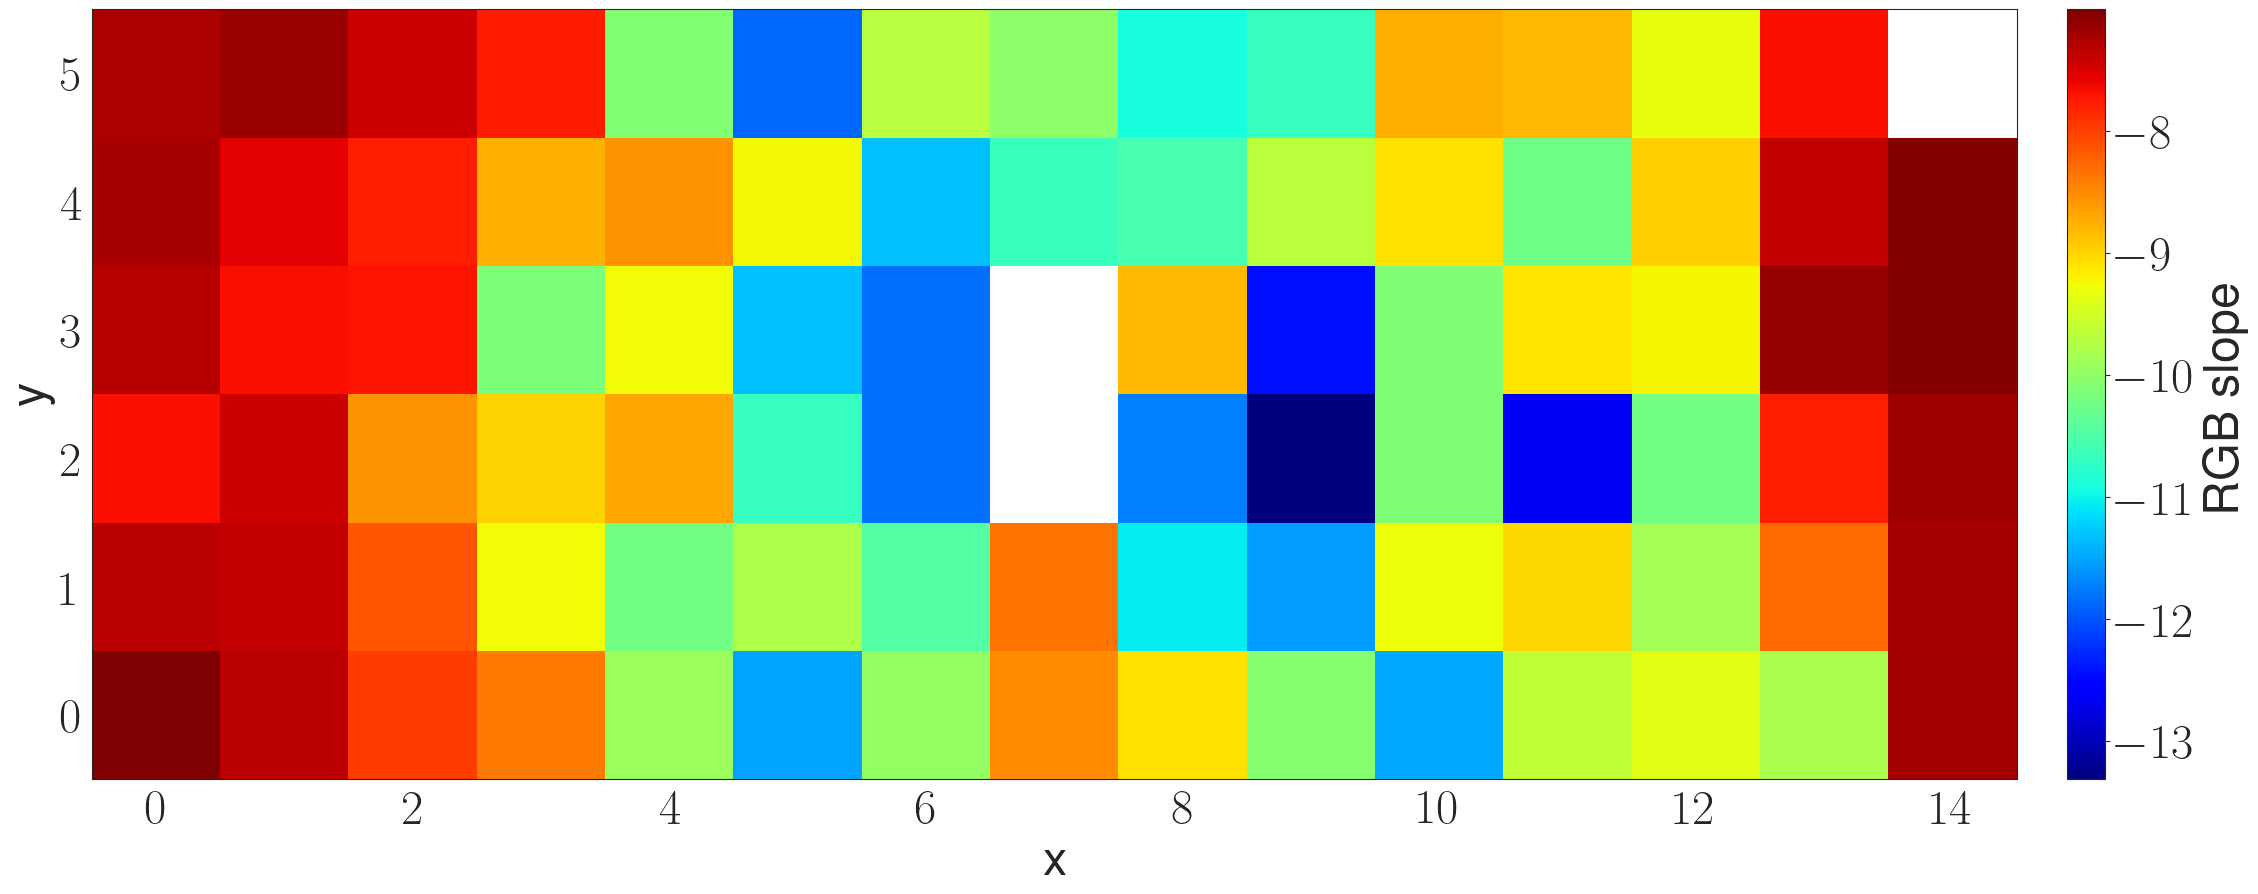

In [23]:
plt.figure(figsize=(32,10))
img = plt.imshow(1/trgb_cols.T[8], cmap='jet')
cb = plt.colorbar(img, pad=0.02)
cb.set_label('RGB slope')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

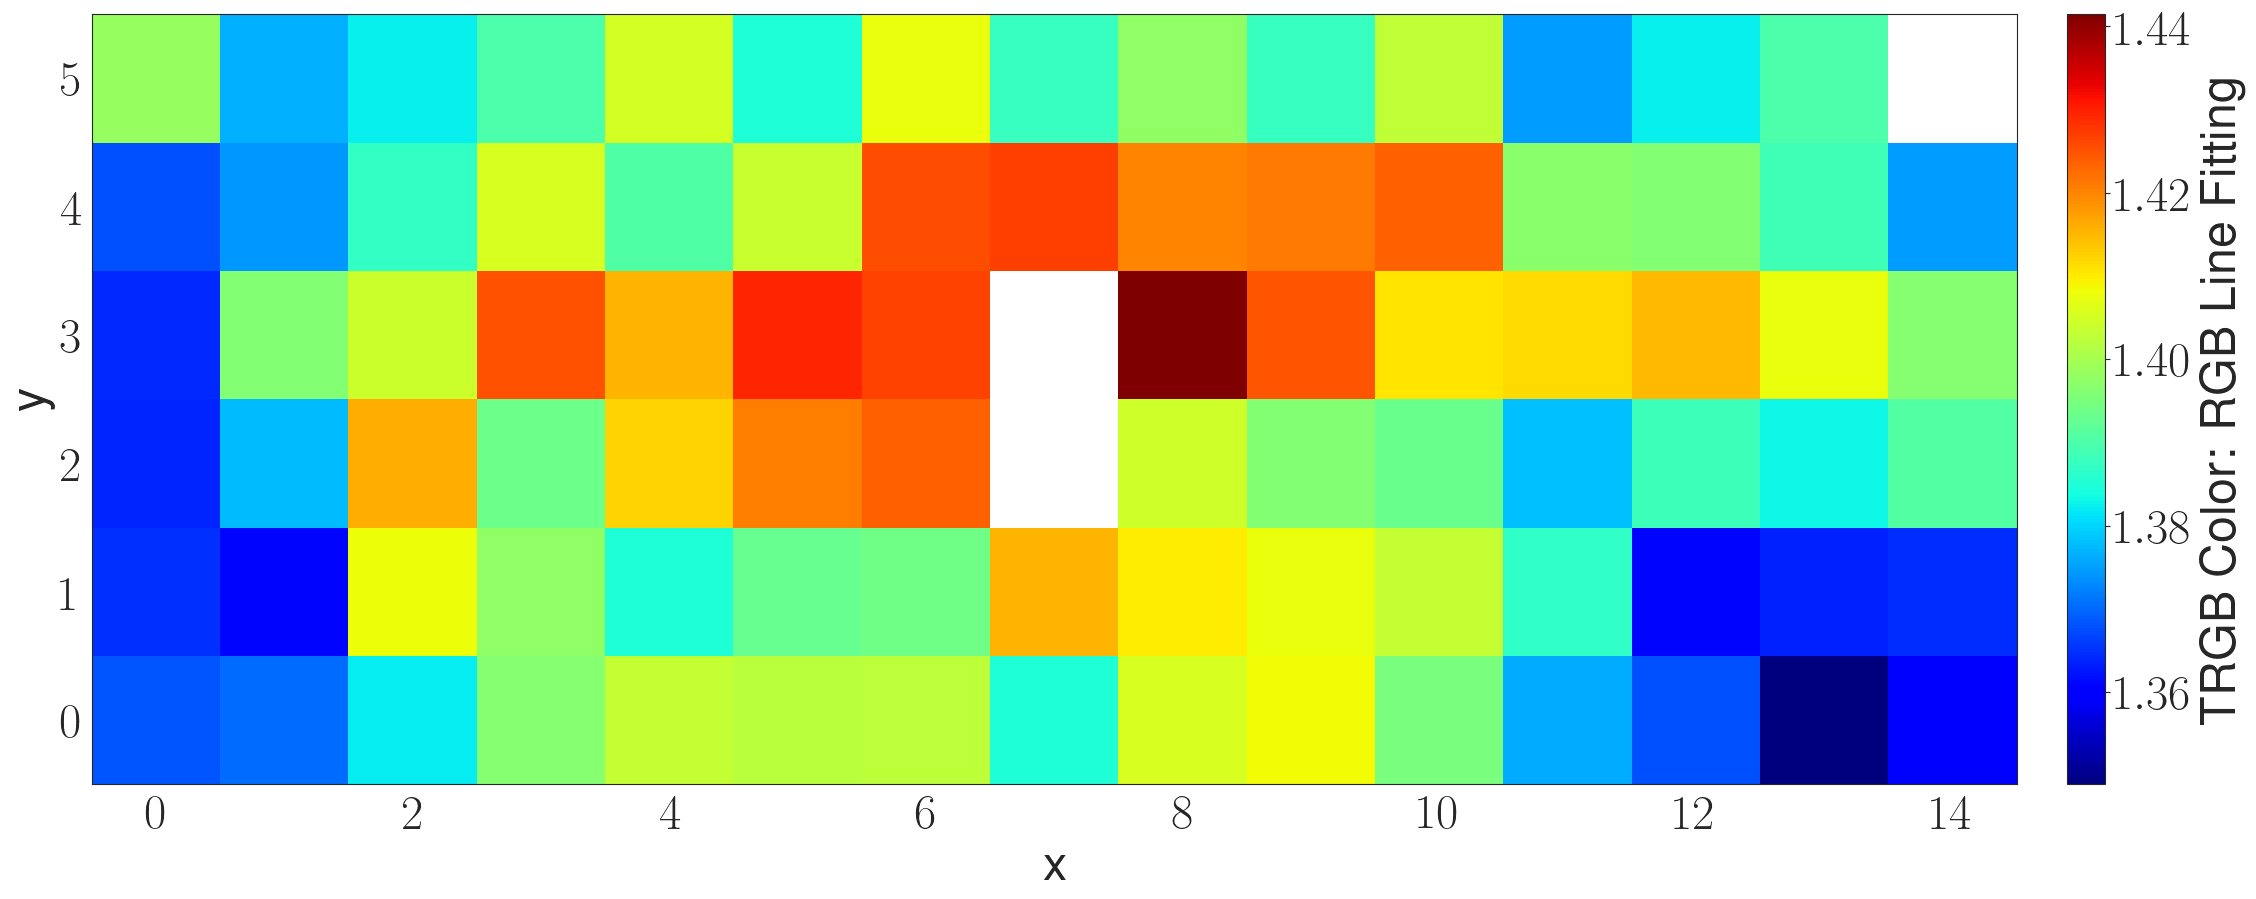

In [25]:
plt.figure(figsize=(32,10))
img = plt.imshow(trgb_cols.T[7], cmap='jet')
cb = plt.colorbar(img, pad=0.02)
cb.set_label('TRGB Color: RGB Line Fitting')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

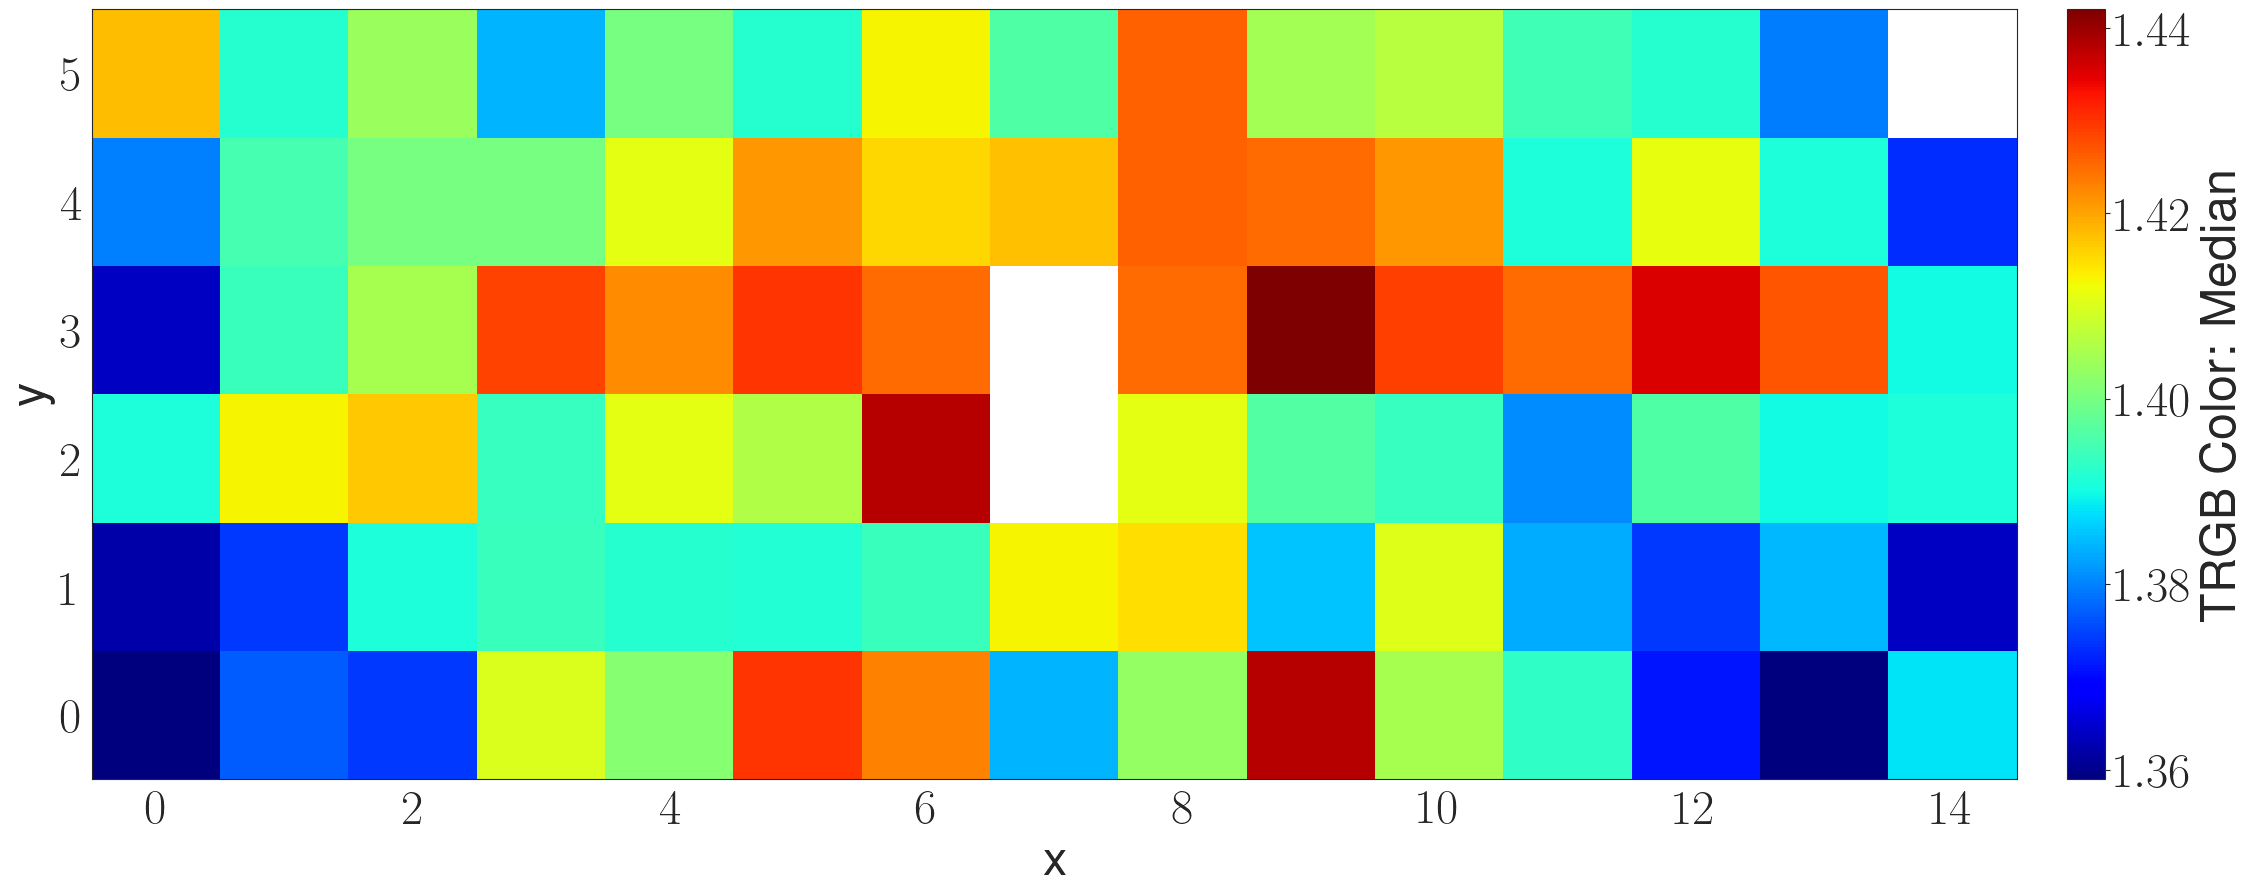

In [26]:
plt.figure(figsize=(32,10))
img = plt.imshow(trgb_cols.T[3], cmap='jet')
cb = plt.colorbar(img, pad=0.02)
cb.set_label('TRGB Color: Median')
plt.xlabel('x')
plt.ylabel('y')

In [24]:
Av = 0.19
ind = -1
y_r = mags_f200w[ind] + Av_dict['f200w']*Av
x_r = mags_f115w[ind] + Av_dict['f115w']*Av - (mags_f200w[ind] +  Av_dict['f200w']*Av)

x_10 = np.arange(1.3,1.5,0.001)
y_10 = np.interp(x_10,x_r,y_r)
met_10 = np.interp(x_10,x_r, [0.001,0.002,0.003,0.004])

x_c = bubble_col[7] 
y_c = bubble_f200w
d = np.arange(29,30,0.0001).reshape(-1,1)
 
r = np.sqrt( (x_10 - x_c)**2 + (y_10 + d - y_c)**2)

dismod = d[np.argwhere(r==r.min())[0][0]][0]
met = met_10[np.argwhere(r==r.min())[0][1]]

In [25]:
np.round(dismod,4), np.round(met,4)

(29.741, 0.0028)

In [26]:
dismods = []
mets = []
for i in [bubble_f200w_err, -bubble_f200w_err]:
    for j in [model_col_err(bubble_f200w), -model_col_err(bubble_f200w)]:
        Av = 0.19
        ind = -1
        y_r = mags_f200w[ind] + Av_dict['f200w']*Av
        x_r = mags_f115w[ind] + Av_dict['f115w']*Av - (mags_f200w[ind] +  Av_dict['f200w']*Av)

        x_10 = np.arange(1.3,1.5,0.001)
        y_10 = np.interp(x_10,x_r,y_r)
        met_10 = np.interp(x_10,x_r, [0.001,0.002,0.003,0.004])

        x_c = bubble_col[7] + j
        y_c = bubble_f200w + i
        d = np.arange(29,30,0.0001).reshape(-1,1)

        r = np.sqrt( (x_10 - x_c)**2 + (y_10 + d - y_c)**2)

        dismod = d[np.argwhere(r==r.min())[0][0]][0]
        met = met_10[np.argwhere(r==r.min())[0][1]]
        
        dismods.append(dismod)
        mets.append(met)

In [27]:
np.round(np.mean(dismods),4), np.round(np.mean(mets),4)

(29.7416, 0.0028)

In [28]:
np.round(np.std(dismods),4), np.round(np.std(mets),4)

(0.0445, 0.0003)

In [29]:
yy, xx = np.mgrid[0:5,0:15]

In [33]:
z = (xx-7)**2 + (yy-2)**2

In [30]:
nx = 15
ny = 6

k=0
reg_arr = np.zeros_like(trgb_mags_J[:,:])
for i in range(nx):
    for j in range(ny):
        reg_arr[i,j]=k
        k+=1

In [60]:
x, y = np.mgrid[0:15,0:6]/1.0
x -= 7
y-= 2.5
x *= 24
y *= 24

r = np.sqrt(x**2 + y**2)

r = np.where(x<0,r,r)*43/1e3

(23.72, 23.2)

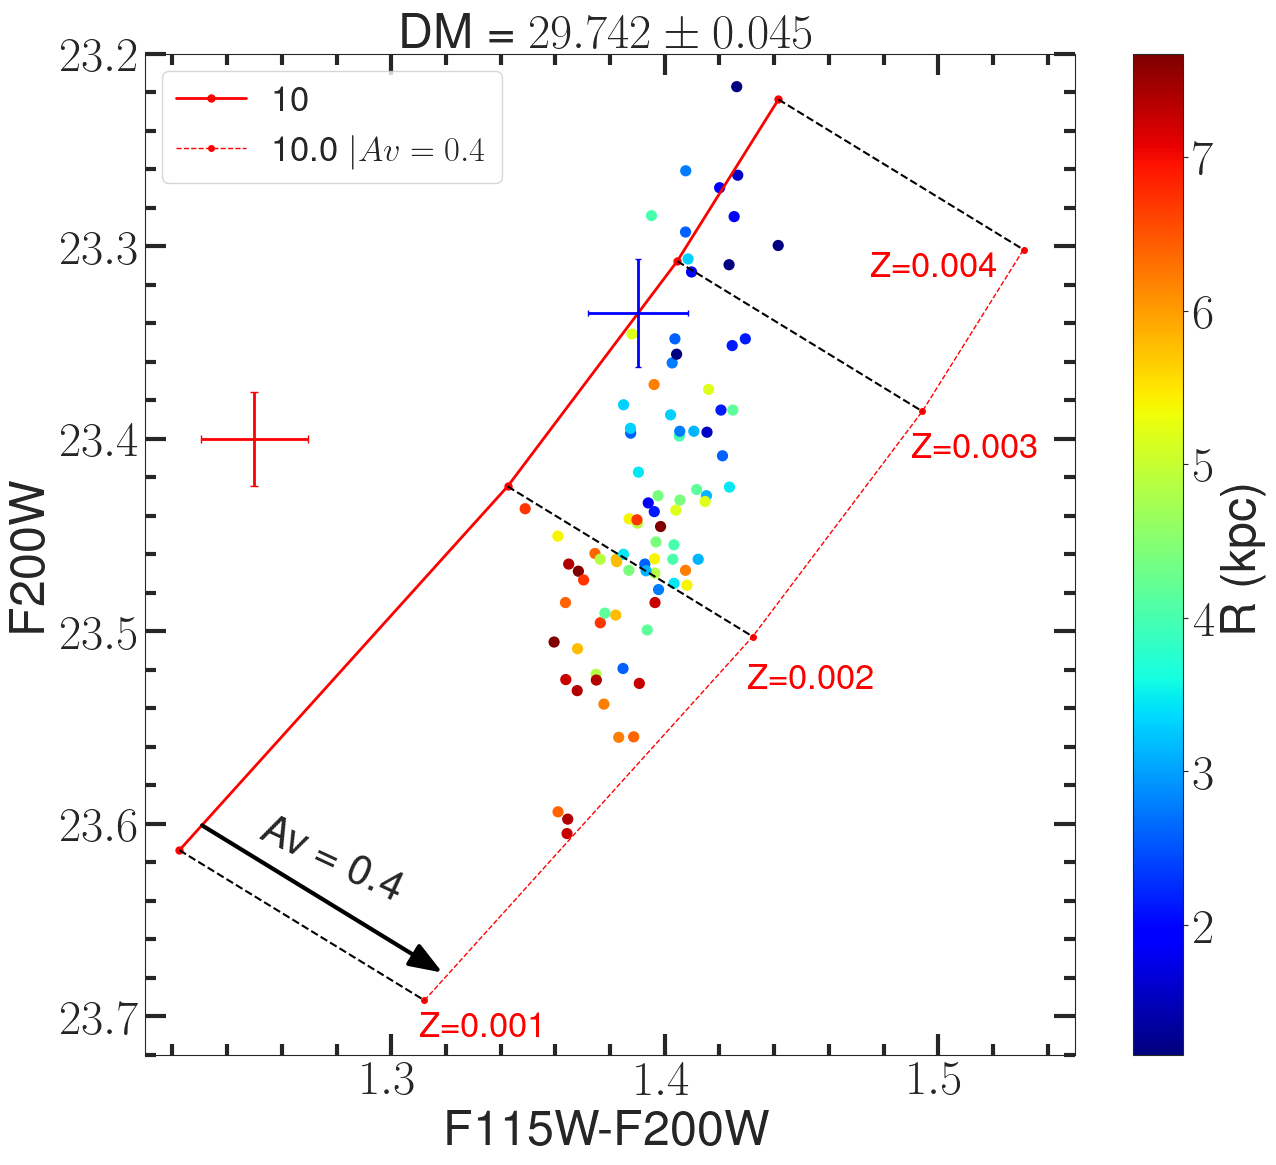

In [61]:
fig, ax = plt.subplots(figsize=(15,13))

dismod = 29.7416
Av = 0.19

Av_t = 0.0

x = (mags_f115w[-1] + Av_dict['f115w']*(Av+Av_t)) - (mags_f200w[-1] + Av_dict['f200w']*(Av+Av_t))
y = mags_f200w[-1] + Av_dict['f200w']*(Av+Av_t) + dismod


x1 = x
y1 = y
ax.plot(x,y, '-ro',
       linewidth=2, markersize=5)

Av_t = 0.4

x = (mags_f115w.T + Av_dict['f115w']*(Av+Av_t)) - (mags_f200w.T + Av_dict['f200w']*(Av+Av_t))
y = mags_f200w.T + Av_dict['f200w']*(Av+Av_t) + dismod

ax.plot(x[:,-1],y[:,-1], '--ro',
       linewidth=1, markersize=4, )
x2 = x[:,-1]
y2 = y[:,-1]

x_n = np.concatenate([[x1],[x2]])
y_n = np.concatenate([[y1],[y2]])

ax.plot(x_n,y_n,'--k')

Av_t = 0.
x = (mags_f115w.T + Av_dict['f115w']*(Av+Av_t)) - (mags_f200w.T + Av_dict['f200w']*(Av+Av_t))
y = mags_f200w.T + Av_dict['f200w']*(Av+Av_t) + dismod


#ax.plot(x.T,y.T, '--k',linewidth=1)

start = 0
end = 89
    
x = trgb_cols[:,:,7].ravel()[start:end+1]
y = trgb_f200w_mag[:,:].ravel()[start:end+1]
    
xerr = model_col_err(trgb_f200w_mag[:,:].ravel()[start:end+1])
yerr = trgb_f200w_err[:,:].ravel()[start:end+1]

xerr, yerr = np.nanmean(xerr), np.nanmean(yerr)
img = ax.scatter(x,y,c=r, s=50,cmap='jet')
  
ax.errorbar([1.25],[23.4],xerr=xerr, yerr=yerr, fmt='.r',elinewidth=2,
           markersize=3, capsize=3)
            
#img = ax.errorbar(x,y,xerr=xerr, yerr=yerr, fmt='.k',elinewidth=0.5,
#            markersize=0.5, capsize=2, zorder=100)

#img = ax.scatter(x,y,marker='o',
#            s=0.5, zorder=100)

ax.invert_yaxis()
cb = plt.colorbar(img,ax=ax)

cb.set_label('R (kpc)')
#ax.invert_xaxis()

Av_x = 1.23
Av_y = 23.60

Av_ = 0.4

AF1_ =  Av_dict['f115w']*Av_
AF2_ =  Av_dict['f200w']*Av_

dx = AF1_
dy = AF2_

dx = dx-dy
ax.annotate('', xy=(Av_x, Av_y),
             xycoords='data',
             xytext=(Av_x+dx, Av_y+dy),
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-, head_width = .75, head_length=2',
                             color='black',
                             lw=3,
                             ls='-',
                             )
           )

ax.annotate(f'Av = {Av_}', xy=(Av_x+0.02, Av_y+0.04),
             xycoords='data',
             #xytext=(Av_x+dx, Av_y+dy),
             textcoords='data', rotation=-25, fontsize=30
           )
"""
for n,i,j in zip(reg_arr.ravel().astype(int)[start:end+1],x,y):
    if n in [7]:
        j-=0.02
    if n in [0,6, 71, 82]:
        i-=0.0025
        
    if n in [14, 79, 32, 72,74]:
        i-=0.006
    ax.annotate(f'{n}', xy=(i- 0.001, j+0.015), 
             xycoords='data', fontsize=20, color = 'black', zorder= 100,
           )
"""
x = bubble_col[7]
y = bubble_f200w

xerr = model_col_err(bubble_f200w)
yerr = bubble_f200w_err
ax.errorbar([x],[y],xerr=xerr,yerr=yerr, fmt='.b',elinewidth=2,
            markersize=3, capsize=2)

Av = 0.19
r_ind = -1
y_r = mags_f200w[r_ind] + Av_dict['f200w']*Av + dismod
x_r = mags_f115w[r_ind] + Av_dict['f115w']*Av - (mags_f200w[r_ind] +  Av_dict['f200w']*Av)

#ax.plot(x_r, y_r,'--k',)
ax.set_xlabel('F115W-F200W')
ax.set_ylabel('F200W')
ax.set_title('DM = $' + f'{np.round(dismod,3)} ' + r'\pm 0.045$')
ax.legend(['10',r'10.0 $| Av=0.4$'], fontsize=25)

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True, width=3)
ax.tick_params(which='minor', length=8, width=3)

ax.annotate('Z=0.001',(1.34-0.03,23.685+0.025), color='red', fontsize=25)
ax.annotate('Z=0.002',(1.46-0.03,23.5+0.029), color='red', fontsize=25)
ax.annotate('Z=0.003',(1.52-0.03,23.38+0.029), color='red', fontsize=25)
ax.annotate('Z=0.004',(1.56-0.085,23.295+0.02), color='red', fontsize=25)
ax.set_xlim(1.21,1.55)
ax.set_ylim(23.72,23.2)

In [33]:
dmpc = np.round(10*10**(dismod/5)/1e6,3)
dmpc

8.878

In [34]:
np.round(np.std([10*10**((dismod-0.0445)/5)/1e6,10*10**((dismod+0.0445)/5)/1e6]),4)

0.182

In [35]:
k = 0
nx = 15
ny = 6
Av_map = np.zeros((nx,ny))*np.nan
met_map = np.zeros((nx,ny))*np.nan

for i in range(15):
    for j in range(6):

        Av = 0.19
        ind_ = -1
        y_r = mags_f200w[ind_] + Av_dict['f200w']*Av + dismod
        x_r = mags_f115w[ind_] + Av_dict['f115w']*Av - (mags_f200w[ind_] +  Av_dict['f200w']*Av)

        x_10 = np.arange(1.2,1.5,0.001)
        y_10 = np.interp(x_10,x_r,y_r)
        met_10 = np.interp(x_10,x_r, [0.001,0.002,0.003,0.004])

        ind = k

        x_c = trgb_cols[:,:,7].ravel()[ind]
        y_c = trgb_mags_K[:,:].ravel()[ind]
        
        if np.isnan(x_c) or np.isnan(y_c) :
            k+=1
            continue

        Av_ = np.arange(-1,0.7, 0.001).reshape(-1,1)

        dx = (Av_dict['f115w']-Av_dict['f200w'])*Av_
        dy = Av_dict['f200w']*Av_

        r = np.sqrt( (x_10 - (x_c-dx))**2 + (y_10 - (y_c-dy))**2)

        av1, z1 = Av_[np.argwhere(r==r.min())[0][0]][0], met_10[np.argwhere(r==r.min())[0][1]]
        
        Av_map[i, j] = av1
        met_map[i, j] = z1
        
        k+=1

In [36]:
errs = np.array([[model_col_err(bubble_f200w), bubble_f200w_err],
                 [model_col_err(bubble_f200w), -bubble_f200w_err],
                 [-model_col_err(bubble_f200w), bubble_f200w_err],
                 [-model_col_err(bubble_f200w), -bubble_f200w_err]])

In [37]:
avs = []
zs = []
for i,j in errs:
    Av = 0.19
    ind_ = -1
    y_r = mags_f200w[ind_] + Av_dict['f200w']*Av + dismod
    x_r = mags_f115w[ind_] + Av_dict['f115w']*Av - (mags_f200w[ind_] +  Av_dict['f200w']*Av)

    x_10 = np.arange(1.2,1.5,0.001)
    y_10 = np.interp(x_10,x_r,y_r)
    met_10 = np.interp(x_10,x_r, [0.001,0.002,0.003,0.004])


    x_c = bubble_col[7] + i
    y_c = bubble_f200w + j

    Av_ = np.arange(-1,0.7, 0.001).reshape(-1,1)

    dx = (Av_dict['f115w']-Av_dict['f200w'])*Av_
    dy = Av_dict['f200w']*Av_

    r = np.sqrt( (x_10 - (x_c-dx))**2 + (y_10 - (y_c-dy))**2)

    av1, z1 = Av_[np.argwhere(r==r.min())[0][0]][0], met_10[np.argwhere(r==r.min())[0][1]]

    avs.append(av1)
    zs.append(z1)

In [38]:
np.save('../data/Av_map.npy',Av_map)

In [40]:
np.round(np.std(avs),4), np.round(np.std(zs),4)

(0.0719, 0.0002)

In [41]:
np.nanmin(Av_map)

-0.06499999999999917

In [42]:
mask = np.where(Av_map<-0.06,np.nan,1)

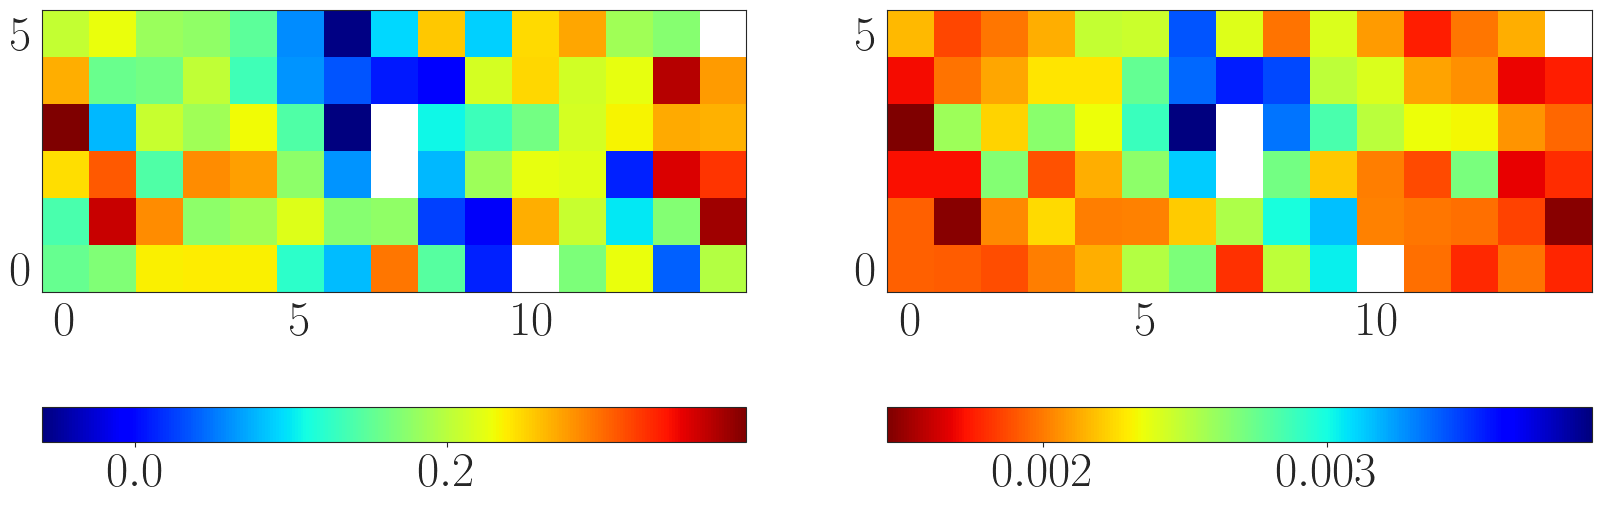

In [46]:
fig, ax = plt.subplots(1,2, figsize=(20,10))

img = ax[0].imshow(Av_map.T*mask.T, cmap='jet')
plt.colorbar(img,ax=ax[0], orientation='horizontal')
img= ax[1].imshow(met_map.T*mask.T, cmap='jet_r')
plt.colorbar(img,ax=ax[1], orientation='horizontal')

In [47]:
x, y = np.mgrid[0:15,0:6]/1.0
x -= 7
y-= 2.5
x *= 24
y *= 24

r = np.sqrt(x**2 + y**2)

In [48]:
@custom_model

def exp1d(x,x0=0,tau=1,A=1,B=0.):
    return A*np.exp(-(x+x0)/tau) + B

In [49]:
@custom_model

def log1d(y,x0=0,tau=1,A=1,B=0.):
    return -(x0 + tau*np.log((y-B)/A))

In [50]:
df = pd.read_csv('../data/Z_5Gyr.csv', header=None)

/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


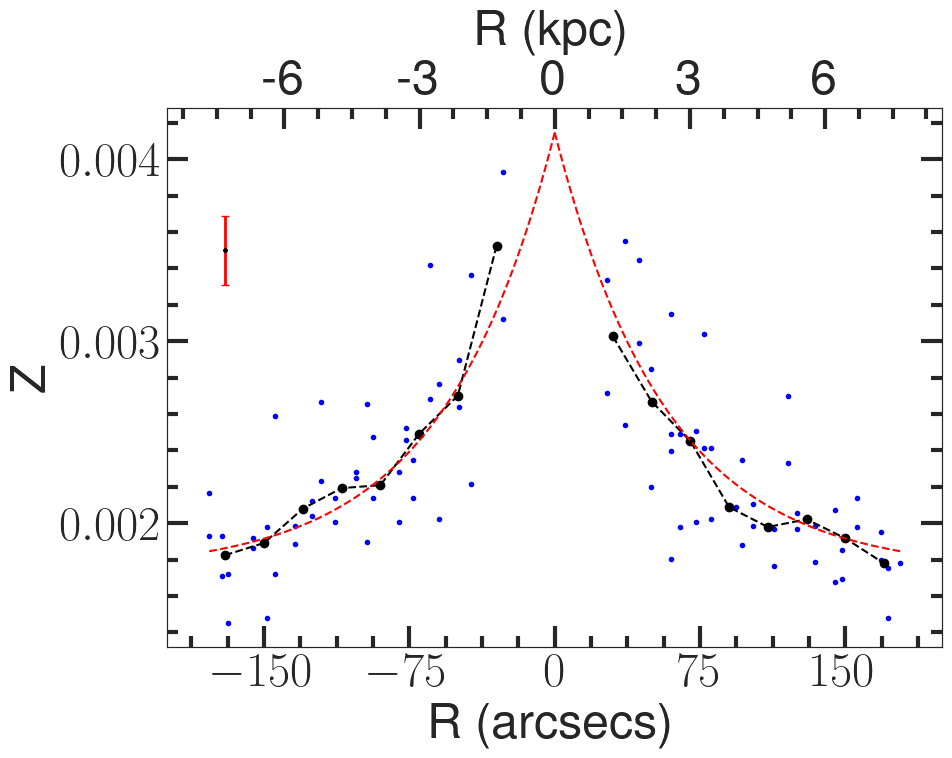

In [51]:
fig , ax = plt.subplots(figsize=(10,7), sharex=True)
# Total

x = r.ravel()
y = (met_map*mask).ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model = fit(init,abs(x),y)

# Left
x = r[:7].ravel()
y = (met_map*mask)[:7].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(-x,y, marker='.', color='blue')
ax.plot(-x_c,y_c, '--ok')
x_new = np.linspace(0,x.max(),1000)

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model1 = fit(init,x,y)

ax.plot(-x_new, model(x_new),'--r')

#Right
x = r[7:].ravel()
y = (met_map*mask)[7:].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(x,y, marker='.', color='blue')
ax.plot(x_c,y_c, '--ok')

x_new = np.linspace(0,x.max(),1000)

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model2 = fit(init,x,y)

ax.plot(x_new, model(x_new),'--r')

ax.set_ylabel('Z')
ax.errorbar(x=[-170],y=[0.0035],xerr=0,yerr=0.00019, fmt='.r',elinewidth=2,
            markersize=5, capsize=3, markerfacecolor='black', markeredgecolor='black')

ax.set_xlim(-200,200)

ax.set_xticks([-150,-75,0,75,150])

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True,left=True, right=True, top=True, width=3)
ax.tick_params(which='minor', length=8, width=3)


ax1 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1

xticks_n = np.array([-6,-3,0,3,6])
xticks = xticks_n*1e3/43

ax1.set_xticks(xticks, xticks_n)

ax1.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])

ax1.yaxis.set_major_locator(AutoLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.tick_params(which='both', length=15,direction="in",top=True, width=3)
ax1.tick_params(which='minor', length=8, width=3)

ax.set_xlabel('R (arcsecs)')
ax.minorticks_on()
ax1.minorticks_on()

In [53]:
x = r.ravel()
y = (met_map*mask).ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

taus = []
for i in range(10000):
    y_ = np.random.normal(loc=y,scale=0.00019)
    init = exp1d(tau=10)
    fit = fitting.LevMarLSQFitter()
    model = fit(init,abs(x),y_)
    
    taus.append(model.tau.value)


KeyboardInterrupt



In [ ]:
np.median(taus)

In [ ]:
np.std(taus)

In [54]:
8.878e6*np.tan(np.deg2rad(73/3600))

3142.048509635915

In [55]:
8.878e6*np.tan(np.deg2rad(10.982/3600))

472.6845934896357

In [56]:
model

<exp1d(x0=37.81160526, tau=73.74307903, A=0.00366383, B=0.00163517)>

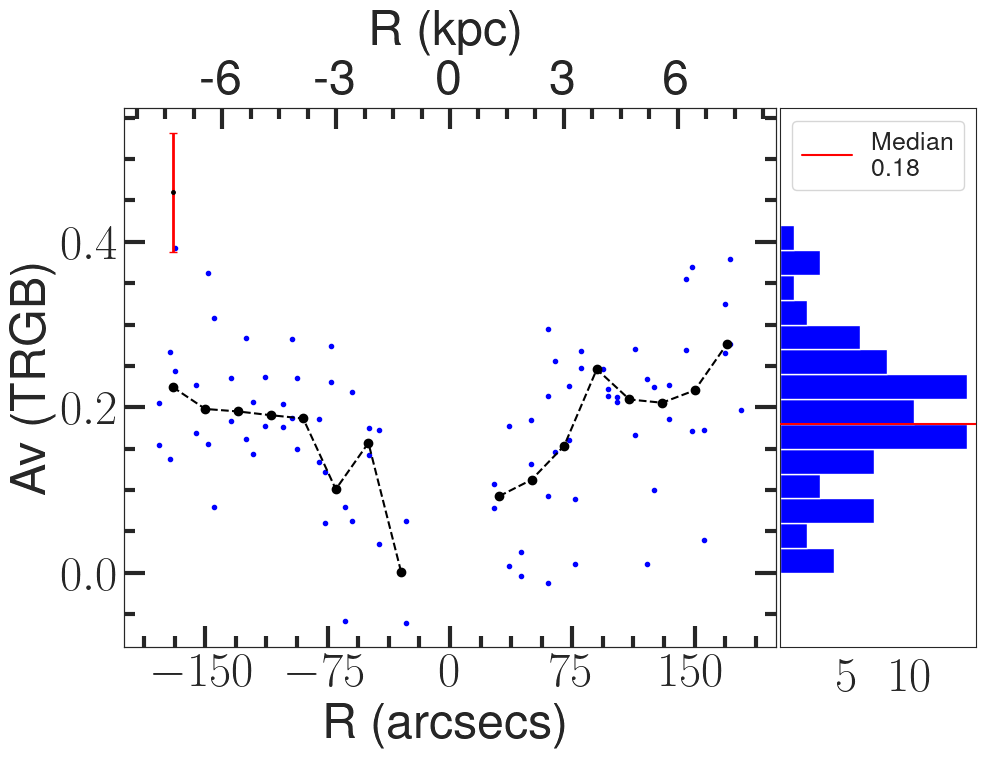

In [53]:
fig , ax_ = plt.subplots(1,2, figsize=(11,7), sharey=True, width_ratios=[1,0.3])
ax = ax_[0]

x = r[:7].ravel()
y = (Av_map*mask)[:7].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(-x,y, marker='.', color='blue')
ax.plot(-x_c,y_c, '--ok')

#Right
x = r[7:].ravel()
y = (Av_map*mask)[7:].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(x,y, marker='.', color='blue')
ax.plot(x_c,y_c, '--ok')


ax.errorbar(x=[-170],y=[0.46],xerr=0,yerr=0.0719, fmt='.r',elinewidth=2,
            markersize=5, capsize=3, markerfacecolor='black', markeredgecolor='black')

ax.set_xlabel('R (arcsecs)')
ax.set_ylabel('Av (TRGB)')
ax.set_xlim(-200,200)

ax.set_xticks([-150,-75,0,75,150])
ax1 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax1.minorticks_on()
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1

xticks_n = np.array([-6,-3,0,3,6])
xticks = xticks_n*1e3/43

ax1.set_xticks(xticks, xticks_n)


ax1.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True,left=True, right=True, width=3)
ax.tick_params(which='minor', length=8, width=3)
ax.minorticks_on()

ax1.yaxis.set_major_locator(AutoLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.tick_params(which='both', length=15,direction="in",top=True, width=3)
ax1.tick_params(which='minor', length=8, width=3)


data = (Av_map*mask).ravel()
bins = np.arange(0,0.5,0.03)

ax_[1].hist(data,bins=bins, orientation='horizontal', color='blue', label='_nolegend_')

m = np.median(np.where((Av_map>=0),Av_map,0))
ax_[1].axhline(m, zorder=300, color='red')
ax_[1].set_xticks([5,10])
ax_[1].legend([f'Median\n{np.round(m,3)}'], fontsize=18)
plt.subplots_adjust(wspace=0.01)

In [39]:
Av_map_n = np.load('gas_phase_Av.npy')
Av_map_std = np.load('gas_phase_Av_std.npy')

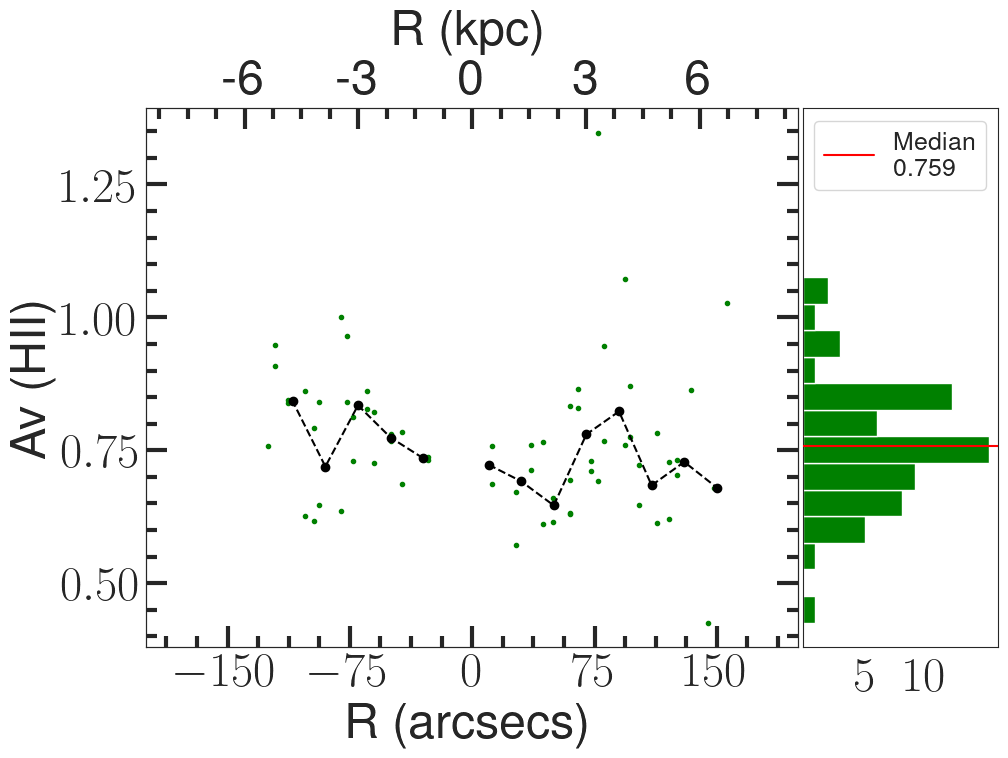

In [56]:
fig , ax_ = plt.subplots(1,2, figsize=(11,7), sharey=True, width_ratios=[1,0.3])
ax = ax_[0]

x = r[:7].ravel()
y = (Av_map_n)[:7].ravel()
ind = ~np.isnan(y)

m = np.nanmedian(Av_map_n)
x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(-x,y, marker='.', color='green')
ax.plot(-x_c,y_c, '--ok')

#Right
x = r[7:].ravel()
y = (Av_map_n)[7:].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(x,y, marker='.', color='green')
ax.plot(x_c,y_c, '--ok')

ax.set_xlabel('R (arcsecs)')
ax.set_ylabel('Av (HII)')
ax.set_xlim(-200,200)

ax.set_xticks([-150,-75,0,75,150])
ax1 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax1.minorticks_on()
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1
xticks_n = np.array([-6,-3,0,3,6])
xticks = xticks_n*1e3/43

ax1.set_xticks(xticks, xticks_n)

ax1.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True,left=True, right=True, width=3)
ax.tick_params(which='minor', length=8, width=3)
ax.minorticks_on()

ax1.yaxis.set_major_locator(AutoLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())

ax1.tick_params(which='both', length=15,direction="in",top=True, width=3)
ax1.tick_params(which='minor', length=8, width=3)


data = (Av_map_n).ravel()
bins = np.arange(np.nanmin(data),np.nanmax(data),0.05)

ax_[1].hist(data,bins=bins, orientation='horizontal', color='green', label='_nolegend_')

ax_[1].set_xticks([5,10])
ax_[1].axhline(m, zorder=300, color='red')
ax_[1].legend([f'Median\n{np.round(m,3)}'], fontsize=18)
plt.subplots_adjust(wspace=0.01)

In [62]:
xticks_n

array([-6., -3.,  0.,  3.,  6.])

In [40]:
Z_gas = np.load('gas_phase_Z.npy')

/tmp/ipykernel_1189/1124862566.py:157: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(-3, 0.03)


(0.0012766419028781713, 0.03)

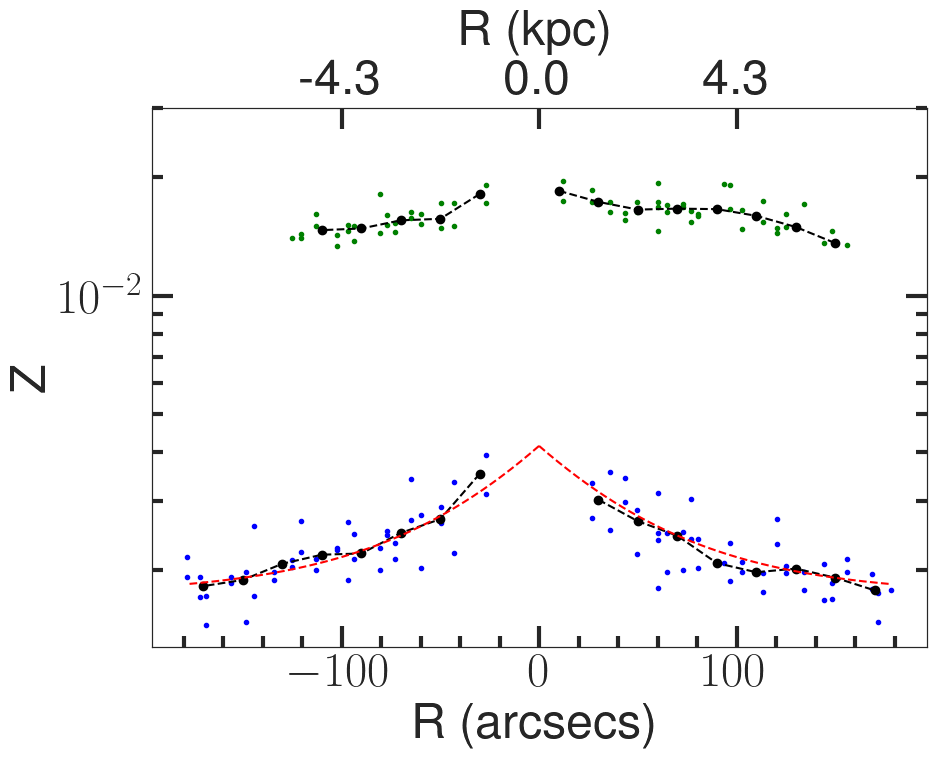

In [61]:
fig , ax = plt.subplots(figsize=(10,7), sharex=True)

x = r.ravel()
y = (met_map*mask).ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model = fit(init,abs(x),y)

# Left
x = r[:7].ravel()
y = (met_map*mask)[:7].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(-x,y, marker='.', color='blue')
ax.plot(-x_c,y_c, '--ok')
x_new = np.linspace(0,x.max(),1000)

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model1 = fit(init,x,y)

ax.plot(-x_new, model(x_new),'--r')

#Right
x = r[7:].ravel()
y = (met_map*mask)[7:].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(x,y, marker='.', color='blue')
ax.plot(x_c,y_c, '--ok')

x_new = np.linspace(0,x.max(),1000)

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model2 = fit(init,x,y)

ax.plot(x_new, model(x_new),'--r')

# Total

x = r.ravel()
y = (Z_gas*mask).ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model = fit(init,abs(x),y)

# Left
x = r[:7].ravel()
y = (Z_gas*mask)[:7].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(-x,y, marker='.', color='green')
ax.plot(-x_c,y_c, '--ok')

#Right
x = r[7:].ravel()
y = (Z_gas*mask)[7:].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(x,y, marker='.', color='green')
ax.plot(x_c,y_c, '--ok')


ax.set_ylabel('Z')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True,left=True, right=True, top=True, width=3)
ax.tick_params(which='minor', length=8, width=3)

ax1 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1
xticks = ax.get_xticks()
xticks_n = xticks

dx = xticks_n - np.floor(xticks_n)

ax1.set_xticks(xticks, np.floor(xticks_n)*43/1e3)

ax1.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])

ax.set_xlabel('R (arcsecs)')

ax1.tick_params(which='both', length=15,direction="in", top=True, width=3)
ax1.tick_params(which='minor', length=8, width=3)

ax.set_yscale('log')
ax.set_ylim(-3, 0.03)

(-10.0, 210.0)

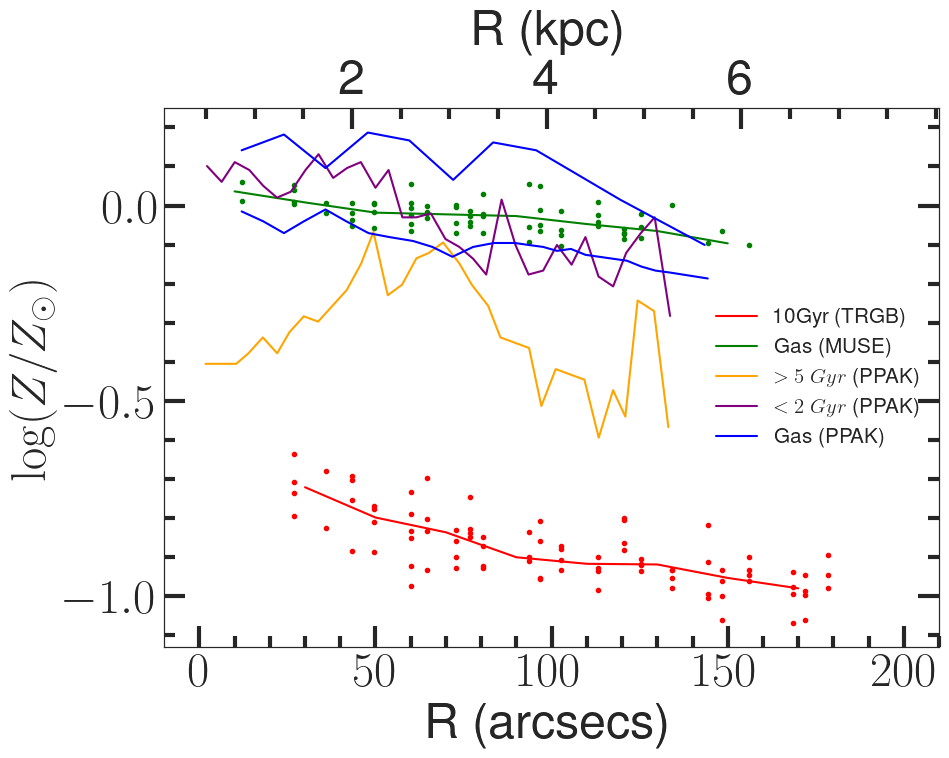

In [147]:
fig , ax = plt.subplots(figsize=(10,7), sharex=True)

# Stellar-Metallicity
x = r.ravel()
y = (met_map*mask).ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model = fit(init,abs(x),y)

ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,200,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)
y_1 = y_c
ax.scatter(x,np.log10(y/0.017), marker='.', color='red', label= '_nolegend_')
ax.plot(x_c,np.log10(y_c/0.017), '-r', label = '10Gyr (TRGB)')
x_new = np.linspace(0,x.max(),1000)


# Gas-Phase Extinction
x = r.ravel()
y = (Z_gas*mask).ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,200,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

y_2 = y_c
ax.scatter(x,np.log10(y/0.017), marker='.', color='green', label= '_nolegend_')
ax.plot(x_c,np.log10(y_c/0.017), '-g', label= 'Gas (MUSE)')

ax.set_ylabel(r'$\log(Z/Z_{\odot})$')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True,left=True, right=True, top=True, width=3)
ax.tick_params(which='minor', length=8, width=3)

ax1 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1
xticks_n = np.array([2,4,6])
xticks = xticks_n*1e3/43

ax1.set_xticks(xticks, xticks_n)

ax1.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])

ax.set_xlabel('R (arcsecs)')

ax1.minorticks_on()
ax1.tick_params(which='both', length=15,direction="in", top=True, width=3)
ax1.tick_params(which='minor', length=8, width=3)

#ax.set_yscale('log')
#ax.set_ylim(-3, 0.03)

df = pd.read_csv('../data/Z_5Gyr.csv', header=None)

x = df[0]
y = df[1]

ax.plot(x,y, color='orange', label= r'$>5~Gyr$ (PPAK)')

df = pd.read_csv('../data/Z_2Gyr.csv', header=None)

x = df[0]
y = df[1]

ax.plot(x,y,color='purple',label= r'$<2~Gyr$ (PPAK)')


df = pd.read_csv('../data/Z_gas_up.csv', header=None)

x = df[0]
y = df[1]

ax.plot(x,y, color='blue', label='Gas (PPAK)')

df = pd.read_csv('../data/Z_gas_down.csv', header=None)

x = df[0]
ind = np.argsort(x)
y = df[1]

ax.plot(x[ind],y[ind], color='blue')
ax.legend(fontsize=15, frameon=False)
ax.set_xlim(-10, 210)

Text(0, 0.5, '$Z_{gas}/Z_{TRGB}$')

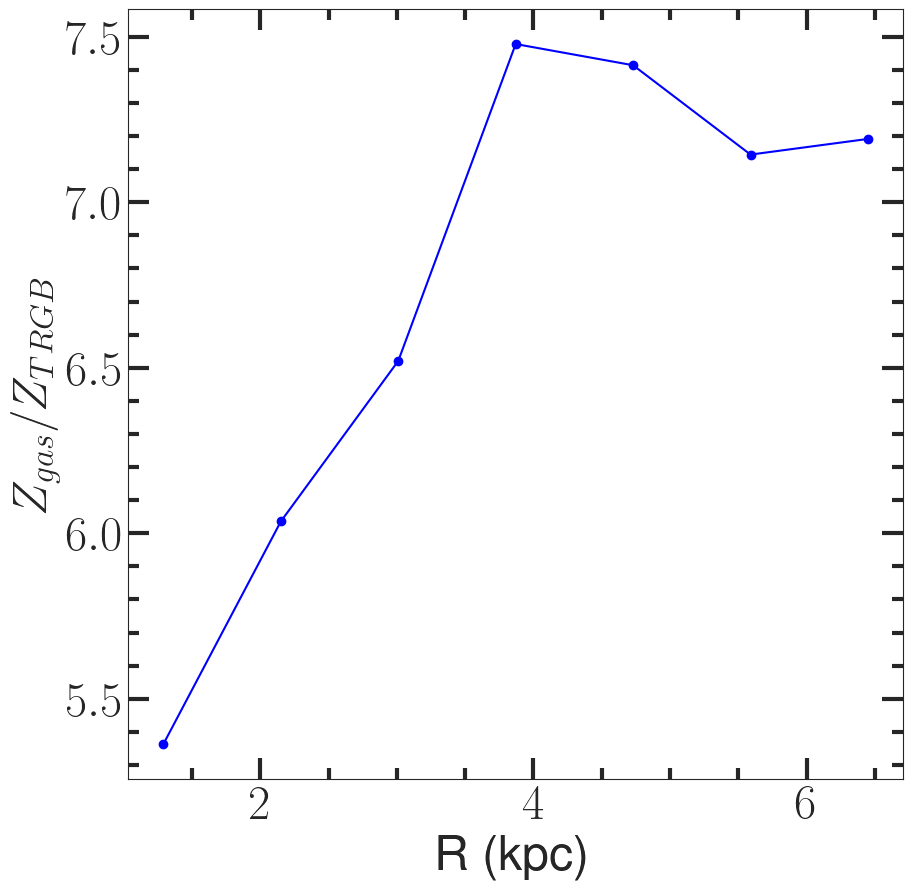

In [128]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(x_c*43/1e3,y_2/y_1,'-bo')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True,left=True, right=True, top=True, width=3)
ax.tick_params(which='minor', length=8, width=3)
ax.set_xlabel('R (kpc)')
ax.set_ylabel(r'$Z_{gas}/Z_{TRGB}$')

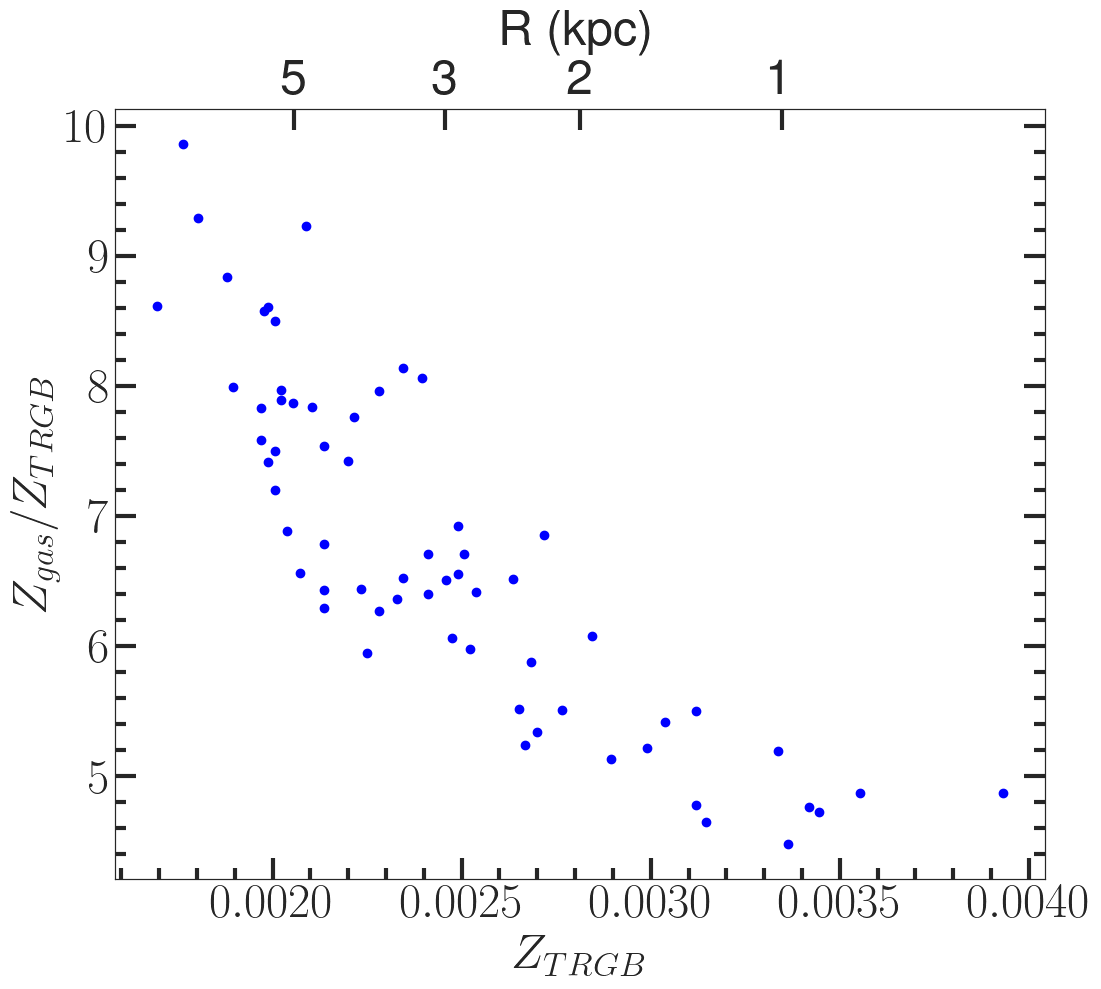

In [142]:
r_ = r.copy()

x = met_map.ravel()
y = Z_gas.ravel()/met_map.ravel()

fig, ax_ = plt.subplots(figsize=(12,10))

img = ax_.scatter(x,y, color='blue')


ax_.xaxis.set_major_locator(AutoLocator())
ax_.xaxis.set_minor_locator(AutoMinorLocator())

ax_.yaxis.set_major_locator(AutoLocator())
ax_.yaxis.set_minor_locator(AutoMinorLocator())

ax_.tick_params(which='both', length=15,direction="in", left=True, right=True,bottom=True, top=True, width=3)
ax_.tick_params(which='minor', length=8, width=3)

ax_.set_xlabel(r'$Z_{TRGB}$')

ax_.set_ylabel(r'$Z_{gas}/Z_{TRGB}$')

ax1 = ax_.twiny()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1
ax1.set_xlim(ax_.get_xlim()[0],ax_.get_xlim()[1])

inv_model = log1d(model.parameters[0],model.parameters[1], model.parameters[2], model.parameters[3])
xticks_n = np.array([5,3,2,1])
xticks = model(xticks_n*1e3/43)

ax1.set_xticks(xticks, xticks_n)
ax1.tick_params(which='both', length=15,direction="in", top=True, width=3)
ax1.tick_params(which='minor', length=8, width=3);

In [140]:
xticks

array([0.00177864, 0.00205764, 0.0024561 , 0.00281331, 0.00334764])

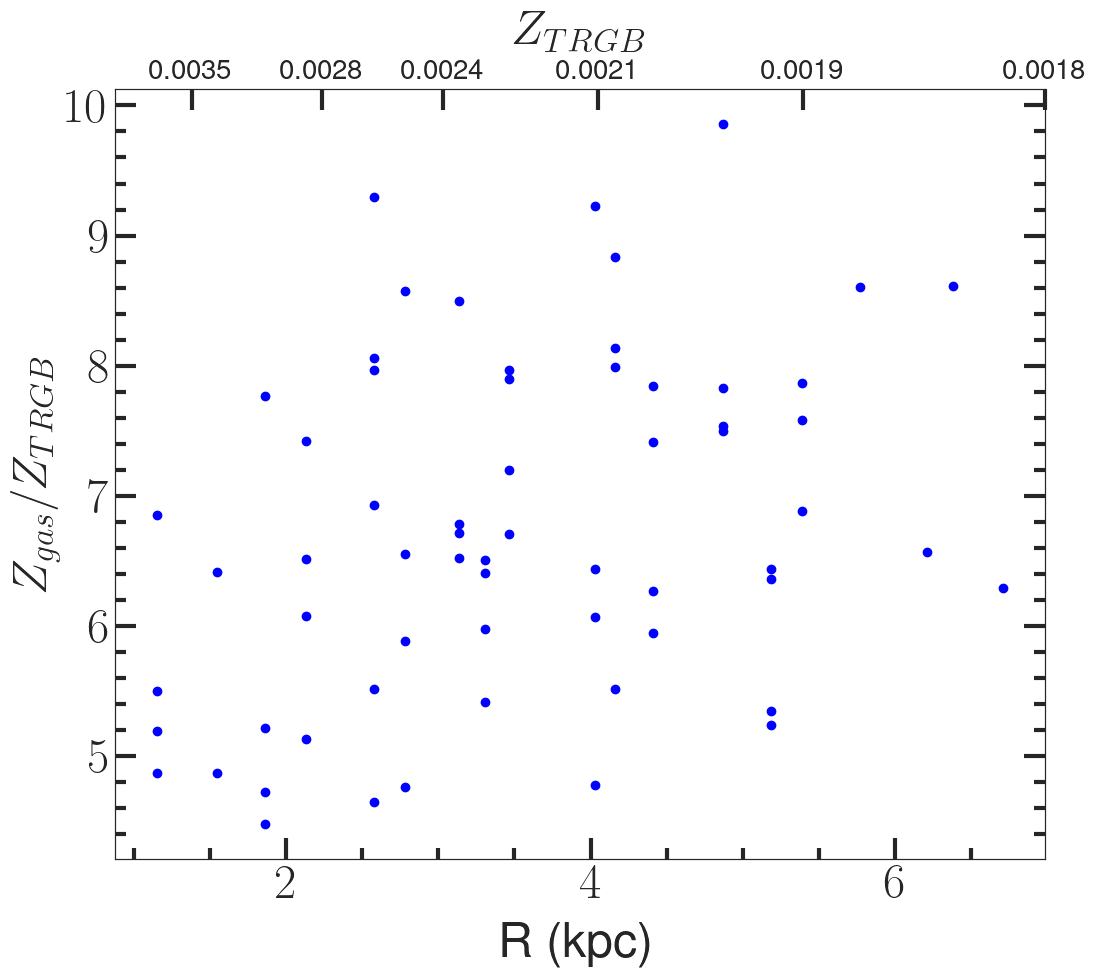

In [109]:
r_ = r.copy()

x = r_.ravel()*43/1e3
y = Z_gas.ravel()/met_map.ravel()

fig, ax_ = plt.subplots(figsize=(12,10))

img = ax_.scatter(x,y, color='blue')


ax_.xaxis.set_major_locator(AutoLocator())
ax_.xaxis.set_minor_locator(AutoMinorLocator())

ax_.yaxis.set_major_locator(AutoLocator())
ax_.yaxis.set_minor_locator(AutoMinorLocator())

ax_.tick_params(which='both', length=15,direction="in", left=True, right=True,bottom=True, top=True, width=3)
ax_.tick_params(which='minor', length=8, width=3)



ax_.set_ylabel(r'$Z_{gas}/Z_{TRGB}$')

ax1 = ax_.twiny()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel(r'$Z_{TRGB}$', labelpad=10)
ax_.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1
ax1.set_xlim(ax_.get_xlim()[0],ax_.get_xlim()[1])

inv_model = log1d(model.parameters[0],model.parameters[1], model.parameters[2], model.parameters[3])
xticks = ax_.get_xticks()[1:-1]
xticks_n = [0.0018,0.0019, 0.0021, 0.0024, 0.0028, 0.0035, ]

xticks = inv_model(xticks_n)

ax1.set_xticks(xticks, xticks_n, fontsize=20)
ax1.tick_params(which='both', length=15,direction="in", top=True, width=3)
ax1.tick_params(which='minor', length=8, width=3);

In [320]:
inv_model(xticks)

/tmp/ipykernel_40421/4232760712.py:4: RuntimeWarning: invalid value encountered in log
  return -(x0 + tau*np.log((y-B)/A))


array([         nan, 125.05693271,  63.98491234,  36.0135384 ,
        17.6614974 ,   3.97976116,  -6.93288922])

In [271]:
dx

array([0.0015, 0.002 , 0.0025, 0.003 , 0.0035, 0.004 , 0.0045])

In [258]:
inv_model(model(20))

19.999999999999996

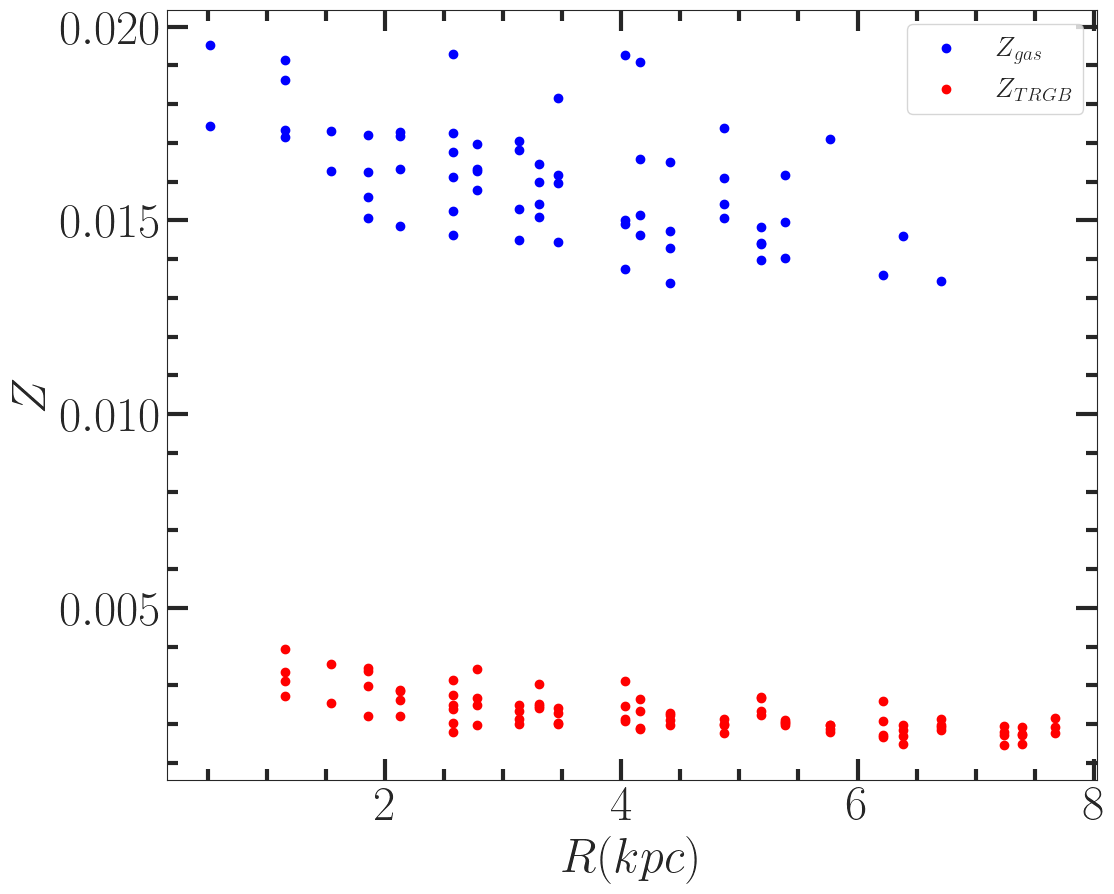

In [112]:
r_ = r.copy()


fig, ax_ = plt.subplots(figsize=(12,10))

x = r*43/1e3
y = Z_gas
img = ax_.scatter(x,y, color='blue')

x = r*43/1e3
y = met_map
img = ax_.scatter(x,y, color='red')


ax_.xaxis.set_major_locator(AutoLocator())
ax_.xaxis.set_minor_locator(AutoMinorLocator())

ax_.yaxis.set_major_locator(AutoLocator())
ax_.yaxis.set_minor_locator(AutoMinorLocator())

ax_.tick_params(which='both', length=15,direction="in", left=True, right=True,bottom=True, top=True, width=3)
ax_.tick_params(which='minor', length=8, width=3)

ax_.set_xlabel(r'$R (kpc)$')

ax_.set_ylabel(r'$Z$')

ax_.legend([r'$Z_{gas}$',r'$Z_{TRGB}$'], fontsize=20)

Text(0, 0.5, '$Z_{gas}/Z_{star}$')

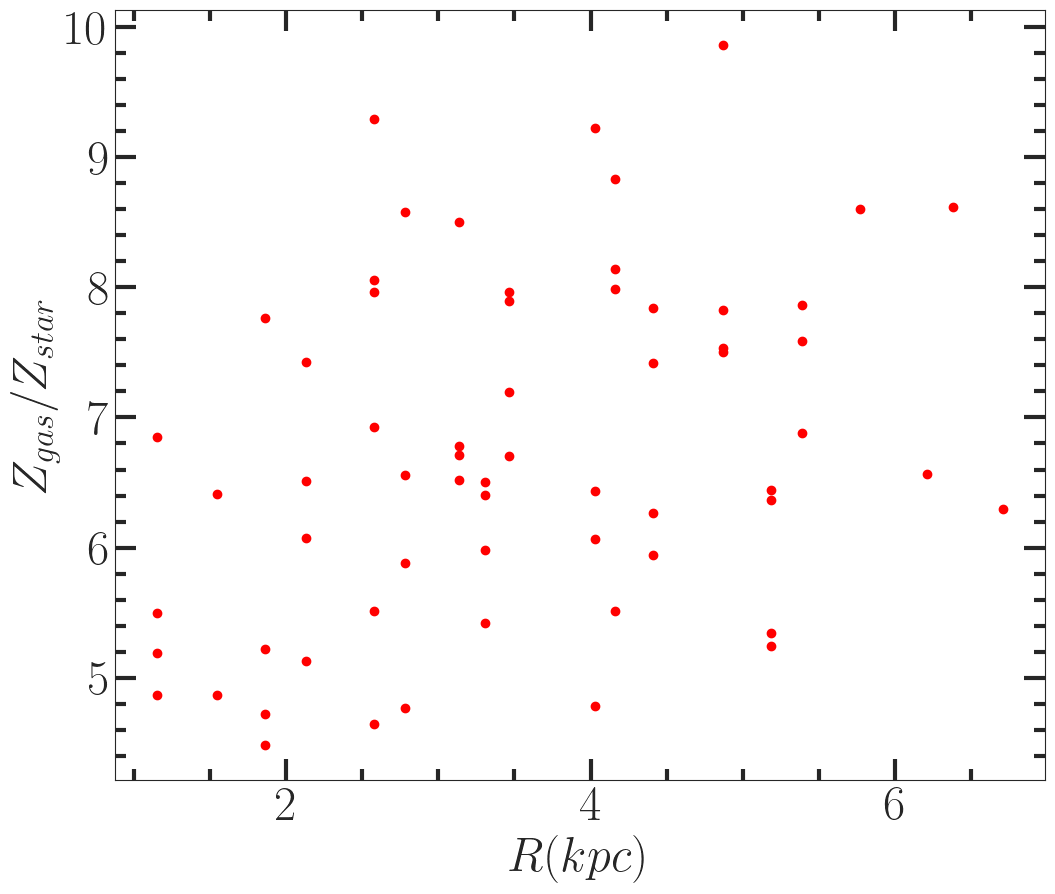

In [72]:
r_ = r.copy()


fig, ax_ = plt.subplots(figsize=(12,10))

x = r*43/1e3
y = Z_gas/met_map
img = ax_.scatter(x,y, color='red')


ax_.xaxis.set_major_locator(AutoLocator())
ax_.xaxis.set_minor_locator(AutoMinorLocator())

ax_.yaxis.set_major_locator(AutoLocator())
ax_.yaxis.set_minor_locator(AutoMinorLocator())

ax_.tick_params(which='both', length=15,direction="in", left=True, right=True,bottom=True, top=True, width=3)
ax_.tick_params(which='minor', length=8, width=3)

ax_.set_xlabel(r'$R (kpc)$')

ax_.set_ylabel(r'$Z_{gas}/Z_{star}$')

Text(0, 0.5, 'Z')

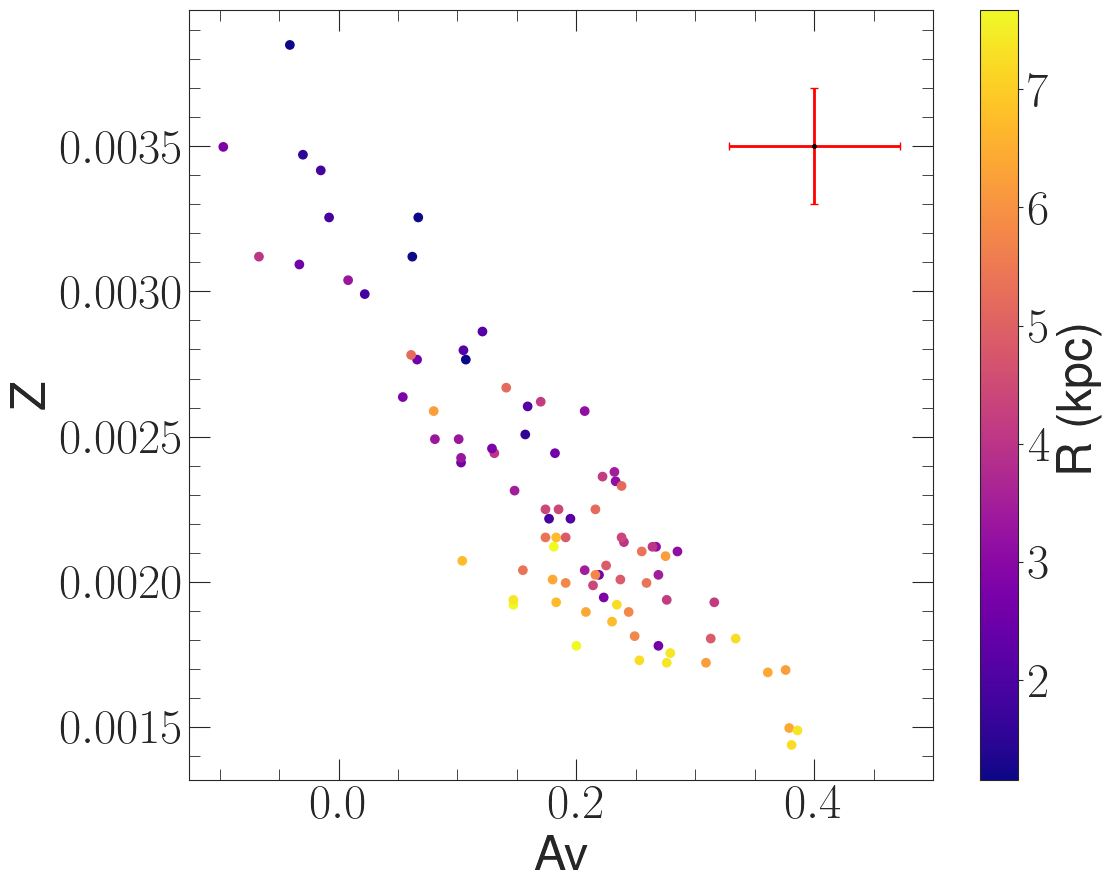

In [86]:
fig, ax = plt.subplots(figsize=(12,10))

img = ax.scatter(Av_map.ravel(), met_map.ravel(), c=r*43/1e3, cmap='plasma')

cb = plt.colorbar(img,ax=ax)

cb.set_label('R (kpc)')

ax.errorbar(x=[0.4],y=[0.0035],xerr=0.0719,yerr=0.0002, fmt='.r',elinewidth=2,
            markersize=5, capsize=3, markerfacecolor='black', markeredgecolor='black')
ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=8)

ax.set_xlabel('Av')
ax.set_ylabel('Z')

In [ ]:
slopes

Text(0, 0.5, 'Z')

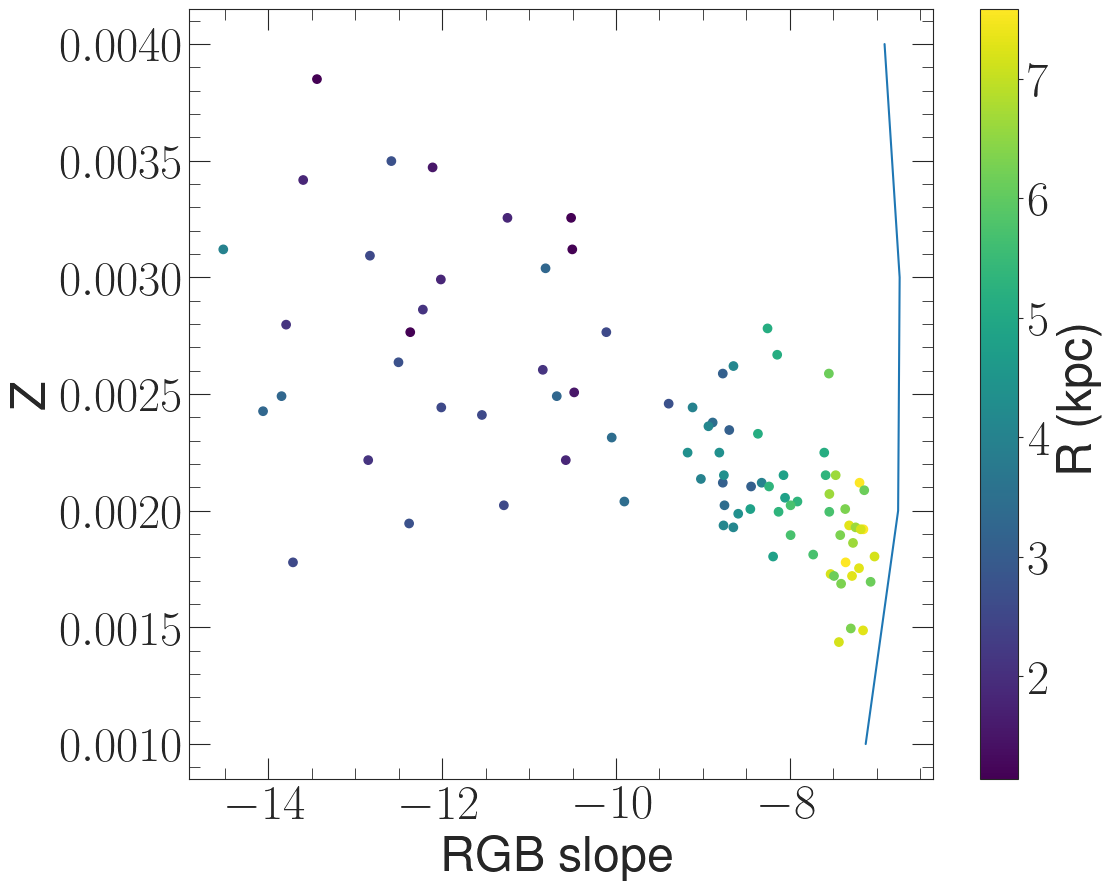

In [98]:
fig, ax = plt.subplots(figsize=(12,10))

img = ax.scatter(1/trgb_cols[:,:,8].ravel(), met_map.ravel(), c=r*42.5/1e3, cmap='viridis')

ax.plot(slopes[-1], np.arange(0.001,0.005,0.001))

cb = plt.colorbar(img,ax=ax)

cb.set_label('R (kpc)')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=8)

ax.set_xlabel('RGB slope')
ax.set_ylabel('Z')

Text(0, 0.5, 'Predicted RGB Slope(Z)')

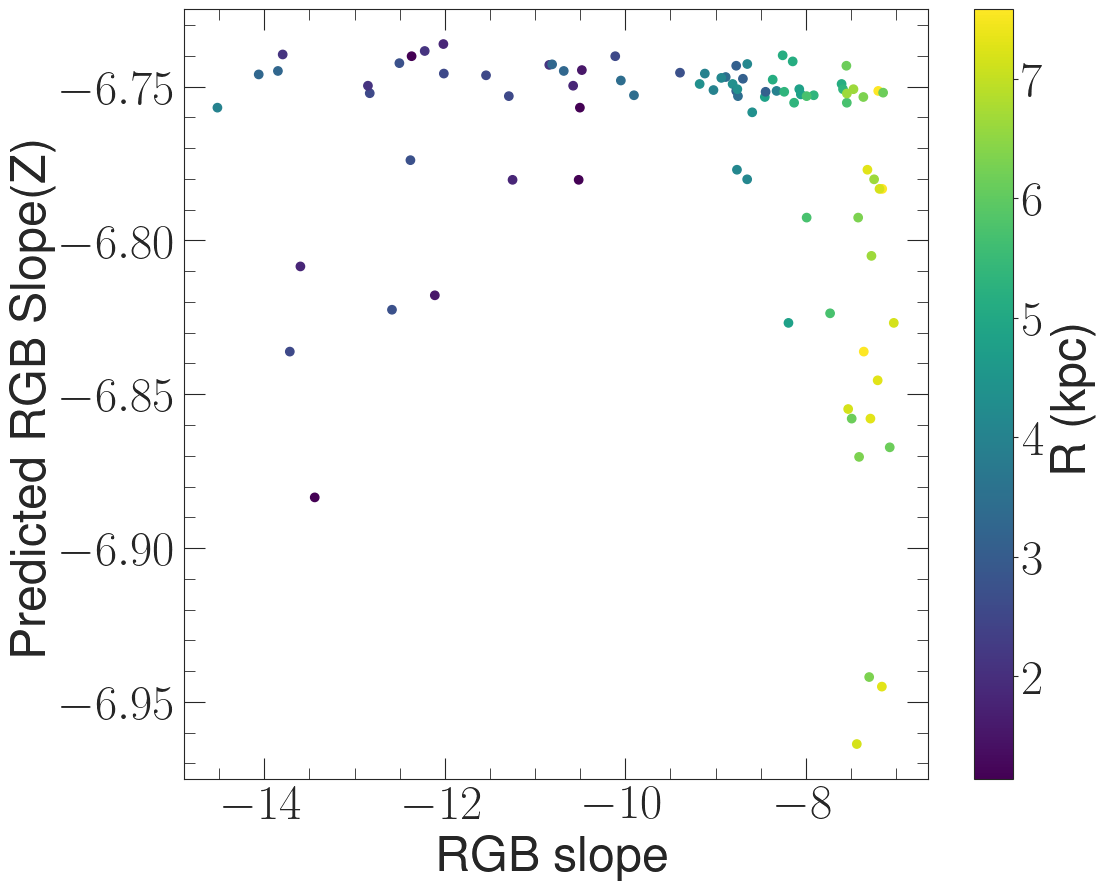

In [133]:
fig, ax = plt.subplots(figsize=(12,10))

img = ax.scatter(1/trgb_cols[:,:,8].ravel(), slope_interp(met_map.ravel()), c=r*42.5/1e3, cmap='viridis')

cb = plt.colorbar(img,ax=ax)

cb.set_label('R (kpc)')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=8)

ax.set_xlabel('RGB slope')
ax.set_ylabel('Predicted RGB Slope(Z)')

Text(0, 0.5, 'Av')

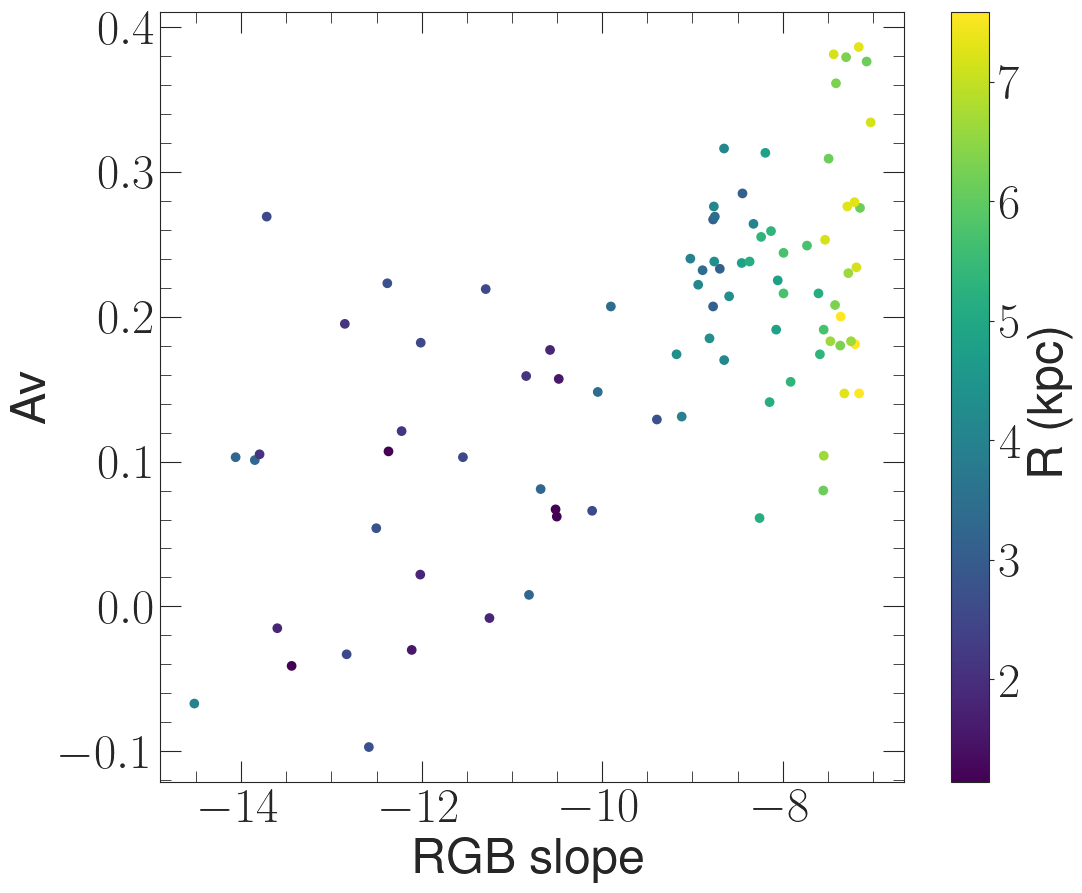

In [102]:
fig, ax = plt.subplots(figsize=(12,10))

img = ax.scatter(1/trgb_cols[:,:,8].ravel(), Av_map.ravel(), c=r*42.5/1e3, cmap='viridis')

cb = plt.colorbar(img,ax=ax)

cb.set_label('R (kpc)')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=8)

ax.set_xlabel('RGB slope')
ax.set_ylabel('Av')

Text(0, 0.5, 'Z')

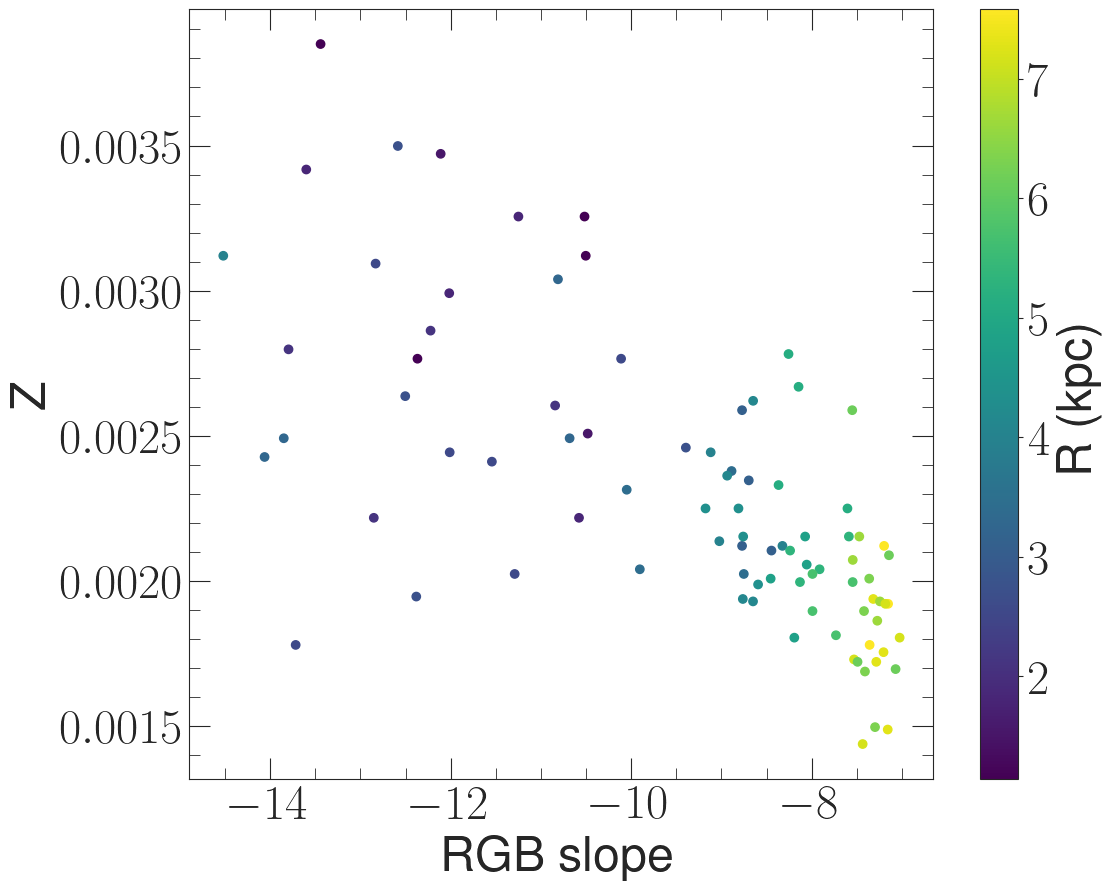

In [103]:
fig, ax = plt.subplots(figsize=(12,10))

img = ax.scatter(1/trgb_cols[:,:,8].ravel(), met_map.ravel(), c=r*42.5/1e3, cmap='viridis')

cb = plt.colorbar(img,ax=ax)

cb.set_label('R (kpc)')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=15,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=8)

ax.set_xlabel('RGB slope')
ax.set_ylabel('Z')

(0.00129329999999994, 0.0042347027027019295)

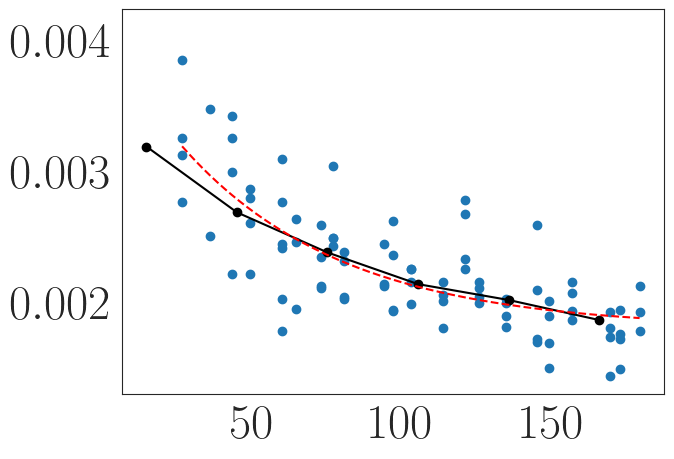

In [104]:
x = r.ravel()
y = (met_map*mask).ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,30)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)


plt.scatter(x,y)
plt.plot(x_c,y_c,'-ok')

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model = fit(init,abs(x),y)


x_new = np.linspace(x.min(),x.max(),1000)

plt.plot(x_new, model(x_new),'--r')

plt.ylim(0.9*y.min(), 1.1*y.max())

In [105]:
r[:,2]

array([168.42802617, 144.49913495, 120.59850745,  96.74709298,
        72.99315036,  49.47726751,  26.83281573,  12.        ,
        26.83281573,  49.47726751,  72.99315036,  96.74709298,
       120.59850745, 144.49913495, 168.42802617])

In [106]:
trgb_f200w_mag[:,2]

array([23.525  , 23.53775, 23.37425, 23.49925, 23.4625 , 23.385  ,
       23.3095 ,      nan, 23.35599, 23.43775, 23.4685 , 23.4905 ,
       23.3455 , 23.555  , 23.527  ])

/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/avinashck/anaconda3/envs/inaoe/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


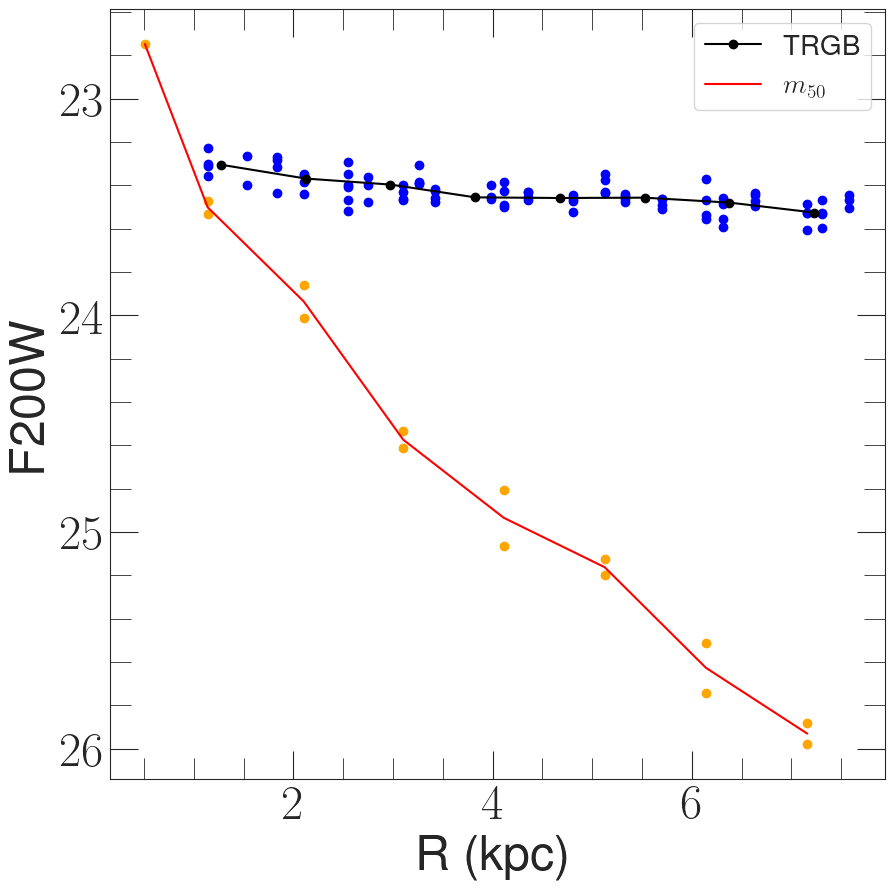

In [107]:
fig, ax = plt.subplots(figsize=(10,10))
x = r.ravel()
y = (trgb_f200w_mag*mask).ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.2,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)


ax.scatter(x*42.5*1e-3,y, color='blue')
ax.plot(x_c*42.5*1e-3,y_c,'-ok', label = 'TRGB')

y_f200w = np.array([25.9781503 , 25.74232124, 25.19845565, 24.80504045, 24.53260125,
       23.85941158, 23.47109451, 22.7474432 , 23.53099111, 24.00988105,
       24.61366905, 25.06264859, 25.12595093, 25.5101388 , 25.88185164])

x = np.array([-168.42802617, -144.49913495, -120.59850745,  -96.74709298,
        -72.99315036,  -49.47726751,  -26.83281573,   12.        ,
         26.83281573,   49.47726751,   72.99315036,   96.74709298,
        120.59850745,  144.49913495,  168.42802617])[:len(y_f200w)]

ax.scatter(abs(x)*42.5e-3,y_f200w, color='orange', label='_no_legend_')

x = x[7:][::-1]
y = 0.5*(y_f200w[:8] + y_f200w[7:][::-1])

ax.plot(x*42.5e-3,y, '-r', label=r'$m_{50}$')
            
ax.set_xlabel('R (kpc)')
ax.set_ylabel('F200W')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=20,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=15)

ax.invert_yaxis()
ax.legend(fontsize=20)

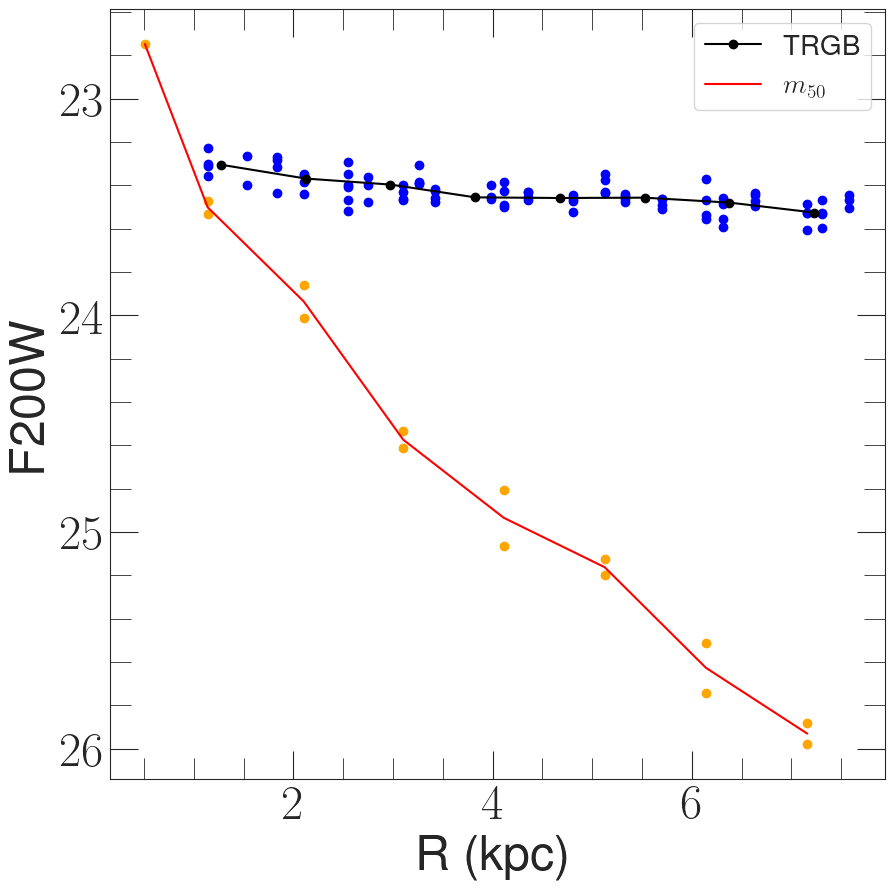

In [108]:
fig, ax = plt.subplots(figsize=(10,10))
x = r.ravel()
y = (trgb_f200w_mag*mask).ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.2,20)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)


ax.scatter(x*42.5*1e-3,y, color='blue')
ax.plot(x_c*42.5*1e-3,y_c,'-ok', label = 'TRGB')

y_f200w = np.array([25.9781503 , 25.74232124, 25.19845565, 24.80504045, 24.53260125,
       23.85941158, 23.47109451, 22.7474432 , 23.53099111, 24.00988105,
       24.61366905, 25.06264859, 25.12595093, 25.5101388 , 25.88185164])

x = np.array([-168.42802617, -144.49913495, -120.59850745,  -96.74709298,
        -72.99315036,  -49.47726751,  -26.83281573,   12.        ,
         26.83281573,   49.47726751,   72.99315036,   96.74709298,
        120.59850745,  144.49913495,  168.42802617])[:len(y_f200w)]

ax.scatter(abs(x)*42.5e-3,y_f200w, color='orange', label='_no_legend_')

x = x[7:][::-1]
y = 0.5*(y_f200w[:8] + y_f200w[7:][::-1])

ax.plot(x*42.5e-3,y, '-r', label=r'$m_{50}$')
            
ax.set_xlabel('R (kpc)')
ax.set_ylabel('F200W')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=20,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=15)

ax.invert_yaxis()
ax.legend(fontsize=20)

NameError: name 'trgb_frac' is not defined

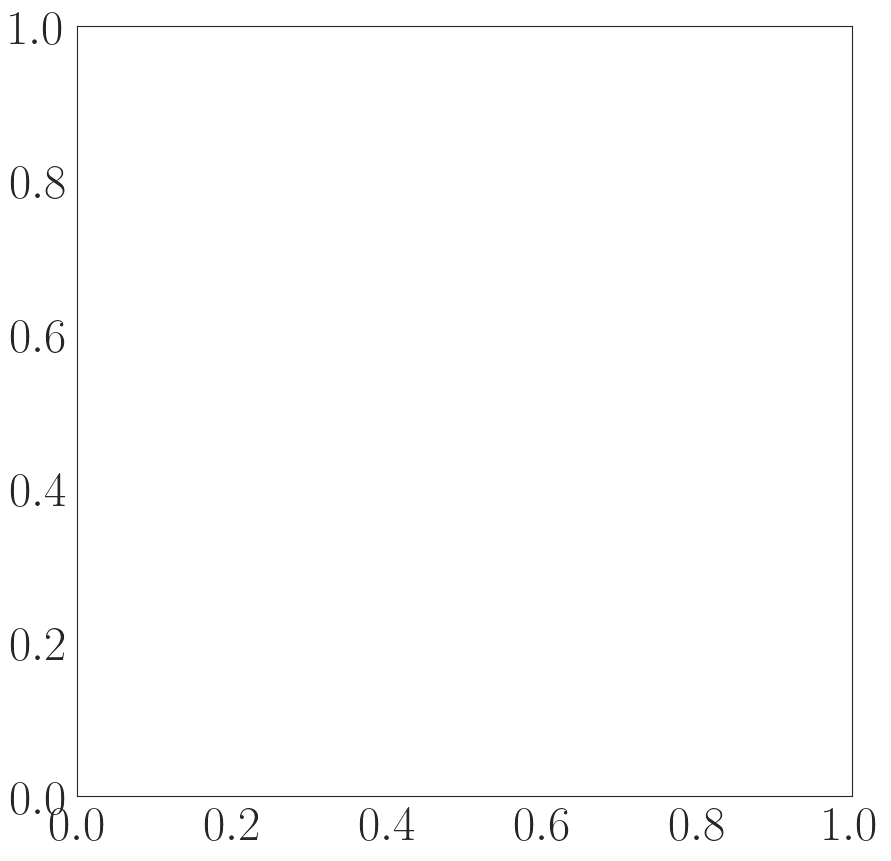

In [109]:
fig, ax = plt.subplots(figsize=(10,10))
x = r.ravel()
y = (trgb_frac[:,:,2]/trgb_frac[:,:,1]).ravel()
        
plt.scatter(x,y)

ax.set_xlabel('R (kpc)')
ax.set_ylabel('N(AGB)/N(RGB)')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=20,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=15)


NameError: name 'trgb_frac' is not defined

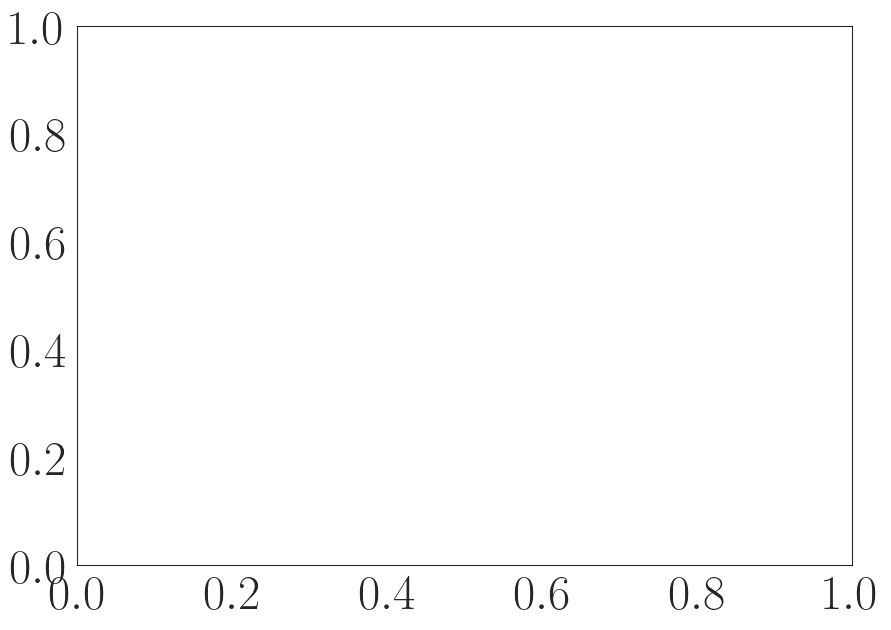

In [110]:
fig , ax = plt.subplots(figsize=(10,7), sharex=True)
# Total
agb_rgb = trgb_frac[:,:,2]/(trgb_frac[:,:,1] + trgb_frac[:,:,2] )
x = r.ravel()
y = (agb_rgb*mask).ravel()
ind = ~np.isnan(y)
x = x[ind]
y = y[ind]

tau = 10
init = exp1d(A=0.6, tau=5)
fit = fitting.LevMarLSQFitter()
model = fit(init,abs(x),y)

# Left
x = r[:7].ravel()
y = (agb_rgb*mask)[:7].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,35)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(-x,y, marker='.', color='blue')
ax.plot(-x_c,y_c, '--ok')
x_new = np.linspace(0,x.max(),1000)

init = exp1d(tau=5)
fit = fitting.LevMarLSQFitter()
model1 = fit(init,x,y)

#ax.plot(-x_new, model(x_new),'--r')

#Right
x = r[7:].ravel()
y = (agb_rgb*mask)[7:].ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

x_new = np.arange(0,x.max()*1.1,35)
x_c = 0.5*(x_new[1:] + x_new[:-1])

y_new = []
for i in range(len(x_new)-1):
    ind = np.where((x>x_new[i]) & (x<=x_new[i+1]))
    
    y_new.append(np.median(y[ind]))

y_c = np.array(y_new)

ax.scatter(x,y, marker='.', color='blue')
ax.plot(x_c,y_c, '--ok')

x_new = np.linspace(0,x.max(),1000)

init = exp1d(tau=10)
fit = fitting.LevMarLSQFitter()
model2 = fit(init,x,y)

#ax.plot(x_new, model(x_new),'--r')

ax.set_ylabel(r'$N_{AGB}/(N_{AGB} + N_{RGB})$')


ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=7,direction="in", bottom=True,left=True, right=True)
ax.tick_params(which='minor', length=4)

ax1 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1
xticks = ax.get_xticks()
xticks_n = xticks

dx = xticks_n - np.floor(xticks_n)

ax1.set_xticks(xticks, np.floor(xticks_n)*42.5/1e3)

ax1.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])

ax.set_xlabel('R (arcsecs)')
ax.set_yscale('log')

NameError: name 'trgb_frac' is not defined

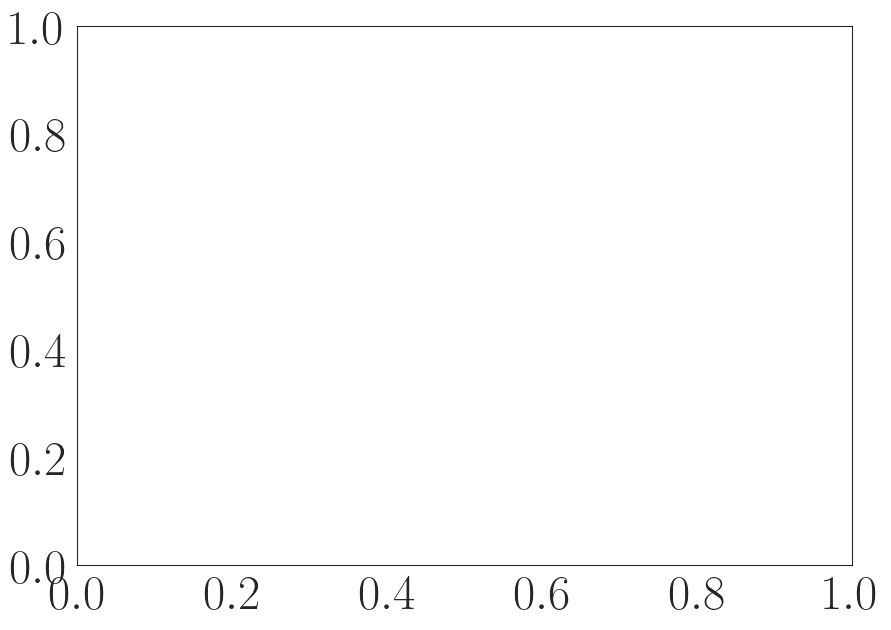

In [111]:
fig , ax = plt.subplots(figsize=(10,7), sharex=True)
# Total
agb_rgb = trgb_frac[:,:,2]/(trgb_frac[:,:,2] + trgb_frac[:,:,1])
#agb_rgb = met_map/agb_rgb
x = (trgb_f200w_mag*mask).ravel()
y = (agb_rgb*mask).ravel()
ind = ~np.isnan(y)

x = x[ind]
y = y[ind]

ax.scatter(x,y, marker='.', color='blue')

ax.set_ylabel(r'$(N_{AGB}/(N_{AGB} + N_{RGB}))/Z$')


ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=7,direction="in", bottom=True,left=True, right=True)
ax.tick_params(which='minor', length=4)

ax1 = ax.twiny()  # instantiate a second axes that shares the same x-axis
ax1.set_xlabel('R (kpc)',labelpad=10)  # we already handled the x-label with ax1
xticks = ax.get_xticks()
xticks_n = xticks

dx = xticks_n - np.floor(xticks_n)

ax1.set_xticks(xticks, np.floor(xticks_n)*42.5/1e3)

ax1.set_xlim(ax.get_xlim()[0],ax.get_xlim()[1])

ax.set_xlabel('TRGB (F200W)')

In [112]:
model

<exp1d(x0=18.12383562, tau=53.07815648, A=0.00324798, B=0.00179678)>

In [113]:
abs(x)*42.5e-3

array([7.58169506, 7.30208874, 7.15819111, 7.15819111, 7.30208874,
       7.58169506, 6.63      , 6.30835161, 6.14121324, 6.14121324,
       6.30835161, 6.63      , 5.70197334, 5.32455632, 5.12543657,
       5.12543657, 5.32455632, 5.70197334, 4.81133038, 4.35744191,
       4.11175145, 4.11175145, 4.35744191, 4.81133038, 3.98322733,
       3.42118401, 3.10220889, 3.10220889, 3.42118401, 3.98322733,
       3.26559336, 2.55      , 2.10278387, 2.10278387, 2.55      ,
       3.26559336, 2.74643405, 1.83883115, 1.14039467, 1.14039467,
       1.83883115, 2.74643405, 2.55      , 1.53      , 0.51      ,
       0.51      , 1.53      , 2.55      , 2.74643405, 1.83883115,
       1.14039467, 1.14039467, 1.83883115, 2.74643405, 3.26559336,
       2.55      , 2.10278387, 2.10278387, 2.55      , 3.26559336,
       3.98322733, 3.42118401, 3.10220889, 3.10220889, 3.42118401,
       3.98322733, 4.81133038, 4.35744191, 4.11175145, 4.11175145,
       4.35744191, 4.81133038, 5.70197334, 5.32455632, 5.12543

In [114]:
y2

array([23.71115, 23.52215, 23.40515, 23.32115])

In [115]:
y_f200w[6:][::-1]

array([25.88185164, 25.5101388 , 25.12595093, 25.06264859, 24.61366905,
       24.00988105, 23.53099111, 22.7474432 , 23.47109451])

In [116]:
y_f200w[7::-1]

array([22.7474432 , 23.47109451, 23.85941158, 24.53260125, 24.80504045,
       25.19845565, 25.74232124, 25.9781503 ])

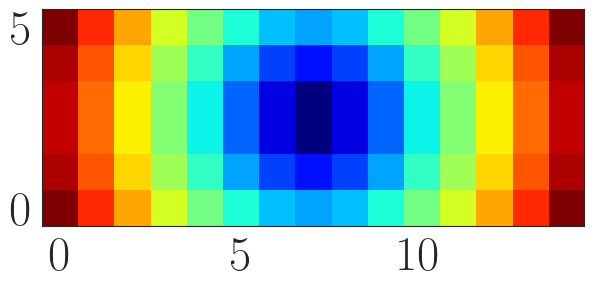

In [117]:
plt.imshow(r.T, cmap='jet')

In [105]:
dmpc*1e3*np.tan(np.deg2rad(model.tau.value/3600))

2.733509602344168

In [41]:
model.tau.value

AttributeError: 'Linear1D' object has no attribute 'tau'

In [ ]:
model1

In [ ]:
model2

In [57]:
trgb_cols[:,:,7].shape

(15, 6)

In [82]:
dats = []
for i in reg_arr.ravel().astype(int):
    ra = regions_dict[f'reg_{i}']['ra']
    dec = regions_dict[f'reg_{i}']['dec']
    trgb_mag = np.round(trgb_f200w_mag.ravel()[i],4)
    trgb_err = np.round(trgb_f200w_err.ravel()[i],4)
    trgb_col = np.round(trgb_cols[:,:,7].ravel()[i],4)
    trgb_col_err = np.round(model_col_err(trgb_mag),4)
    
    met_trgb = np.round(met_map.ravel()[i],4)
    av_trgb = np.round(Av_map.ravel()[i],4)
    
    met_muse = np.round(Z_gas.ravel()[i],4)
    av_muse = np.round(Av_map_n.ravel()[i],4)
    dats.append([i, ra,dec,trgb_mag, trgb_err,trgb_col,trgb_col_err, met_trgb, av_trgb, met_muse,av_muse])

df = pd.DataFrame(dats, columns=['Region_ID', 'RA', 'Dec', 'TRGB_mag_F200W', 'TRGB_mag_err_F200W', 'TRGB_col_F115W-F200W', 'TRGB_col_err_F115W-F200W', 
                                 'Z_TRGB','Av_TRGB','Z_MUSE','Av_MUSE'])

In [84]:
tb = Table.from_pandas(df)

In [94]:
tb = Table.read('../data/NGC628_TRGB.fits')

In [99]:
tb.meta

OrderedDict([('EXTNAME',
              'D:\\Code_Stuff\\INAOE\\Bubble\\data\\NGC628_TRGB.fits#1'),
             ('TCOMM1', 'Refer to paper'),
             ('TCOMM2', 'Right Ascension (ICRS)'),
             ('TCOMM3', 'Declination (ICRS)[deg]'),
             ('TCOMM4', 'TRGB magnitude in JWST-NIRCAM F200W filter'),
             ('TCOMM5',
              'Error in TRGB magnitude from Monte Carlo simulations, binning and sm'),
             ('TCOMM6', 'TRGB color F115W-F200W at the TRGB magnitude'),
             ('TCOMM7', 'TRGB color error'),
             ('TCOMM8', 'Stellar-metallicity obtained from TRGB analysis'),
             ('TCOMM9', 'Extinction value obtained from TRGB analysis'),
             ('TCOMM10', 'Gas-phase metallicity obtained from MUSE data'),
             ('TCOMM11', 'Extinction value obtained from MUSE data'),
             ('DATE-HDU', '2024-09-09T23:23:52'),
             ('STILVERS', '4.1-4'),
             ('STILCLAS', 'uk.ac.starlink.votable.FitsPlusTableWriter')])

In [100]:
tb

<Table length=90>
Region_ID         RA                Dec         TRGB_mag_F200W TRGB_mag_err_F200W ...  Z_TRGB Av_TRGB  Z_MUSE Av_MUSE
                 deg                deg              mag              mag         ...                                
  int64        float64            float64          float64          float64       ... float64 float64 float64 float64
--------- ------------------ ------------------ -------------- ------------------ ... ------- ------- ------- -------
        0 24.169146711091265 15.832715532352367        23.4687             0.0279 ...  0.0019   0.155      --      --
        1 24.162866304550995 15.829898368436695         23.465             0.0237 ...  0.0019   0.138      --      --
        2  24.15658607287754 15.827081023748141         23.525             0.0236 ...  0.0017   0.244      --      --
        3  24.15030601621449  15.82426349840188         23.605             0.0248 ...  0.0015   0.392      --      --
        4  24.14402613470542  15.82144579251306        23.5308             0.0236 ...  0.0017   0.267      --      --
        5 24.137746428493895 15.818627906196868        23.4455             0.0243 ...  0.0022   0.205      --      --
        6   24.1720747854006 15.826673287691143        23.4732              0.023 ...  0.0019   0.169      --      --
        7 24.165794525340605 15.823856207595034        23.5937             0.0256 ...  0.0015   0.362      --      --
        8 24.159514440067774  15.82103894679624        23.5378             0.0237 ...  0.0017   0.308      --      --
      ...                ...                ...            ...                ... ...     ...     ...     ...     ...
       81 24.188363080006255 15.745714504069559        23.4682             0.0273 ...  0.0021   0.269  0.0136   0.426
       82 24.182085101701304 15.742897890756687        23.5547             0.0235 ...  0.0017    0.37  0.0146  0.6797
       83   24.1758072976591 15.740081097929288         23.442             0.0234 ...  0.0021   0.172  0.0134  1.0267
       84 24.210123863707246 15.748120512290253        23.5055             0.0237 ...  0.0018   0.197      --      --
       85 24.203845510299278  15.74530452206126        23.5975             0.0234 ...  0.0015   0.379      --      --
       86 24.197567330643974  15.74248835204286         23.527             0.0243 ...  0.0018   0.325      --      --
       87 24.191289324884885 15.739672002350058         23.485             0.0231 ...   0.002   0.265      --      --
       88 24.185011493165522 15.736855473097915        23.5252             0.0241 ...  0.0018   0.277      --      --
       89 24.178733835629377  15.73403876440151             --                 -- ...      --      --      --      --

# **Extinction**

Number of objects in the selected region: 5697


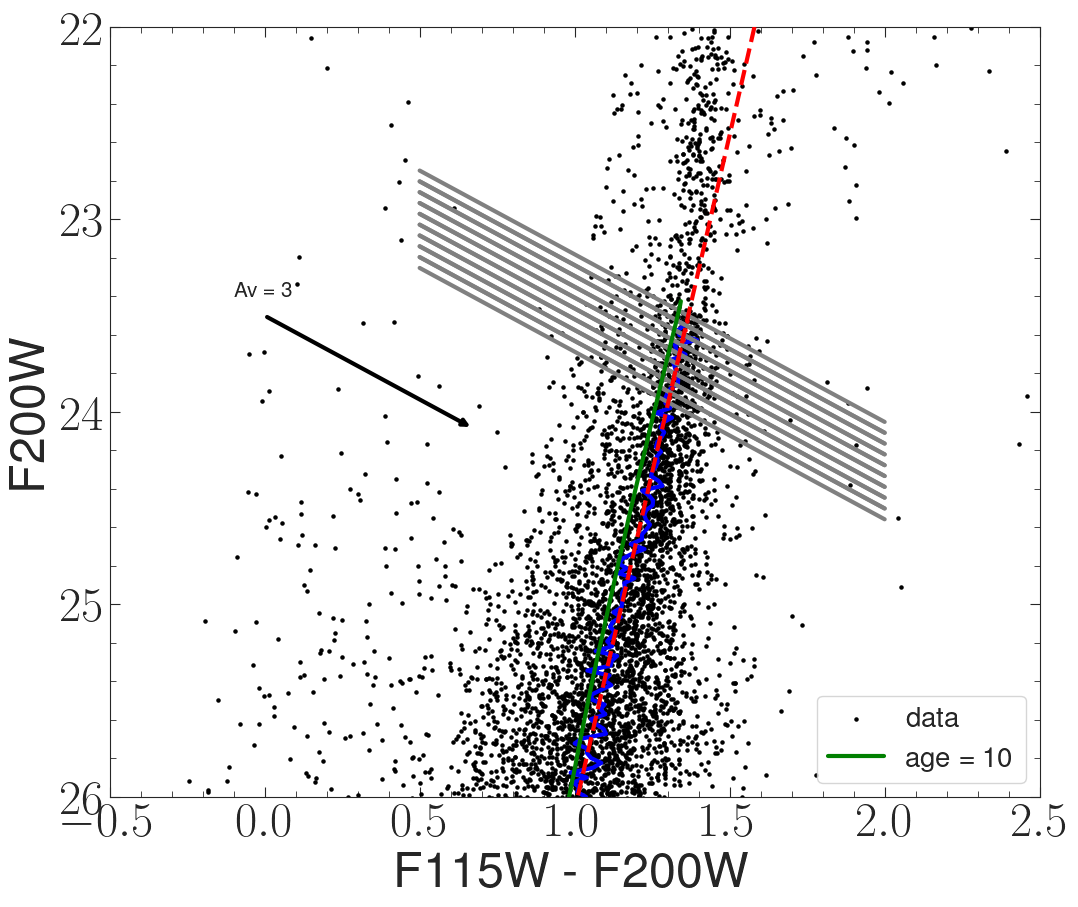

In [56]:
filt1 = 'f115w'
filt2 = 'f200w'
filt3 = 'f200w'

tab = Table.read('../photometry/ngc628/f115w_f200w.fits')

r_in  = 0
r_out = 24

dl= 0.05
l_lo = 23.5
l_hi = 24
cmd_xlo = 0.5
cmd_xhi = 2

ra_cen  = regions_dict['reg_0']['ra']
dec_cen = regions_dict['reg_0']['dec']

fig, ax, dats_bub, x_val, y_val, y_bins, model_rgb = gen_CMD_xcut(tab,filt1, filt2,filt3, ra_cen=ra_cen, dec_cen=dec_cen,
                                                    cmd=df_cmd_jwst, label_min=0, label_max=3,Av=0.19,
                                                      sqr_field = True, r_in=r_in, r_out=r_out, age=10, met=0.002,Av_y=23.5, Av_x=0,
                                                      l_lo=l_lo, l_hi=l_hi,dismod=29.7416,ylims=[22,26],rgb_ylo=23.5,
                                                       dl=dl,cmd_xlo=cmd_xlo, cmd_xhi=cmd_xhi,           
                                                      fit_isochrone=False)


### **Carbon Stars**

In [ ]:
tab = Table.read('../PHOT_OUTPUT_r40.5/galaxy/f115w_f200w.fits')

In [ ]:
tab['f115w_f200w'] = tab['mag_vega_F115W'] - tab['mag_vega_F200W']

x = np.linspace(1,4)
y = (24-29)*(x-2.1) + 24

init = models.Linear1D()
fit = fitting.LinearLSQFitter()
model_1 = fit(init, x,y)

y = -(24-24.2)*(x-2.5) + 24

model_2 = fit(init, x,y)

ra_cen, dec_cen = 24.1739654, 15.7837025

tab['r'] = angular_separation(tab['ra_1']*u.deg, tab['dec_1']*u.deg, ra_cen*u.deg, dec_cen*u.deg).to(u.arcsec).value

x = tab['ra_1']
y = tab['dec_1']
c = tab['r']

rs = [0, 10]
A  = np.pi*rs[-1]**2

while rs[-1] < 75:
    r = np.sqrt((A+np.pi*rs[-1]**2)/np.pi)
    
    rs.append(r)
    
n_cs = [0]
for i in range(len(rs)-1):
    r_in = rs[i]
    r_out = rs[i+1]
    
    # Annulus
    t = tab[(tab['r']>=r_in) & (tab['r']<r_out)]
    
    # Carbon stars
    t = t[t['mag_vega_F200W']>=model_1(t['f115w_f200w'])]
    t = t[t['mag_vega_F200W']<=model_2(t['f115w_f200w'])]
    
    x = t['ra_1']
    y = t['dec_1']
    
    n_cs.append(len(t))

In [ ]:

fig, ax = plt.subplots()

x = tab['f115w_f200w']
y = tab['mag_vega_F200W']
ax.scatter(x,y, s=0.5)

x = t['f115w_f200w']
y = t['mag_vega_F200W']

ax.scatter(x,y, s=0.5)
x = np.linspace(1,4)
y1 = model_1(x)
y2 = model_2(x)

ax.plot(x,y1,'--r')
ax.plot(x,y2,'--r')

ax.invert_yaxis()
ax.set_xlabel('F115W-F200W')
ax.set_ylabel('F200W')

ax.legend(['Total','Carbon Stars'])

In [ ]:
x = rs
y = n_cs

plt.plot(x,y,'-ok')
plt.xlabel('Radius (arcsecs)')
plt.ylabel('No of Carbon stars')

In [ ]:
t = tab

# Carbon stars
t = t[t['mag_vega_F200W']>=model_1(t['f115w_f200w'])]
t = t[t['mag_vega_F200W']<=model_2(t['f115w_f200w'])]

x = t['ra_1']
y = t['dec_1']

scale = 11417/4486
l = 5
fig, ax = plt.subplots(figsize=(l*scale+3,l))

theta = np.pi/2.75

x,y = x*np.cos(theta) - y*np.sin(theta),x*np.sin(theta) + y*np.cos(theta)
xmin, xmax = -4.259903639039913, -4.369990102024565
ymin, ymax = 28.524099525386, 28.568378781292367

# Peform the kernel density estimate
xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])

kernel = gaussian_kde(values, bw_method=200/3600)
f = np.reshape(kernel(positions), xx.shape)

f = np.fliplr(f).T

img = ax.contourf(f, cmap='jet', levels=np.linspace(200,f.max(),10),
          extent=[xmax, xmin,
                  ymin, ymax], zorder=200, alpha=0.3)

df_f = df[(df['age']>7) &(df['age']<=9.5)]
x = df_f['RA']
y = df_f['DEC']
c = df_f['age']
scale = 11417/4486
l = 5
theta = np.pi/2.75
ax.scatter(x*np.cos(theta) - y*np.sin(theta),x*np.sin(theta) + y*np.cos(theta),s=0.2,c=c, cmap='Greys',
                zorder=199)
ax.invert_xaxis()
ax.set_xlim(-4.259903639039913, -4.369990102024565)
ax.set_ylim(28.524099525386, 28.568378781292367)
ax.axis('Off')
cb = plt.colorbar(img, shrink=0.9, pad=-0.03)
cb.set_label('Gaussian Kernel Density')
fig.tight_layout()

#### **Simulated Carbon Star Image**

In [ ]:
tab = Table.read('Carbon_stars.fits')

In [ ]:
df = tab[['ra_2', 'dec_2', 'flux_2','mag_vega_F200W']].to_pandas()

In [ ]:
df = df.rename(columns={'ra_2':'ra',
                'dec_2':'dec',
                'flux_2': 'flux',
                'mag_vega_F200W':'mag'})

In [ ]:
zero_flux = df['flux']/pow(10,-0.4*df['mag'])
zero_flux = np.median(zero_flux)

In [ ]:
2.5*np.log10(zero_flux)

In [ ]:
hdul_n = fits.open(dict_images[det_n][filt_n]['images'][0])
data_n = hdul_n[1].data

pixel_scale = hdul_n[1].header['CDELT1']*3600

wcs_n = WCS(hdul_n[1].header)

In [ ]:
hdul_n[1].header

In [ ]:
wcs_n

In [ ]:
np.arccos(0.422540420042849)*180/np.pi

In [ ]:
psf = fits.open(f'../data/PSF/epsf/F200W/snap_test_psf.fits')[0].data[0,0]
psf = psf.reshape(51,5,51,5).sum(axis=(1,3))
psf /= psf.sum()

hdu = fits.PrimaryHDU(psf)
hdul = fits.HDUList([hdu])
hdul.writeto('psf.fits', overwrite=True)

tel_params ={
            'aperture'       : 650,
            'pixel_scale'    : pixel_scale,
            'psf_file'       : f'psf.fits',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 6 mirrors
                                ],
             'coeffs'        : 1/11112.266256569348,
             'theta'         : 65.00492096781794,
             'M_sky' : 27,
            }

In [ ]:
sim = pt.Imager(df, coords=(24.17399193760206,  15.78396038669509),
                tel_params=tel_params, n_x=11604, n_y=4630, exp_time = 2920.4)

In [ ]:
2.5*np.log10(sim.zero_flux), 

In [ ]:
sim.shot_noise = False
sim.sky = False
sim.Bias = False
sim.QN = False
sim.DC = False
sim.PRNU = False
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],
              'qe_mean'    : 1,
              'G1'         :  1,
              'bias'       : 1,
              'PRNU_frac'  :  0.25/100,
              'DCNU'       :  0.1/100,
              'RN'         :  0.5,
              'T'          :  218,
              'DN'         :  0.01/100
              }

sim(det_params=det_params, photometry=None)

In [ ]:
sim.show_image()

In [ ]:
sim.writeto('../data/pista_carbon_stars_II.fits')

### **Age gradient**

In [ ]:
fs = glob.glob('data/*.csv')
df = pd.read_csv(fs[0])

for f in fs[1:]:
    df_n = pd.read_csv(f)
    df = pd.concat([df, df_n])

In [ ]:
df.keys()

In [ ]:
df_f = df[(df['age']>5.9) &(df['age']<=7)]
x = df_f['RA']
y = df_f['DEC']
c = df_f['age']
scale = 11417/4486
l = 5
fig, ax = plt.subplots(figsize=(l*scale+3,l))

theta = np.pi/2.75
img = ax.scatter(x*np.cos(theta) - y*np.sin(theta),x*np.sin(theta) + y*np.cos(theta),s=5,c=c, cmap='jet')
#ax.set_xlabel('RA')
#ax.set_ylabel('DEC')
ax.invert_xaxis()
ax.set_xlim(-4.259903639039913, -4.369990102024565)
ax.set_ylim(28.524099525386, 28.568378781292367)
ax.axis('Off')
cb = plt.colorbar(img, shrink=0.9, pad=-0.03)
cb.set_label('log(Age)')
fig.tight_layout()

In [ ]:
df_f = df[(df['age']>7) &(df['age']<=8)]
x = df_f['RA']
y = df_f['DEC']
c = df_f['age']
scale = 11417/4486
l = 5
fig, ax = plt.subplots(figsize=(l*scale+3,l))

theta = np.pi/2.75
img = ax.scatter(x*np.cos(theta) - y*np.sin(theta),x*np.sin(theta) + y*np.cos(theta),s=0.2,c=c, cmap='jet')
#ax.set_xlabel('RA')
#ax.set_ylabel('DEC')
ax.invert_xaxis()
ax.set_xlim(-4.259903639039913, -4.369990102024565)
ax.set_ylim(28.524099525386, 28.568378781292367)
ax.axis('Off')
cb = plt.colorbar(img, shrink=0.9, pad=-0.03)
cb.set_label('log(Age)')
fig.tight_layout()

In [ ]:
df_f = df[(df['age']>8) &(df['age']<=9.6)]
x = df_f['RA']
y = df_f['DEC']
c = df_f['age']
scale = 11417/4486
l = 5
fig, ax = plt.subplots(figsize=(l*scale+3,l))

theta = np.pi/2.75
img = ax.scatter(x*np.cos(theta) - y*np.sin(theta),x*np.sin(theta) + y*np.cos(theta),s=0.2,c=c, cmap='jet')
#ax.set_xlabel('RA')
#ax.set_ylabel('DEC')
ax.set_xlim(-4.259903639039913, -4.369990102024565)
ax.set_ylim(28.524099525386, 28.568378781292367)
ax.invert_xaxis()
ax.axis('Off')
cb = plt.colorbar(img, shrink=0.9, pad=-0.03)
cb.set_label('log(Age)')
fig.tight_layout()

In [ ]:
df_f = df[(df['age']>9.6) &(df['age']<=10)]
x = df_f['RA']
y = df_f['DEC']
c = df_f['age']
scale = 11417/4486
l = 5
fig, ax = plt.subplots(figsize=(l*scale+3,l))

theta = np.pi/2.75
img = ax.scatter(x*np.cos(theta) - y*np.sin(theta),x*np.sin(theta) + y*np.cos(theta),s=0.2,c=c, cmap='jet')
#ax.set_xlabel('RA')
#ax.set_ylabel('DEC')
ax.invert_xaxis()
ax.axis('Off')
cb = plt.colorbar(img, shrink=0.9, pad=-0.03)
cb.set_label('log(Age)')
fig.tight_layout()

## **HST**

### **PARSEC Isochrones**

#### **ACS/WFC**

In [ ]:
with open("../data/isochrones_master/cmd_hst_acs.dat") as f:
    dat = f.readlines()

data = []

for i,d in enumerate(dat[15:-1]):
    if 'Zini' not in d:
        data.append([float(i) for i in d.split()])
        
df_cmd_acs = pd.DataFrame(data,columns=dat[13][2:].split())[:-1]
df_cmd_acs = df_cmd_acs.drop_duplicates(['Mini','logAge','label'])
df_cmd_acs.to_csv("../data/isochrones_master/cmd_hst_acs.csv", index=None)

In [ ]:
df_cmd_acs = pd.read_csv("../data/isochrones_master/cmd_hst_acs.csv")

In [ ]:
ages = np.unique(df_cmd_acs['logAge'].values)
mets = np.unique(df_cmd_acs['Zini'].values)
mag_err_lim = 0.2

In [ ]:
ages

In [ ]:
mets

In [ ]:
mss = []
colss = []
for i in [9.6,9.8,10,10.1000]:
    df = df_cmd_acs[np.round(df_cmd_acs['logAge'],4)==i]
    df = df[df['label']==3]
    ms = []
    cols = []
    for j in [0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006]:
        df_ = df[df['Zini']==j]
        df_ = df_[df_['logL']==df_['logL'].max()]
        m = df_['F814Wmag'].values[0]
        col = (df_['F606Wmag'] - df_['F814Wmag']).values[0]
        ms.append(m)
        cols.append(col)
    mss.append(ms)
    colss.append(cols)
m = np.array(mss)
col = np.array(colss)

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(col,m, '-|', markersize=20)

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=4)
ax.invert_yaxis()

ax.legend([0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006],
         ncols=3, fontsize=15)
ax.set_xlabel(r'F606W-F814W')
ax.set_ylabel(r'F814W')

Av_ = 0.2
Av_x = 2
Av_y = -4.05

AF1_ =  Av_dict['f606w']*Av_
AF2_ =  Av_dict['f814w']*Av_
AF3_ =  Av_dict['f814w']*Av_

dx = AF1_ - AF2_
dy = AF3_

ax.annotate('', xy=(Av_x, Av_y),
             xycoords='data',
             xytext=(Av_x+dx, Av_y+dy),
             textcoords='data',
             arrowprops=dict(arrowstyle= '<|-',
                             color='black',
                             lw=2,
                             ls='-')
           )

ax.annotate(f'Av = {Av_}', xy=(Av_x-0.01, Av_y-0.01),fontsize=20)

ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

for i in [9.6,9.8,10,10.1000]:
    df = df_cmd_acs[np.round(df_cmd_acs['logAge'],3)==i]
    df = df[df['label']==3]
    ms = []
    cols = []
    for j in [0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006]:
        df_ = df[df['Zini']==j]
        x = df_['F606Wmag'] - df_['F814Wmag']
        y = df_['F814Wmag']
        
        mask = (y.values[1:]- y.values[:-1])<0.5
        mask = np.array([True] + list(mask))
        mask = np.where(~mask, np.nan, 1)
        
        if i ==10:
            lw = 2
            alpha=0.7
        else:
            lw =1
            alpha=0.3
        ax.plot(x,y*mask, color='black',alpha=alpha,lw=lw)
    

In [ ]:
x = np.array([0.0001, 0.0002, 0.0005, 0.001 , 0.002 , 0.003 , 0.004 , 0.006])
y = m[3]

init = models.Linear1D()
fit = fitting.LinearLSQFitter()
model = fit(init, x, y)
plt.plot(x,y, '--ok')
plt.plot(x,model(x),'--r')

In [ ]:
np.round(y.max()-y.min(),3)

In [ ]:
grad_y = np.gradient(y,x)
np.round(grad_y*0.001,3)

In [ ]:
x = 10**np.array([9.6,9.8,10,10.1139])
y = m[:,-1]
init = models.Linear1D()
fit = fitting.LinearLSQFitter()
model = fit(init, x, y)
plt.plot(x,y, '--ok')
plt.plot(x,model(x),'--r')

In [ ]:
np.round(y.max()-y.min(),3)

In [ ]:
np.round(model.parameters[0]*1e9,3)

In [ ]:
if not os.path.exists('../data/isochrones/HST_ACS'):
    os.mkdir('../data/isochrones/HST_ACS/')
else:
    os.system('rm ../data/isochrones/HST_ACS/*')
l = 1    
for i, age in enumerate([ 6.,  6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8 , 6.9, 7., 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7,
                          7.8, 7.9, 8.0, 8.1, 8.2]):
    
    if len(str(i+1))==1:
        i = '0' + str(i+1)
    else:
        i =  str(i+1)
    for met in [0.02]:
        
        temp = df_cmd_acs[df_cmd_acs['logAge']==age]
        temp = temp[temp['Zini']==met]
        
        # Interpolation using F115W-F200W vs F200W
        
        x = temp['F435Wmag'].values - temp['F814Wmag'].values 
        y = temp['F814Wmag'].values
        
        diff = np.array([0] + list(np.sqrt((x[1:]-x[:-1])**2 + (y[1:]-y[:-1])**2)))
        dist = []
        for i in range(len(diff)):
            dist.append(diff[:i+1].sum())
            
        temp['dist'] = dist
        temp = temp.sort_values('dist')
        
        x = temp['dist']
        x_new = np.arange(x.min(), x.max(),0.01)

        label = np.interp(x_new, x, temp['label'])
        Mini = np.interp(x_new, x, temp['Mini'])
        f435w = np.interp(x_new, x, temp['F435Wmag'])
        f555w = np.interp(x_new, x, temp['F555Wmag'])
        f814w = np.interp(x_new, x, temp['F814Wmag'])

        temp_interp = pd.DataFrame(zip(label, Mini, f435w, f555w, f814w), columns = ['label','Mini','F435Wmag', 'F555Wmag', 'F814Wmag'])
        temp_interp['Zini'] = temp['Zini'].max()
        temp_interp['logAge'] = temp['logAge'].max()
        temp = temp_interp
        
        temp = temp[['label', 'Mini', 'F435Wmag', 'F555Wmag', 'F814Wmag', 'Zini', 'logAge']]
        header = list(temp.keys())
        header[0] = '#' + header[0]
            
        if l<10:       
            temp.to_csv(f'../data/isochrones/HST_ACS/0{l}_PARSEC1.1_Z0.020_logAGE{age}Myr_HST_BVI.isoc',sep=' ',
                       index=None, header = header)
        else:
            temp.to_csv(f'../data/isochrones/HST_ACS/{l}_PARSEC1.1_Z0.020_logAGE{age}Myr_HST_BVI.isoc',sep=' ',
                       index=None, header = header)
        l+=1

In [ ]:
temp

#### **WFC3/UVIS**

In [ ]:
with open("../data/isochrones_master/cmd_hst_uvis_n.dat") as f:
    dat = f.readlines()

data = []

for i,d in enumerate(dat[13:-1]):
    if 'Zini' not in d:
        data.append([float(i) for i in d.split()])
        
df_cmd_uvis = pd.DataFrame(data,columns=dat[13][2:].split())[:-1]
df_cmd_uvis.to_csv("../data/isochrones_master/cmd_hst_uvis.csv")
#df_cmd_uvis = df_cmd_uvis[df_cmd_uvis['MH']==0.51508]
#df_cmd_uvis = df_cmd_uvis[(df_cmd_uvis['label']>-1) & (df_cmd_uvis['label']<7)]

In [ ]:
df_cmd_uvis = pd.read_csv("../data/isochrones_master/cmd_hst_uvis.csv")

In [ ]:
ages = np.round(np.arange(6.0,8.1,0.1),1)

mag_err_lim = 0.2

In [ ]:
if not os.path.exists('../data/isochrones/HST_UVIS'):
    os.mkdir('../data/isochrones/HST_UVIS/')
else:
    os.system('rm ../data/isochrones/HST_UVIS/*')
    
for i, age in enumerate(ages):
    temp = df_cmd_uvis[df_cmd_uvis['logAge']==age]
    if len(str(i+1))==1:
        i = '0' + str(i+1)
    else:
        i =  str(i+1)
    
    temp = temp[['label', 'Mini', 'F275Wmag', 'F336Wmag', 'Zini', 'logAge']]
    temp =  temp[temp['Mini']>=2]
    header = list(temp.keys())
    header[0] = '#' + header[0]
        
    temp.to_csv(f'../data/isochrones/HST_UVIS/{i}_PARSEC1.1_Z0.015_logAGE{age}Myr_HST_UVIS.isoc',sep=' ',
               index=None, header = header)

### **CMD**

In [ ]:
np.round(9.9545,4)

In [ ]:
10**9.9545/1e9

In [ ]:
ages_ = [9.9545]

In [ ]:
a = []
for i in df_cmd_uvis['Zini']:
    if i in [0.0001,0.0004,0.001]:
        a.append(True)
    else:
        a.append(False)

In [ ]:
df_cmd = df_cmd_uvis[a]

In [ ]:
r_in = 0.3
r_out = 10

fig, ax, tab = gen_CMD('f606w','f814w','f814w', name = '606_814_main',cmd=df_cmd, out_dir='../HST/data/photometry/m81-gc', Av = 0.220,
                 Av_=0.5, xlims=[0.25,1.5], ylims=[23, 27.7], r_in=r_in,r_out=r_out, ref_xpos = 0.5, mag_err_lim=0.2,
                ra_col='ra_1', dec_col='dec_1', label = 3, met=0.0004, regions=['m81-gc'], ages=ages_, dismod=27.8,s=3, alpha=1, lw=4,
                  Av_x = 0.78, Av_y=27,skip_data=True,)
ax.get_legend().remove()
fig, ax, tab = gen_CMD('f606w','f814w','f814w', name = '606_814_main',cmd=df_cmd, out_dir='../HST/data/photometry/m81-gc', Av = 0.220,
                 Av_=0.5, xlims=[0.25,1.5], ylims=[23, 27.7], r_in=r_in,r_out=r_out, ref_xpos = 0.5, mag_err_lim=0.2, lw=2,
                ra_col='ra_1', dec_col='dec_1', label = 3, met=None, regions=['m81-gc'], ages=ages_, dismod=27.8,s=3,  alpha=0.5,
                  Av_x = 0.78, Av_y=27,fig=fig,ax=ax,)


In [ ]:
r_in = 0
r_out = 100

fig, ax, tab = gen_CMD('f606w','f814w','f814w', name = 'sim_gc',cmd=df_cmd_uvis, out_dir='../HST/data/sim', Av = 0.220,
                 Av_=0.5, xlims=[0,2.], ylims=[22, 28], r_in=r_in,r_out=r_out, ref_xpos = 0.25, mag_err_lim=0.5,
                ra_col='ra_1', dec_col='dec_1', ang=0,
                label = 9, met=0.0004, regions=['m81-gc'], ages=ages_, dismod=27.8,s=3,  alpha=0.5,
                  Av_x = 1.5, Av_y=27)

In [ ]:
x = tab['ra_1']
y = tab['dec_1']

plt.scatter(x,y,s=0.5, color='black')

In [ ]:
with open("../../HST/data/sim/9gyr.dat") as f:
    dat = f.readlines()

data = []

for i,d in enumerate(dat[14:]):
    if '#' not in d and 'terminated' not in d:
        data.append([float(i) for i in d.split()])

In [ ]:
df = pd.DataFrame(data,columns=dat[13][2:].split())
df = df.drop_duplicates(['Mini','age','label'])

In [ ]:
y, x = 10/3600*np.mgrid[-1000:1000,-1000:1000]/1000
p  = models.Sersic2D(r_eff=10/3600,n=2)(x,y)

In [ ]:
p/=p.sum()

In [ ]:
plt.imshow(np.log10(p),extent=[x.min()*3600,x.max()*3600,
                              y.min()*3600,y.max()*3600])

In [ ]:
flat = p.flatten()
sample_index = np.random.choice(a=flat.size,size=len(df), p=flat)

In [ ]:
adjusted_index = np.unravel_index(sample_index, p.shape)

In [ ]:
ra = x[adjusted_index] + 149.47781
dec = y[adjusted_index] + 68.816955

In [ ]:
ra_plot = (ra - 149.47781)*3600
dec_plot = (dec -68.816955)*3600
plt.scatter(ra_plot,dec_plot,s=0.0001, color='black')
plt.xlim(-0.3,0.3)

plt.ylim(-0.3,0.3)
plt.axis('equal')

In [ ]:
df['ra_1'] = ra
df['dec_1']= dec

In [ ]:
df = df.rename(columns={'F606Wmag':'mag_vega_F606W',
               'F814Wmag' : 'mag_vega_F814W'})

In [ ]:
df['mag_vega_F606W'] = df['mag_vega_F606W'] + 27.8 + Av_dict['f606w']*0.22
df['mag_vega_F814W'] = df['mag_vega_F814W'] + 27.8 + Av_dict['f814w']*0.22                                                                                                            

In [ ]:
df['mag_err_1'] = model_606(df['mag_vega_F606W'])
df['mag_err_2'] = model_814(df['mag_vega_F814W'])

In [ ]:
df['mag_err_1'].min()

In [ ]:
tab_sim = Table.from_pandas(df[['ra_1','dec_1','mag_vega_F606W', 'mag_err_1', 'mag_vega_F814W','mag_err_2']])

In [ ]:
tab_sim.write('../../HST/data/sim/sim_gc.fits', overwrite=True)

In [ ]:
((tab_sim['ra_1']-149.47781)*3600).mean()

In [ ]:
x = tab['mag_vega_F606W'].value
y = tab['mag_err_1'].value

init = models.Exponential1D()
fit = fitting.LevMarLSQFitter()

model_606 = fit(init,x,y)

plt.scatter(x, y,marker='.', color='black')

y = np.linspace(0,0.2)
x_606 = lambda y: model_606.parameters[1]*np.log(y/model_606.parameters[0])

plt.plot(x_606(y),y,'--r')

x = tab['mag_vega_F814W']
y = tab['mag_err_2']

init = models.Exponential1D()
fit = fitting.LevMarLSQFitter()
model_814 = fit(init,x,y)

plt.scatter(x, y,marker='.', color='red')

y = np.linspace(0,0.2)
x_814 = lambda y: model_814.parameters[1]*np.log(y/model_814.parameters[0])

plt.plot(x_814(y),y,'--g')

In [ ]:
tab0 = Table.read('../../HST/data/photometry/m81-gc/606_814_main.fits')
tab1 = Table.read('../../HST/data/photometry/m81-gc/606_814_1not2.fits')
tab2 = Table.read('../../HST/data/photometry/m81-gc/606_814_2not1.fits')

In [ ]:
err = 0.2
tab1 = tab1[(tab1['mag_vega_F606W']<=x_606(err))
                &  (tab1['mag_err']<=err)]

tab2 = tab2[(tab2['mag_vega_F814W']<=x_814(err)) 
                 & (tab2['mag_err']<=err)]

In [ ]:
tab1['mag_vega_F814W'] = x_814(err)
tab1['mag_err_1'] = tab1['mag_err']
tab1['mag_err_2'] = err

tab2['mag_vega_F606W'] = x_606(err)
tab2['mag_err_1'] = err
tab2['mag_err_2'] = tab2['mag_err']

In [ ]:
tab1.rename_columns(['ra','dec'], ['ra_1','dec_1'])
tab2.rename_columns(['ra','dec'], ['ra_1','dec_1'])

In [ ]:
tab_n = tab0[['ra_1','dec_1','mag_vega_F606W','mag_err_1',
             'mag_vega_F814W', 'mag_err_2']]

tab_n['flag'] = 'both'

In [ ]:
tab1 = tab1[['ra_1','dec_1','mag_vega_F606W','mag_err_1',
             'mag_vega_F814W', 'mag_err_2']]

tab1['flag'] = '606'

tab2 = tab2[['ra_1','dec_1','mag_vega_F606W','mag_err_1',
             'mag_vega_F814W', 'mag_err_2']]

tab2['flag'] = '814'

In [ ]:
tab_tot = vstack([tab_n, tab1, tab2])

In [ ]:
tab_tot

In [ ]:
x = tab_tot['ra_1']
y = tab_tot['dec_1']

plt.scatter(x,y)

In [ ]:
tab_tot.write('../../HST/data/photometry/m81-gc/606_814_comb.fits',
          overwrite=True)

In [ ]:
r_in = 0.5
r_out = 3

fig, ax, tab = gen_CMD('f606w','f814w','f814w',name = '606_814_final',cmd=df_cmd_uvis, out_dir='../HST/data/photometry/m81-gc', Av = 0.220,
                 Av_=0.5, xlims=[-2,2], ylims=[22,30], r_in=r_in,r_out=r_out, ref_xpos = -1.5, mag_err_lim=0.2,
                label = 3, met=0.0004, regions=['m81-gc'], ages=ages_, dismod=27.8,s=2,  alpha=0.3,
                  Av_x = 1.5, Av_y=27)

In [ ]:
x = tab['mag_vega_F606W']
y = np.sqrt(tab['mag_err_1']**2 + tab['mag_err_2']**2)

plt.scatter(x,y)

In [ ]:
r_in = 0
r_out = 500

fig, ax, tab = gen_CMD('f435w','f555w', name = 'f435w_f555w',cmd=df_cmd_acs, out_dir='photometry/ngc628',
                 Av_=0.5, xlims=[-2,3], ylims=[20,28], r_in=r_in,r_out=r_out, ref_xpos = -1.5,
                label = 9, met=0.02, regions=['filament'], ages=ages_, dismod=29.75,
                  Av_x = 2, Av_y=27)

In [ ]:
r_in = 0
r_out = 500

fig, ax, tab = gen_CMD('f555w','f814w', name = 'f555w_f814w',cmd=df_cmd_acs, out_dir='photometry/ngc628',
                 Av_=0.5, xlims=[-2,6], ylims=[20,28], r_in=r_in,r_out=r_out, ref_xpos = -1.5,
                label = 3, met=0.02, regions=['bubble'], ages=[9.0,9.4,9.8,10,10.1], dismod=29.75, gen_kde=True,
                  Av_x = 2, Av_y=27)

In [ ]:
r_in = 0
r_out = 12

fig, ax = plt.subplots(1,2, sharey=False,figsize=(24,10))

filt1 = 'f435w'

filt2 = 'f814w'

filt3 = 'f814w'

fig,ax1, tab = gen_CMD(filt1, filt2,filt3, name = 'ngc628/f435w_f814w',
                       cmd=None, Av_=1, Av_x=4, Av_y=26, xlims=[-1,6], ylims=[19,28],
                     out_dir='photometry',gen_kde=True,gen_contours=False, label=10, met=0.02,
                    dismod=29.8, ages=ages_, sqr_field=False, r_in=r_in, r_out=r_out, regions=['bubble'],
                    fig=fig,ax=ax[0],ref_xpos=-0.5)

fig,ax2, tab = gen_CMD(filt1, filt2,filt3, name = 'ngc628/f435w_f814w',
                       cmd=None, r=None, Av_=1, Av_x=4, Av_y=26, xlims=[-1,6], ylims=[19,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.95, ages=ages_,
                 r_in=r_in, r_out=r_out, fig=fig,ax=ax[1],ref_xpos=-0.5, alpha=0.5, s=0.5,
                regions=['bubble'])


In [ ]:
r_in = 0
r_out = 500

fig,ax1, tab = gen_CMD('f435w', 'f814w', 'f814w',name = 'ngc628/f435w_f814w',
                       cmd=df_cmd_acs, r=None, Av_=1, Av_x=1.5, Av_y=27, xlims=[-0.5,6], ylims=[17,30],
                 out_dir='photometry',gen_kde=True, label_min=0, label_max=10, met=None,dismod=30.04, ages=[8],
                 r_in=r_in, r_out=r_out,regions=['galaxy'])
#ax1.set_title('')
#ax1.get_legend().remove() 

In [ ]:
x = tab['mag_vega_F814W']
y = tab['mag_err_2']

fig, ax = plt.subplots()

ax.scatter(x,y,s=0.05, color='black')

ax.set_xlabel('F814W (vega)')
ax.set_ylabel('mag_err')

ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=7,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=4)

In [ ]:
x = tab['ra_1']
y = tab['dec_1']

plt.scatter(x,y, s=0.1)

In [ ]:
r_in = 0
r_out = 10

fig, ax, tab = gen_CMD('f435w','f814w', name = 'f435w_f814w',cmd=df_cmd_acs, out_dir='photometry/ngc628',
                 Av_=0.5, xlims=[-2,6], ylims=[18,28], r_in=r_in,r_out=r_out, ref_xpos = -1.5,
                label = 3, met=0.02, regions=['bubble'], ages=ages_, dismod=29.8,
                  Av_x = 2, Av_y=27)

In [ ]:
ages_ = np.round(np.log10([4e6, 7e6, 1e7, 2e7, 3e7, 5e7]),1)

In [ ]:
ages_

In [ ]:
age_lin = []
for i in ages_:
    if i > 6  and i <9:
        i-=6
        age_lin.append(f'{np.ceil(10**i)} Myr')
    elif i >= 9:
        i-=9
        age_lin.append(f'{np.ceil(10**i)} Gyr')
        

In [ ]:
fig, ax = gen_CMD('f275w','f336w', cmd=df_cmd_uvis, out_dir='PHOT_OUTPUT_r25',
                 Av_=0.5, xlims=[-3,5], ylims=[18,28], r=10/0.04, met=0.008,label=9, ref_xpos=-2,
                 x_cen=631/2, y_cen=631/2, regions=['bubble','bkg3'], Av_x=4, Av_y=24,
                 flag=111)

### **Extinction Vector**

In [ ]:
df_cmd_hst['Zini']

## **JWST-HST**

In [ ]:
df_cmd_hst_jwst = pd.read_csv('../data/isochrones_master/cmd_jwst_hst.csv')

In [ ]:
ages = np.round(np.arange(6.0,8.5,0.1),1)

In [ ]:
if not os.path.exists('../data/isochrones/HST_JWST'):
    os.mkdir('../data/isochrones/HST_JWST/')
else:
    os.system('rm ../data/isochrones/HST_JWST/*')
    
for i, age in enumerate(ages):
    temp = df_cmd_hst_jwst[df_cmd_hst_jwst['logAge_1']==age]
    if len(str(i+1))==1:
        i = '0' + str(i+1)
    else:
        i =  str(i+1)
    
    temp = temp[['label_1', 'Mass_1', 'F435Wmag', 'F555Wmag', 'F814Wmag', 'F115Wmag', 'F150Wmag', 'F200Wmag', 'Zini_1', 'logAge_1']]
    header = list(temp.keys())
    header[0] = '#' + header[0]
        
    temp.to_csv(f'../data/isochrones/HST_JWST/{i}_PARSEC1.1_Z0.02_logAGE{age}Myr_JWST_JHK.isoc',sep=' ',
               index=None, header = header)


In [ ]:
r_in = 0
r_out = 10

fig,ax = gen_CMD('f200w', 'f555w', name='f115w_f150w_f200w_f435w_f555w_f814w',
                 cmd=df_cmd_hst_jwst, r=None, ra_col='ra_1_1', dec_col='dec_1_1',
                 Av_=3, Av_x=2.5, Av_y=26, xlims=[-7,5], ylims=[18,30],
                 out_dir='PHOT_OUTPUT_r25',gen_kde=False, label=9, met=0.02,
                 r_in=r_in, r_out=r_out,
                regions=['bubble'])

In [ ]:
ages_ = np.round(np.log10([6e6, 1e7,2e7, 3e7, 5e7,1e8,5e8]),1)

In [ ]:
r_in = 0
r_out = 7

for i in range(17, 22):
    fig, ax = plt.subplots(1,2, sharey=False,figsize=(22,10))
    try:
        fig,ax1, tab = gen_CMD('f435w', 'f555w',name='ngc628/f435w_f555w', cmd=df_cmd_acs, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-2,3], ylims=[20,29],
                         out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.7418, ages=[6,7,7.6,7.8,8], alpha=0.5,
                         r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[0], ref_xpos=-1, s=1,
                        regions=[f'bubble_{i}'])
        
    except:
        pass
    fig,ax2, tab_ = gen_CMD('f115w', 'f200w',name='ngc628/f115w_f200w', cmd=df_cmd_jwst, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                     out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.7418, ages=[6.8,7,7.6,7.8,8], alpha=0.5,
                     r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[1], s=1,
                    regions=[f'bubble_{i}'])

    fig,ax2, tab_ = gen_CMD('f115w', 'f200w',name='ngc628/f115w_f200w', cmd=df_cmd_jwst, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.003,dismod=29.7418, ages=[10], alpha=0.9,
                 r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[1], skip_data=True, s=1,
                regions=[f'bubble_{i}'])
    ax2.annotate(f"""Bubble radius: {regions_dict[f'bubble_{i}']['radius']}" """,(0,18), fontsize=20)
    fig.savefig(f'../data/cmds/bubbles/bubble_{i}.png')
    break
    plt.close(fig,)

In [ ]:
ax2.legend().get_texts()[6].set_text('10.0 Gyr (Z=0.003)')

In [ ]:
r_in = 0
r_out = 7

i = 16
fig, ax = plt.subplots(1,2, sharey=False,figsize=(22,10))

fig,ax1, tab1 = gen_CMD('f435w', 'f555w',name='ngc628/f435w_f555w', cmd=df_cmd_acs, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-1,6], ylims=[20,29],
                 out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.75, ages=ages_, alpha=0.5,
                 r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[0],
                regions=[f'bubble_{i}'])

fig,ax2, tab1_ = gen_CMD('f115w', 'f200w',name='ngc628/f115w_f200w', cmd=df_cmd_jwst, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.75, ages=ages_, alpha=0.5,
                 r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[1],
                regions=[f'bubble_{i}'])
ax2.annotate(f"""Bubble radius: {regions_dict[f'bubble_{i}']['radius']}" """,(0,18), fontsize=20)

r_in = 1.6
r_out = 7

fig,ax1, tab2 = gen_CMD('f435w', 'f555w',name='ngc628/f435w_f555w', cmd=df_cmd_acs, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-1,6], ylims=[20,29],
                 out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.75, ages=ages_, alpha=0.5, s=5,
                 r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[0],
                regions=[f'bubble_{i}'])

fig,ax2, tab2_ = gen_CMD('f115w', 'f200w',name='ngc628/f115w_f200w', cmd=df_cmd_jwst, r=None, Av_=1, Av_x=2.5, Av_y=26, xlims=[-0.5,4], ylims=[17,28],
                 out_dir='photometry',gen_kde=False, label=10, met=0.02,dismod=29.75, ages=ages_, alpha=0.5, s=5,
                 r_in=r_in, r_out=regions_dict[f'bubble_{i}']['radius'], fig=fig,ax=ax[1],
                regions=[f'bubble_{i}'])
ax2.annotate(f"""Bubble radius: {regions_dict[f'bubble_{i}']['radius']}" """,(0,18), fontsize=20)


In [ ]:
x = tab['ra_1']
y = tab['dec_1']

fig, ax = plt.subplots()

ax.scatter(x,y)

ax.invert_xaxis()
ax.axis('equal')

## **SED**

In [ ]:
df_sed_bub = Table.read("../data/f275_f336w_f435w_f336w_f115w_f150w_f200w_bub.fits")
df_sed_bkg = Table.read("../data/f275_f336w_f435w_f336w_f115w_f150w_f200w_bkg.fits")

In [ ]:
len(df_sed_bub), len(df_sed_bkg)

In [ ]:
filts = [i.upper() for i in list(Av_dict.keys())]
filts_wav = [2709.7, 3354.5, 4322.0, 5368.0, 8146.9, 11490, 14970, 19680]
Avs = np.array(list(Av_dict.values()))

In [ ]:
m = 21
dm = 0.5

df_filt1 = df_sed_bub[(df_sed_bub['mag_vega_F115W']>= m) 
                      & (df_sed_bub['mag_vega_F115W']<= m + dm)]

df_filt2 = df_sed_bkg[(df_sed_bkg['mag_vega_F115W']>= m) 
                      & (df_sed_bkg['mag_vega_F115W']<= m + dm)]

fig, ax = plt.subplots(figsize=(15,8))

for i in range(len(df_filt1)):

    y = df_filt1[i:i+1]['mag_vega_F275W', 'mag_vega_F336W', 'mag_vega_F435W', 'mag_vega_F555W', 'mag_vega_F814W',
                'mag_vega_F115W', 'mag_vega_F150W', 'mag_vega_F200W'].to_pandas().values[0]

    ax.plot(filts_wav,y,'-ob')
 

for i in range(len(df_filt2)):

    y = df_filt2[i:i+1]['mag_vega_F275W', 'mag_vega_F336W', 'mag_vega_F435W', 'mag_vega_F555W', 'mag_vega_F814W',
                'mag_vega_F115W', 'mag_vega_F150W', 'mag_vega_F200W'].to_pandas().values[0]

    #ax.plot(filts_wav,y,'-or')
    
ax.xaxis.set_major_locator(AutoLocator())
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.yaxis.set_major_locator(AutoLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', length=10,direction="in", bottom=True, top=True,left=True, right=True)
ax.tick_params(which='minor', length=4);
ax.set_xticks(filts_wav, labels=filts, rotation=45, fontsize = 15)
ax.invert_yaxis();

## **CMD gradient**

In [ ]:
rs = [0,5/0.031]

area = np.pi*(rs[-1]**2 - rs[-2]**2)

while 1:
    r = np.sqrt(area/np.pi + rs[-1]**2)
    if r < 797/2:
        rs.append(r)
    else:
        break
    
rs = np.array(rs)

In [ ]:
rs

In [ ]:
rs[1:]**2 - rs[:-1]**2

In [ ]:
x_cen = 797/2
y_cen = 797/2

In [ ]:
plt.figure(figsize=(7, 10))

ax1 = plt.subplot(1, 1, 1,projection=cutout_n.wcs)

ax1.set_title(filt_n, fontdict=font2)
norm = simple_norm(cutout_n.data, 'sqrt',percent=99.)

img = ax1.imshow(cutout_n.data, norm = norm, cmap='gray')

levels = [13.2,15]

smooth_data = gaussian_filter(cutout_m.data, 2)
cmap = ListedColormap(['yellow','cyan'])
ax1.contour(smooth_data, levels=levels, cmap=cmap, transform=ax1.get_transform(cutout_m.wcs))
#ax1.grid(color='red')


for r in rs:
    circle = Circle((x_cen, y_cen), r, fill=False,  color='black')
    ax1.add_patch(circle)
 
circle = Circle((x_cen, y_cen), 200, fill=False,  color='red')
ax1.add_patch(circle)

circle = Circle((x_cen, y_cen), 282.843, fill=False,  color='red')
ax1.add_patch(circle)

circle = Circle((x_cen, y_cen), rs.max(), fill=False,  color='red')
ax1.add_patch(circle)
    
cb = plt.colorbar(img, orientation='horizontal', anchor = (0.5, 1.1))
cb.set_label(f"{imh_m['BUNIT']}")

In [ ]:
mag_err_lim = 0.1

In [ ]:
age_lin = []
for i in ages_:
    if i > 6  and i <9:
        i-=6
        age_lin.append(f'{np.round(10**i,2)} Myr')
    elif i >= 9:
        i-=9
        age_lin.append(f'{np.round(10**i,2)} Gyr')   

In [ ]:
for i in range(len(rs)-1):
    fig,ax = gen_CMD('f115w', 'f150w', r_in=rs[i],r_out=rs[i+1],
                     cmd=None, flag=111, gen_kde=False, add_ref=True,
                     x_cen=797/2, y_cen=797/2, out_dir='PHOT_OUTPUT_r25')
    fig.suptitle(f"R = {np.round(rs[i],1)}-{np.round(rs[i+1],1)}", fontsize=20)
    plt.show()

## **Simulate Stars using PISTA**

In [ ]:
region, filt_n

In [ ]:
filt_n = 'F435W'

In [ ]:
if not os.path.exists(f"../PHOT_OUTPUT_m50/{region}/{filt_n}"):
    os.mkdir(f"../PHOT_OUTPUT_m50/{region}/{filt_n}")

In [ ]:
hdu = fits.open(f"../PHOT_OUTPUT_AUTO/{region}/{filt_n}/data_conv.fits")[1]

In [ ]:
data_source = hdu.data
pixel_scale = hdu.header['CDELT1']*3600

In [ ]:
norm = simple_norm(data_source, 'sqrt', percent=99.)
plt.imshow(data_source, cmap='jet', norm=norm)

In [ ]:
phot_table = Table.read(f"../PHOT_OUTPUT_AUTO/{region}/{filt_n}/{filt_n}_photometry_filt.fits")

In [ ]:
psf = np.median(fits.open(f'../data/PSF/epsf/{filt_n}/snap_test_psf.fits')[0].data, axis=(1,0))
psf = psf.reshape(51,5,51,5).sum(axis=(1,3))
#psf = np.where(psf>=0,psf,0)
#psf -= psf.min()
psf /= psf.sum()

In [ ]:
hdu = fits.PrimaryHDU(psf)
hdul = fits.HDUList([hdu])
hdul.writeto('psf.fits', overwrite=True)

In [ ]:
data = psf
norm = simple_norm(data, 'log', percent=99.99, log_a=100)
img = plt.imshow(data, cmap='jet', norm=norm)
plt.colorbar(img)

In [ ]:
tel_params ={
            'aperture'       : 650,
            'pixel_scale'    : pixel_scale,
            'psf_file'       : f'psf.fits',
            'response_funcs' :  [ f'{data_path}/INSIST/UV/Coating.dat,5,100',   # 6 mirrors
                                ],
             'coeffs'        : 0.5 ,
             'theta'         : 0
            }

In [ ]:
df = phot_table[ (phot_table['SNR']<20) ][['ra', 'dec',f'mag_vega_{filt_n}', 'flux','flag_phot']].to_pandas()

In [ ]:
df = df[df['flag_phot']==1]

In [ ]:
zero_flux = (df['flux']/10**(-0.4*df[f'mag_vega_{filt_n}'])).mean()

In [ ]:
zp = 2.5*np.log10(zero_flux)

In [ ]:
zero_flux = 10**(0.4*(zp+0.5))

In [ ]:
df = df.rename(columns = {f'mag_vega_{filt_n}': 'mag'})

In [ ]:
sim = pt.Imager(df=df, tel_params=tel_params, exp_time=2000,
               n_x=data_source.shape[0], n_y=data_source.shape[1])

In [ ]:
det_params = {'shot_noise' :  'Poisson',
              'qe_response': [],
              'qe_mean'    : 1,
              'G1'         :  1,
              'bias'       : 10,
              'PRNU_frac'  :  0.25/100,
              'DCNU'       :  0.1/100,
              'RN'         :  3,
              'T'          :  218,
              'DN'         :  0.01/100
              }

In [ ]:
(sim.n_x_sim - sim.n_x)/2, sim.n_x_sim - (sim.n_x_sim - sim.n_x)/2

In [ ]:
sim.shot_noise=False

In [ ]:
sim(det_params=det_params)

In [ ]:
sim.digital.min()

In [ ]:
sim.show_image()

In [ ]:
x = np.random.uniform(100.0,sim.n_x_sim -100,3600)
y = np.random.uniform(100.0,sim.n_y_sim -100,3600)

mag = np.array(list(np.linspace(20,32,60))*60)
df_add  = pd.DataFrame(zip(x,y,mag), columns = ['x','y','mag'])

In [ ]:
sim.shot_noise = False

In [ ]:
out_img = sim.add_stars(data_source, zero_flux, df_add)

In [ ]:
norm = simple_norm(out_img, 'sqrt', percent=99.)
plt.imshow(out_img, cmap='jet', norm=norm)

In [ ]:
hdu = fits.open(f"../PHOT_OUTPUT_EPSF/{region}/{filt_n}/data_conv.fits")

In [ ]:
hdu[1].data = out_img
wcs = WCS(hdu[1].header)

In [ ]:
coords = np.array(wcs.array_index_to_world_values(y-49,x-49))

In [ ]:
df_add['x'] = x - 49
df_add['y'] = y - 49

In [ ]:
df_add['ra'] = coords[0,:]
df_add['dec'] = coords[1,:]

In [ ]:
df_add.to_csv(f"../PHOT_OUTPUT_m50/{region}/{filt_n}/add_stars.csv", index=None)

In [ ]:
hdu.writeto(f"../PHOT_OUTPUT_m50/{region}/{filt_n}/data_conv.fits", 
            overwrite=True)

## **Fitting Pritchet Function**

In [ ]:
@models.custom_model
def pritchet(m,alpha=0.5,m_50=30):
    return 0.5*(1 - alpha*(m - m_50)/np.sqrt(1 + alpha**2*(m-m_50)**2))

In [ ]:
df_match = pd.read_csv(f"../PHOT_OUTPUT_m50/{region}/{filt_n}/matched.csv")

In [ ]:
x = df_match['mag']
y = df_match[f'mag_vega_{filt_n}'] 
yerr = df_match['mag_err']

plt.figure(figsize=(5,5))
plt.errorbar(x, y, yerr, fmt='o', color = 'black', markersize=1, capsize=2)
plt.xlabel('Mag in')
plt.ylabel('Mag out')
plt.plot([25,30],[25,30],'--r')

In [ ]:
df_match = df_match[df_match['flag_phot']==1]
df_match = df_match[abs(df_match['mag'] - df_match[f'mag_vega_{filt_n}'])<2]

In [ ]:
x = df_match['mag']
y = df_match[f'mag_vega_{filt_n}']
yerr = df_match['mag_err']

plt.figure(figsize=(5,5))
plt.errorbar(x, y, yerr, fmt='o', color = 'black', markersize=1, capsize=2)
plt.plot([25,30],[25,30],'--r')

In [ ]:
x = np.array(df_match.groupby('mag').count().index)
y = np.array(df_match.groupby('mag').count()['x_1']/60)

y = y[np.where((x>22)&(x<30))[0]]
x = x[np.where((x>22)&(x<30))[0]]
init = pritchet()
fit = fitting.LevMarLSQFitter()
offset = y.max()
model = fit(init, x, y/offset)

fig, ax = plt.subplots(figsize=(9,7))
ax.scatter(x,y)

ax.plot(x, model(x)*offset, '--r')
ax.set_xlabel('mags')
ax.set_ylabel(r'$N_{out}/N_{in}$')
ax.set_title(f"{region} | {filt_n} | "+ r"$\alpha =$" + f" {np.round(model.alpha.value,2)}" + r" | $m_{50}=$" + f"{np.round(model.m_50.value,2)}")

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.tick_params(which='both', width=2,direction="in", top = True,right = True,
               bottom = True, left = True)
ax.tick_params(which='major', length=7,direction="in")
ax.tick_params(which='minor', length=4, color='black',direction="in")
ax.set_ylim(0,1)

bkg2, F115W 25.59

In [ ]:
float(np.array(1))